# Pipeline for CNN with P300 data

## Environment
conda create -n P300_pipeline python=3.11 \
conda activate P300_pipeline

## Packages

pip install \
  "numpy<2" \
  "moabb<1.4" \
  "pyriemann<0.9" \
  braindecode \
  mne \
  scipy \
  pandas \
  scikit-learn\
  optuna


python -m pip install -U ipykernel\
python -m ipykernel install --user --name P300_pipeline --display-name "Python (P300_pipeline)"


## Dataset (one subject)

In [1]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)


/opt/anaconda3/envs/P300_pipeline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [2]:
from braindecode.datasets import MOABBDataset

subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

### Inspect dataset

In [4]:
# see subjects and their sessions
import pandas as pd
pd.set_option("display.max_columns", None)

dataset_full.description.groupby("subject").size()

subject
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
dtype: int64

In [5]:
# One subject → one or more MNE Raw objects
raw = dataset.datasets[0].raw

print(raw)

# Channel names
print(raw.ch_names)

# Channel types (EEG, stim, etc.)
print(raw.get_channel_types())


<RawArray | 18 x 50184 (196.0 s), ~6.9 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4', 'Target stim', 'Flash stim']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim']


In [6]:
import mne
#  Number of channels
print("n_channels:", raw.info["nchan"])

# Sampling frequency
print("sfreq:", raw.info["sfreq"])

# Pick only EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False)
print("EEG channel indices:", eeg_picks)
print("EEG channel names:", [raw.ch_names[i] for i in eeg_picks])


n_channels: 18
sfreq: 256.0
EEG channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
EEG channel names: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']


In [7]:
# Get EEG data as numpy array (shape: n_channels x n_samples))
data = raw.get_data(picks="eeg")

print("EEG data shape:", data.shape)


EEG data shape: (16, 50184)


In [8]:
# check events and labels 
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:", event_id)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['NonTarget', 'Target']
Event IDs: {'NonTarget': 1, 'Target': 2}
First 10 events:
 [[1544    0    1]
 [1608    0    1]
 [1672    0    2]
 [1736    0    1]
 [1800    0    1]
 [1864    0    1]
 [1928    0    1]
 [1992    0    1]
 [2056    0    2]
 [2120    0    1]]


Using matplotlib as 2D backend.


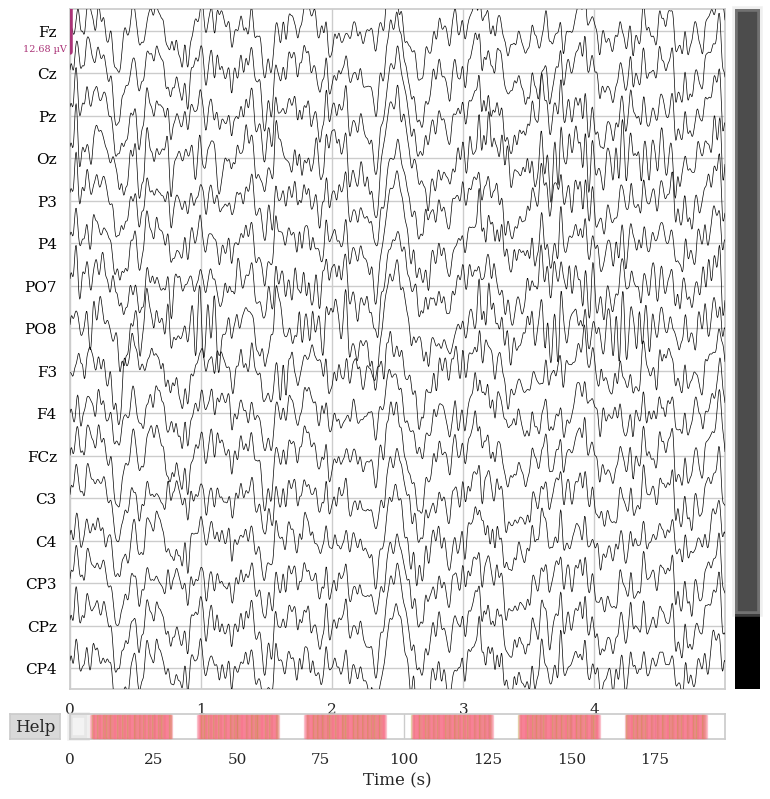

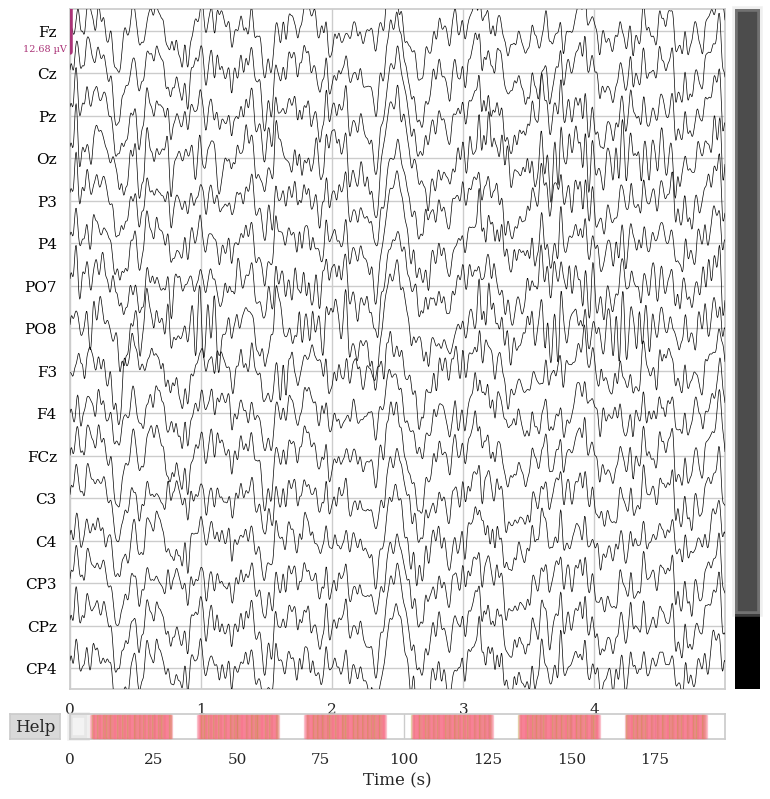

In [9]:
# Plot a few seconds of EEG
raw.plot(n_channels=16, duration=5, scalings="auto")


## Dataset (1 subject, 8 channels)

In [ ]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)

In [ ]:
subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

In [ ]:
unicorn_channels = [
    "Fz",
    "C3",
    "Cz",
    "C4",
    "Pz",
    "PO7",
    "Oz",
    "PO8",
]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw = dataset.datasets[0].raw

print("Channels after selection:", raw.ch_names)
print("Number of channels after selection:", len(raw.ch_names))




## Dataset (all subjects, 8 channels)

In [1]:
from braindecode.datasets import MOABBDataset

dataset = MOABBDataset(dataset_name="BNCI2014_009")  # all subjects by default
print("Number of recordings:", len(dataset.datasets))
print("Unique subjects:", sorted(dataset.description["subject"].unique()))

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of recordings: 30
Unique subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [2]:
unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw0 = dataset.datasets[0].raw
print("Channels after picking:", raw0.ch_names)
print("n_channels:", len(raw0.ch_names))

# quick subject check
print("Subjects:", sorted(dataset.description["subject"].unique()))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

## Preprocessing

In [3]:
import numpy as np
from braindecode.preprocessing import (
    Preprocessor,
    preprocess,
)

# bandpass filter that matches dataset 
low_cut_hz = 0.1
high_cut_hz = 20.0
factor = 1e6 # to convert from V to uV
#resample_sfreq = 128  # set to none if you want to keep it at 256 Hz

def to_microvolts(data):
    return data * factor

preprocessors = [
    # keep only EEG channels
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),
    # scale the data
    Preprocessor(to_microvolts),
    # bandpass filter for ERPs
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),
]

# apply the preprocessors to the dataset
preprocess(dataset, preprocessors, n_jobs=-1)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/preprocessing/preprocess.py:76: UserWarning: apply_on_array can only be True if fn is a callable function. Automatically correcting to apply_on_array=False.
  warn(


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8449 samples (33.004 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rip

## Creating trial windows

In [4]:
from braindecode.preprocessing import create_windows_from_events

# read sampling frequency from the data
sfreq = dataset.datasets[0].raw.info["sfreq"]
print("sampling frequency:", sfreq)

# trial window setting for P300
tmin = 0.0
tmax = 0.8 # P300 window 300ms to 800ms

start_offset = int(np.round(tmin * sfreq))
stop_offset = int(np.round(tmax * sfreq))

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=start_offset,
    trial_stop_offset_samples=stop_offset,
    preload=True,
)

print(windows_dataset)
print(windows_dataset.description.head())
print(windows_dataset.description.columns)


sampling frequency: 256.0
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [5]:
# count number of target and non-target trials
y = np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])

n_nontarget = np.sum(y == 0)
n_target = np.sum(y == 1)

print(f"NonTarget (0): {n_nontarget}")
print(f"Target (1): {n_target}")
print(f"Total windows: {len(y)}")



NonTarget (0): 14400
Target (1): 2880
Total windows: 17280


## Splitting the dataset into training and validation sets
- one subject

In [6]:
# check how many sessions 
print(windows_dataset.description["session"].unique())

['0' '1' '2']


In [7]:
from braindecode.datasets import BaseConcatDataset

# Split dataset into training and test based on sessions
splits = windows_dataset.split("session")
session_keys = sorted(list(splits.keys()), key=str)

print("Available sessions:", session_keys)

if len(session_keys) < 2:
    raise RuntimeError("Not enough sessions found for a cross-session split.")

train_keys = session_keys[:-1]
test_key = session_keys[-1]

# Collect datasets for training sessions
train_datasets = []
for k in train_keys:
    train_datasets.extend(splits[k].datasets)

# Build new BaseConcatDataset
train_set = BaseConcatDataset(train_datasets)

# Test set is just one split
test_set = splits[test_key]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train sessions:", train_keys, "Test session:", test_key)


Available sessions: ['0', '1', '2']
Train windows: 1152 Test windows: 576
Train sessions: ['0', '1'] Test session: 2


In [8]:
# count number of target and non-target trials in train and test sets
def get_labels_from_base_concat(dataset):
    labels = []
    for ds in dataset.datasets:
        labels.extend(ds.y)
    return np.array(labels)

y_train = get_labels_from_base_concat(train_set)
y_test = get_labels_from_base_concat(test_set)

print("Training set:")
print("  NonTarget:", np.sum(y_train == 0))
print("  Target:", np.sum(y_train == 1))

print("Test set:")
print("  NonTarget:", np.sum(y_test == 0))
print("  Target:", np.sum(y_test == 1))



Training set:
  NonTarget: 960
  Target: 192
Test set:
  NonTarget: 480
  Target: 96


## Train and test splits
- full dataset

In [7]:
from braindecode.datasets import BaseConcatDataset

# choose the held-out participant
test_subject = 10

# split windows by subejct 
by_subject = windows_dataset.split("subject")
subject_keys = sorted(list(by_subject.keys()), key=int)
print("Available subjects:", subject_keys)

# build training set from all but the held-out subject
train_datasets = []
for s in subject_keys:
    if int(s) == int(test_subject):
        continue
    train_datasets.extend(by_subject[s].datasets)

train_set = BaseConcatDataset(train_datasets)
test_set = by_subject[str(test_subject)] if str(test_subject) in by_subject else by_subject[test_subject]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train subjects:", [s for s in subject_keys if int(s) != int(test_subject)], "Test subject:", test_subject)


Available subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Train windows: 15552 Test windows: 1728
Train subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9'] Test subject: 10


## Create groups for CV (session-based)
- One participant

In [9]:
# For Braindecode BaseConcatDataset, this gives per-window metadata (one row per window)
train_meta = train_set.get_metadata()

print("Metadata columns:", train_meta.columns.tolist())
print("Unique sessions in TRAIN:", train_meta["session"].unique())

# Groups must have length == number of windows
groups = train_meta["session"].to_numpy()

n_sessions = len(np.unique(groups))
print("Number of sessions in TRAIN:", n_sessions)

if n_sessions < 2:
    raise RuntimeError("Need at least 2 sessions in training set for session-based CV.")

Metadata columns: ['i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'target', 'subject', 'session', 'run']
Unique sessions in TRAIN: ['0' '1']
Number of sessions in TRAIN: 2


In [10]:
from sklearn.model_selection import GroupKFold
from skorch.callbacks import EpochScoring

# define cross validation splitter
# if you have 2 training sessions, this becomes 2-fold GroupKFold (each session is used once as validation)
cv = GroupKFold(n_splits=n_sessions)

# callbacks for logging
train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

## CV split 
- all participants

In [8]:
from sklearn.model_selection import LeaveOneGroupOut

train_meta = train_set.get_metadata()
groups = train_meta["subject"].to_numpy()

cv = LeaveOneGroupOut()

print("groups_train:", groups.shape, "unique:", np.unique(groups))

groups_train: (15552,) unique: [1 2 3 4 5 6 7 8 9]


# ShallowFBCSNet

## Model from Schirrmeister et al., 2017

Adapted from https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html

## Build the model

In [14]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available() # check if GPU is available and if true chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to be able to roughly reproduce results
# note that with cudnn benchmark set to true, GPU indeterminism
# may still make results substantially different between runs
# to obtain more consistent results at the cost of increased computation time,
# you can set the cudnn_benchmark to False in 'set_random_seed'
# or remove 'torch.backends.cudnn.benchmark = True' 
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# for P300, infer number of classes from labels in train set
y_train = train_set.y if hasattr(train_set, "y") else np.array([train_set[i][1] for i in range(len(train_set))])
classes = np.unique(y_train)
n_classes = len(classes)

# Same as tutorial: infer input dims from one batch element
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

print("Detected classes:", classes, "n_classes:", n_classes)
print("n_chans:", n_chans, "n_times:", n_times)

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    n_times = n_times,
    final_conv_length="auto", # braindecode runs a dummy forward pass to infer the final layer size
)

model.to(device) # send the model to GPU if available or CPU
print(model)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Detected classes: [0 1] n_classes: 2
n_chans: 8 n_times: 409
Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 40, 385, 1]           13,840                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 40, 385, 1]           [1, 40, 385, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5           [1, 40, 385, 1]           [1, 40, 385, 1]           --                        --
├─AvgPool2d (pool): 1-6                 

## Model training (With CV and HPO)

### HPO with CV
This picks the best paramters according to a primary metric

In [ ]:
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

from braindecode import EEGClassifier

def build_shallow_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    batch_size,
    weight_decay,
    drop_prob,
    n_filters_time,
    filter_time_length,
    max_epochs,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )

    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    
    # Build a fresh ShallowFBCSPNet + EEGClassifier for one hyperparameter configuration.
    # Always build a new model per fold/trial to avoid state leakage.

    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None

    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor="valid_loss",
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None),  # we do external CV, so no internal split
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf

In [ ]:
import numpy as np
import optuna
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score, accuracy_score

MAX_EPOCHS = 80
# Choose what Optuna should optimize
primary_metric = "bacc"  # options: "bacc", "acc", "auc", "ap"

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Training hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    max_epochs = MAX_EPOCHS
    patience = trial.suggest_int("patience", 8, 15)
    drop_prob = trial.suggest_float("drop_prob", 0.05, 0.6)
    
    # ShallowFBCSPNet architecture hyperparameters
    n_filters_time = trial.suggest_categorical("n_filters_time", [16, 24, 32, 40, 48, 64])
    filter_time_length = trial.suggest_categorical("filter_time_length", [33, 49, 65, 97])
    n_filters_spat = trial.suggest_categorical("n_filters_spat", [16, 24, 32, 40, 48])
    pool_time_length = trial.suggest_categorical("pool_time_length", [25, 50, 75, 100])
    pool_time_stride = pool_time_length // 2  
    

    fold_scores = []

    # trial.set_user_attr("fold_metrics", [])  # uncomment if you want per-fold dicts

    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        # Keep your seeding scheme consistent with your EEGNet objective
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Internal split for early stopping (within tr_ds_full)
        n_tr = len(tr_ds_full)  
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_shallow_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            max_epochs=max_epochs,
            n_filters_spat=n_filters_spat,
            pool_time_length=pool_time_length,
            pool_time_stride=pool_time_stride,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        # Compute metrics
        acc = accuracy_score(y_va_true, y_va_pred)
        bacc = balanced_accuracy_score(y_va_true, y_va_pred)

        # Only meaningful for binary
        if len(np.unique(y_va_true)) == 2:
            auc = roc_auc_score(y_va_true, y_va_proba[:, 1])
            ap = average_precision_score(y_va_true, y_va_proba[:, 1])
        else:
            auc = np.nan
            ap = np.nan

        if primary_metric == "bacc":
            fold_value = bacc
        elif primary_metric == "acc":
            fold_value = acc
        elif primary_metric == "auc":
            fold_value = auc
        elif primary_metric == "ap":
            fold_value = ap
        else:
            raise ValueError(f"Unknown primary_metric: {primary_metric}")

        fold_scores.append(float(fold_value))

        # Report intermediate mean so Optuna can prune
        trial.report(float(np.nanmean(fold_scores)), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Save fold stats for this completed trial
    bacc_arr = np.array(fold_scores, dtype=float)
    trial.set_user_attr("fold_bacc", bacc_arr.tolist())
    trial.set_user_attr("fold_bacc_mean", float(np.mean(bacc_arr)))
    trial.set_user_attr("fold_bacc_std", float(np.std(bacc_arr)))

    mean_score = float(np.nanmean(fold_scores))
    print(f"Trial {trial.number} finished | mean {primary_metric}: {mean_score:.4f}")

    return float(np.nanmean(fold_scores))

Run the HPO

In [ ]:
# starting small to verify everything runs
n_trials = 30

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


In [ ]:
# After the run: inspect the best trial's fold stats
best = study.best_trial
print("Best trial fold bacc:", best.user_attrs.get("fold_bacc"))
print("Best trial mean bacc:", best.user_attrs.get("fold_bacc_mean"))
print("Best trial std bacc:", best.user_attrs.get("fold_bacc_std"))

In [ ]:
# Build a dataframe of all trials (including fold stats)
import pandas as pd

rows = []
for t in study.trials:
    rows.append({
        "trial": t.number,
        "value": t.value,
        "mean_bacc": t.user_attrs.get("fold_bacc_mean"),
        "std_bacc": t.user_attrs.get("fold_bacc_std"),
        "fold_bacc": t.user_attrs.get("fold_bacc"),
        **t.params,
    })

df = pd.DataFrame(rows)
df_sorted = df.sort_values("mean_bacc", ascending=False)
print(df_sorted.head(10)[["trial", "mean_bacc", "std_bacc"]])

### Final refit on full training set 

In [16]:
fallback_params_shallow = {
    "lr": 0.002718940016156451,
    "batch_size": 128,
    "weight_decay": 0.00010871003877839412,
    "patience": 11,
    "drop_prob": 0.4920220213261243,
    "n_filters_time": 40,
    "filter_time_length": 65,
    "n_filters_spat": 32,
    "pool_time_length": 25,
    "pool_time_stride": 25 // 2,
}

In [49]:
MAX_EPOCHS = 80

try:
    p = study.best_params
    source = "study.best_params"
except NameError:
    p = fallback_params_shallow
    source = "fallback_params_shallow"

set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_shallow = build_shallow_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=p["lr"],
    batch_size=p["batch_size"],
    weight_decay=p["weight_decay"],
    drop_prob=p["drop_prob"],
    n_filters_time=p["n_filters_time"],
    filter_time_length=p["filter_time_length"],
    max_epochs=MAX_EPOCHS,
    n_filters_spat=p["n_filters_spat"],
    pool_time_length=p["pool_time_length"],
    pool_time_stride=p["pool_time_length"] // 2,
    valid_ds=None,       
)

final_clf_shallow.fit(train_set, y=None)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_balanced_accuracy    train_loss     dur
-------  -------------------------  ------------  ------
      1                     0.5669        0.6110  0.8660
      2                     0.6797        0.3518  0.8235
      3                     0.7305        0.3115  0.8477
      4                     0.7494        0.2941  0.8220
      5                     0.7417        0.2953  0.8219
      6                     0.7518        0.2897  0.8357
      7                     0.7547        0.2897  0.8187
      8                     0.7649        0.2726  0.8168
      9                     0.7630        0.2787  0.8210
     10                     0.7712        0.2755  0.8271
     11                     0.7685        0.2701  0.8352
     12                     0.7684        0.2705  0.8456
     13                     0.7835        0.2604  0.8463
     14                     0.7845        0.2647  0.8170
     15                     0.7788        0.2619  0.8119
     16                     0.7

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 32, 345, 1]           12,880                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 32, 345, 1]           [1, 32, 345, 1]           64                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 32, 345, 1]           [1, 32, 345, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 32, 345, 1]           [1, 32, 27, 1]            --                        [25, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 32, 27, 1]            [1, 32, 27, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 32, 27, 1]            [1, 32, 27, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 32, 27, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 32, 27, 1]            [1, 2, 1, 1]              1,730                     [27, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 14,674
  Trainable params: 14,674
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.09
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.11
  =================================================================================================================================================,
)

### Save model after fit

In [19]:
import os

save_dir = "models_shallow"
os.makedirs(save_dir, exist_ok=True)

seed = 2025
run_id = "hpo_v1"

path_shallow = os.path.join(
    save_dir,
    f"shallow_{run_id}_seed{seed}.pkl"
)

final_clf_shallow.save_params(f_params=path_shallow)

# use build_shallow_clf to build a new classifier instance
# then load the saved parameters
#clf.initialize()
#clf.load_params(f_params=path_shallow)

### Test

In [51]:
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, accuracy_score
import numpy as np

meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

proba = final_clf_shallow.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, proba[:, 1])
    ap = average_precision_score(y_true, proba[:, 1])
else:
    auc = np.nan
    ap = np.nan

print("Held-out test Acc:", round(float(acc), 3))
print("Held-out test BAcc:", round(float(bacc), 3))
print("Held-out test AUC:", round(float(auc), 3) if not np.isnan(auc) else "nan")
print("Held-out test AP:", round(float(ap), 3) if not np.isnan(ap) else "nan")


Held-out test Acc: 0.931
Held-out test BAcc: 0.845
Held-out test AUC: 0.955
Held-out test AP: 0.857


In [31]:
p

{'lr': 0.002718940016156451,
 'batch_size': 128,
 'weight_decay': 0.00010871003877839412,
 'patience': 11,
 'drop_prob': 0.4920220213261243,
 'n_filters_time': 40,
 'filter_time_length': 65,
 'n_filters_spat': 32,
 'pool_time_length': 25,
 'pool_time_stride': 12}

### Results

20 trials
- {'lr': 0.0020290177394029388,
- 'batch_size': 128,
- 'weight_decay': 0.0009130273914206462,
- 'max_epochs': 14,
- 'n_filters_time': 60,
- 'filter_time_length': 35,
- 'drop_prob': 0.567686120090055}

30 trials (first time)
- {'lr': 0.0006697844425596637,
- 'batch_size': 64,
- 'weight_decay': 0.0003374623018539655,
- 'patience': 13,
- 'drop_prob': 0.2153401882629321,
- 'n_filters_time': 40,
- 'filter_time_length': 97,
- 'n_filters_spat': 32,
- 'pool_time_length': 50}
- pool_time_stride = pool_time_length / 2
- max epochs = 80


30 trials (second time)
- {'lr': 0.002718940016156451,
- 'batch_size': 128,
- 'weight_decay': 0.00010871003877839412,
- 'patience': 11,
- 'drop_prob': 0.4920220213261243,
-  'n_filters_time': 40,
- 'filter_time_length': 65,
- 'n_filters_spat': 32,
-  'pool_time_length': 25}
- pool_time_stride = pool_time_length / 2
- max_epochs=80



## Model training (without CV and HPO)

In [12]:
import torch
from braindecode import EEGClassifier
from skorch.callbacks import EpochScoring

best = {
    "lr": 0.004918979421142806,
    "batch_size": 64,
    "weight_decay": 0.0006549074844111317,
    "max_epochs": 22,
    "n_filters_time": 60,
    "filter_time_length": 15,
    "drop_prob": 0.3743087320311387,
}

train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

fast_model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto",
    n_filters_time=best["n_filters_time"],
    filter_time_length=best["filter_time_length"],
    drop_prob=best["drop_prob"],
).to(device)

fast_clf = EEGClassifier(
    fast_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=best["lr"],
    batch_size=best["batch_size"],
    max_epochs=30,          # use more epochs than your quick test run
    device=device,
    train_split=None,       # pure training, no CV inside this run
    iterator_train__shuffle=True,
    classes=[0, 1],
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_bacc", train_bacc_cb),
    ],
)

fast_clf.fit(train_set, y=None)


  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.8284        0.6293        0.4373  1.3562
      2            0.8597        0.6937        0.3464  0.9804
      3            0.8650        0.7115        0.3441  0.9783
      4            0.8647        0.7122        0.3417  0.9781
      5            0.8740        0.7321        0.3186  0.9709
      6            0.8774        0.7342        0.3090  0.9952
      7            0.8785        0.7410        0.3050  0.9993
      8            0.8814        0.7435        0.2966  0.9864
      9            0.8861        0.7547        0.2934  0.9801
     10            0.8859        0.7516        0.2843  0.9718
     11            0.8882        0.7564        0.2826  0.9769
     12            0.8864        0.7505        0.2836  0.9738
     13            0.8903        0.7573        0.2747  0.9785
     14            0.8904        0.7557        0.2780  0.9825
     15 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 40, 395, 1]           20,160                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 40, 395, 1]           [1, 40, 395, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 40, 395, 1]           [1, 40, 395, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 40, 395, 1]           [1, 40, 22, 1]            --                        [75, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 40, 22, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 40, 22, 1]            [1, 2, 1, 1]              1,762                     [22, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 22,002
  Trainable params: 22,002
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.13
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.15
  =================================================================================================================================================,
)

### Test

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# get true labels from metadata (robust label column)
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# predict proba and labels
y_proba = fast_clf.predict_proba(test_set)          # shape (N, 2)
y_pred = np.argmax(y_proba, axis=1)

# metrics
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

# Only compute AUC/AP if both classes exist in y_true
has_both = (len(np.unique(y_true)) == 2)
auc = roc_auc_score(y_true, y_proba[:, 1]) if has_both else float("nan")
ap  = average_precision_score(y_true, y_proba[:, 1]) if has_both else float("nan")

print(f"Test accuracy:          {acc:.3f}")
print(f"Test balanced accuracy: {bacc:.3f}")
print(f"Test ROC AUC:           {auc:.3f}")
print(f"Test Avg Precision:     {ap:.3f}")



Test accuracy:          0.907
Test balanced accuracy: 0.810
Test ROC AUC:           0.933
Test Avg Precision:     0.799


## Plot Results (CV + HPO)

In [17]:
# collect predictions and metrics

import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score

# probabilities and predictions
proba = final_clf_shallow.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

# extract true labels robustly
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy()

# metrics
auc = roc_auc_score(y_true, proba[:, 1])
bacc = balanced_accuracy_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print(f"Accuracy: {acc:.3f}")


AUC: 0.941
Balanced Accuracy: 0.848
Accuracy: 0.902


TRAIN y_true counts: Counter({0: 12960, 1: 2592})
TRAIN y_pred counts: Counter({0: 13479, 1: 2073})


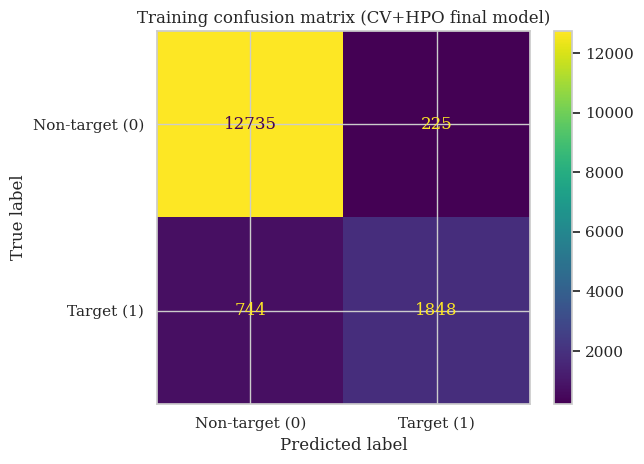

History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_balanced_accuracy', 'train_balanced_accuracy_best']


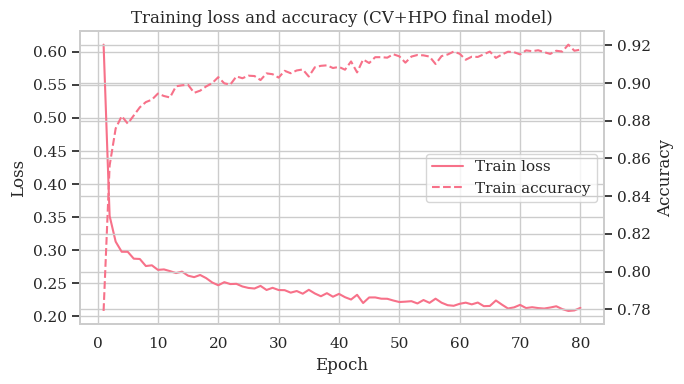

TEST y_true counts: Counter({0: 1440, 1: 288})
TEST y_pred counts: Counter({0: 1404, 1: 324})


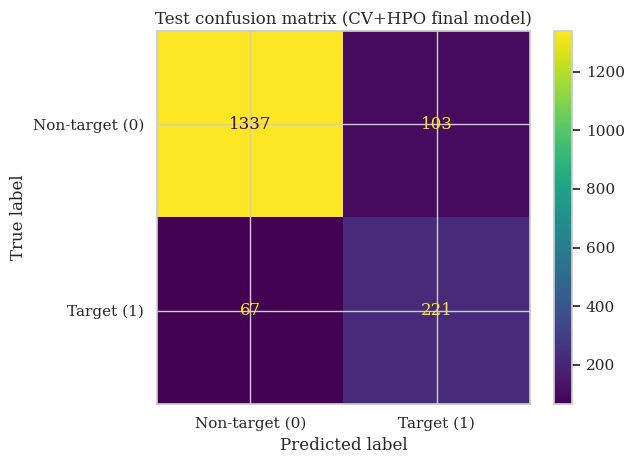

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# choose the model you want to plot for (CV+HPO final refit)
clf = final_clf_shallow

# label column (robust)
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"

# TRAIN confusion matrix
y_true_train = meta_train[label_col].to_numpy().astype(int)
y_proba_train = clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])
ConfusionMatrixDisplay(cm_train, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Training confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()

# TRAIN loss + accuracy curves (together)

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# accuracy (right axis) if logged
if "train_accuracy" in history.columns:
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], linestyle="--", label="Train accuracy")
    ax2.set_ylabel("Accuracy")

    # merged legend
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="center right")
else:
    ax1.legend(loc="upper right")
    ax1.text(
        0.02, 0.02,
        "train_accuracy not logged (add EpochScoring callback)",
        transform=ax1.transAxes
    )

plt.title("Training loss and accuracy (CV+HPO final model)")
plt.tight_layout()
plt.show()

# 3) TEST confusion matrix
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true_test = meta_test[label_col_test].to_numpy().astype(int)

y_proba_test = clf.predict_proba(test_set)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("TEST y_true counts:", Counter(y_true_test))
print("TEST y_pred counts:", Counter(y_pred_test))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=[0, 1])
ConfusionMatrixDisplay(cm_test, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Test confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_balanced_accuracy', 'train_balanced_accuracy_best']


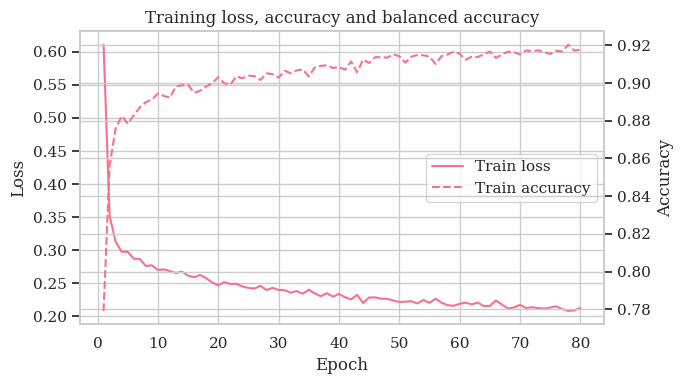

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy")
plt.tight_layout()
plt.show()


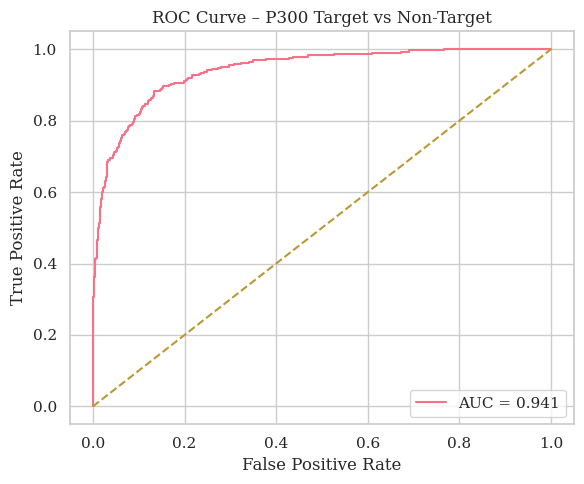

In [21]:
#ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, proba[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – P300 Target vs Non-Target")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


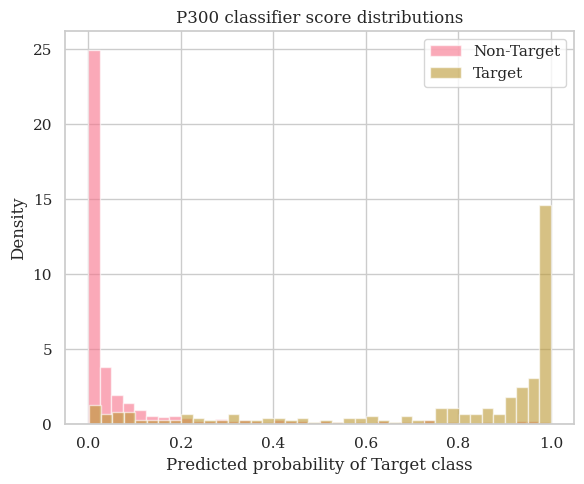

In [22]:
# predicted probability distributions

plt.figure(figsize=(6, 5))

plt.hist(
    proba[y_true == 0, 1],
    bins=40,
    alpha=0.6,
    label="Non-Target",
    density=True,
)

plt.hist(
    proba[y_true == 1, 1],
    bins=40,
    alpha=0.6,
    label="Target",
    density=True,
)

plt.xlabel("Predicted probability of Target class")
plt.ylabel("Density")
plt.title("P300 classifier score distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot Results (without CV and HPO)

TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 960, 1: 192})


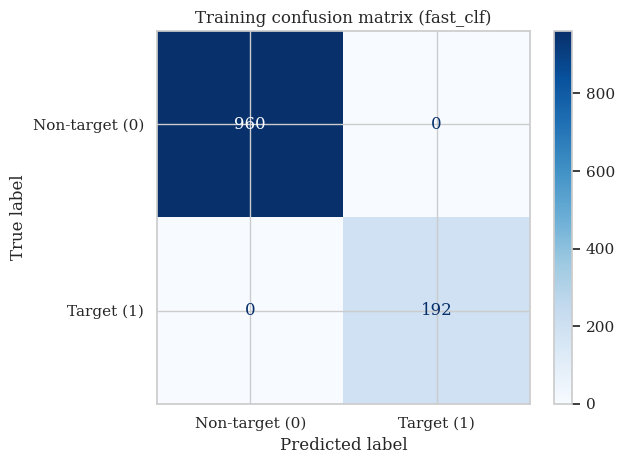

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# true labels from training metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_true_train = meta_train[label_col].to_numpy().astype(int)

# predictions on training set
y_proba_train = fast_clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

# sanity checks (helps catch class collapse)
print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

# confusion matrix (force 2x2)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Non-target (0)", "Target (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Training confusion matrix (fast_clf)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


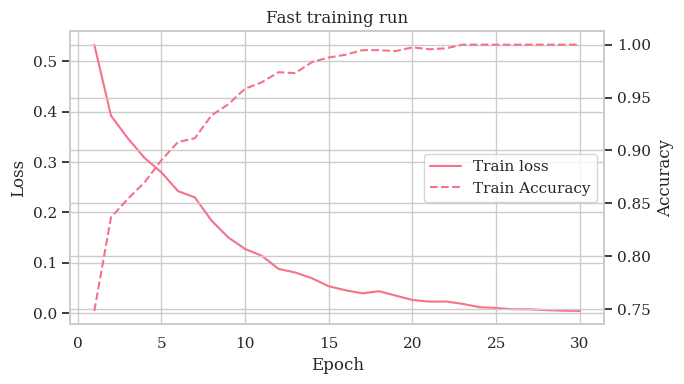

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history)
    print("History columns:", list(hist.columns))

    epochs = hist["epoch"]

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Left axis: loss
    ax1.plot(epochs, hist["train_loss"], label="Train loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Right axis: accuracy (only if logged)
    acc_cols = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(epochs, hist[c], linestyle="--", label=c.replace("_", " ").title())
        ax2.set_ylabel("Accuracy")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    else:
        ax1.legend(loc="upper right")

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_and_accuracy(fast_clf, title="Fast training run")
# plot_loss_and_accuracy(best_clf, title="Best HPO training run")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(fast_clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy (no CV/HPO)")
plt.tight_layout()
plt.show()


y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


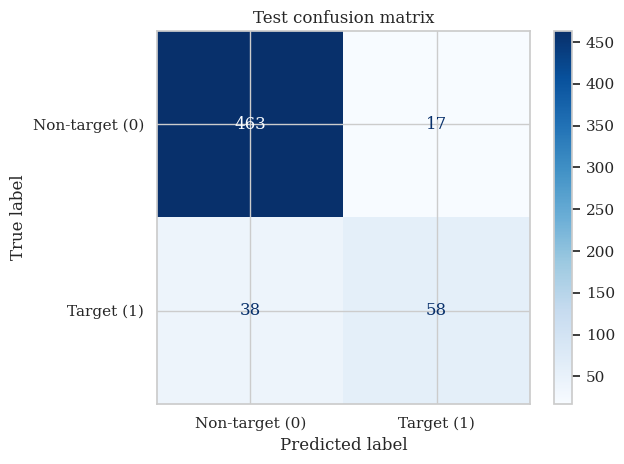

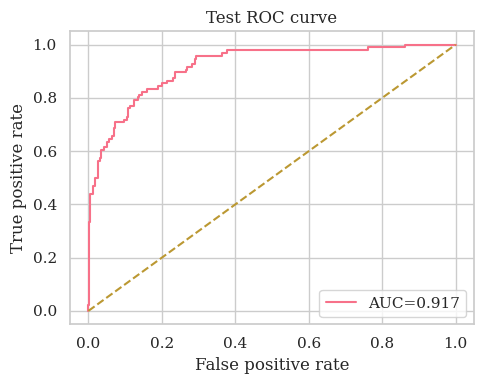

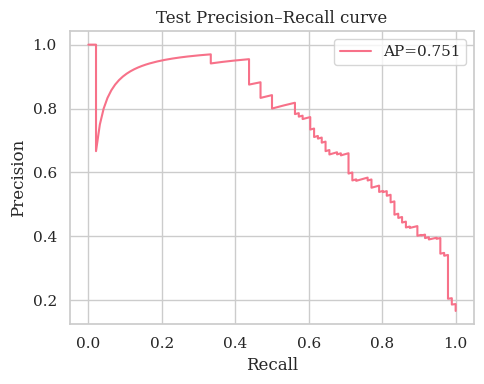

y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# extract true labels from test metadata
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# model predictions
y_proba = fast_clf.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

# sanity checks (VERY useful)
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# confusion matrix (force 2x2)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-target (0)", "Target (1)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Test confusion matrix")
plt.tight_layout()
plt.show()


# ROC curve
if has_both:
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Test ROC curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Precision-Recall curve (often more informative for P300 imbalance)
if has_both:
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision–Recall curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# sanity prints for the "only two squares filled" confusion matrix issue
from collections import Counter
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# EEGNet

Adapted from https://braindecode.org/stable/generated/braindecode.models.EEGNet.html
We train the model on the same exact windows and data splits as before but use EEGNet instead. 

### Model from Lawhern et al., 2018

## Infer input dimensions
We try to infer n_chans and n_times from the first window in training set. Braindecode WindowDataset returns (X,y,i) in __getitem__, where X is a torch.Tensor with shape (n_chans, n_times) OR sometimes (1, n_chans, n_times) depending on transforms. 

In [9]:
import torch
import numpy as np
from collections import Counter

from braindecode.models import EEGNet
from braindecode import EEGClassifier

X0 = train_set[0][0]  # get first window data
if isinstance(X0, np.ndarray):
    X0 = torch.tensor(X0)

# Sometimes people end up with (1, n_chans, n_times) depending on transforms
if X0.ndim == 3 and X0.shape[0] == 1:
    X0 = X0.squeeze(0)

if X0.ndim != 2:
    raise RuntimeError(f"Expected 2D data (n_chans, n_times), got shape: {tuple(X0.shape)}")

n_chans = int(X0.shape[0])
n_times = int(X0.shape[1])

# infer label columns name from metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_train = meta_train[label_col].to_numpy().astype(int)

classes = np.unique(y_train)
n_classes = int(classes.size)

print("Label column:", label_col)
print("Classes found:", classes, "n_classes:", n_classes)
print("EEGNet input dims:", "n_chans =", n_chans, "n_times =", n_times)
print("Train label counts:", Counter(y_train))


Label column: target
Classes found: [0 1] n_classes: 2
EEGNet input dims: n_chans = 8 n_times = 409
Train label counts: Counter({0: 12960, 1: 2592})


In [10]:
# set device (check if GPU is available) and seeds (for reproducibility)
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"

if cuda:
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=20200220, cuda=cuda)

print("Using device:", device)

Using device: cuda


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


## Build EEGNet model

In [11]:
# EEGNet has several architecture paramters
# We keep defaults first -> After you get a baseline, you can tune F1, D, kernel_length, drop_prob, etc.

eegnet_model = EEGNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto", # infer final layer size
    # pool_mode="mean", # default; you can switch to "max" pooling if you want
    # drop_prob=0.25,   # default dropout probability
).to(device)

print(eegnet_model)


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNet (EEGNet)                                              [1, 8, 409]               [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                                 [1, 8, 409]               [1, 8, 409, 1]            --                        --
├─Rearrange (dimshuffle): 1-2                                [1, 8, 409, 1]            [1, 1, 8, 409]            --                        --
├─Conv2d (conv_temporal): 1-3                                [1, 1, 8, 409]            [1, 8, 8, 410]            512                       [1, 64]
├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 8, 410]            [1, 8, 8, 410]            16                        --
├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 8, 410]            [1, 16, 1, 410]           --                  

## EEGNet fast baseline (no CV, no HPO)

In [ ]:
from skorch.callbacks import EpochScoring
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Accuracy (train)
train_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=True,
    name="train_accuracy",
    lower_is_better=False,
)

# Balanced accuracy (train)
train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_balanced_accuracy",
    lower_is_better=False,
)
# Accuracy (valid)
valid_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=False,
    name="valid_accuracy",
    lower_is_better=False,
)
# Balanced accuracy (valid)
valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_balanced_accuracy",
    lower_is_better=False,
)


# Fast baseline hyperparams based on first run of CV and HPO
lr = 0.00038809762950116534
batch_size = 32
weight_decay: 0.000997517836738623
drop_prob: 0.530710204487765
F1: 16
D: 4
kernel_length: 128
max_epochs = 21

clf_eegnet_fast = EEGClassifier(
    eegnet_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    batch_size=batch_size,
    max_epochs=max_epochs,
    device=device,
    iterator_train__shuffle=True,
    train_split=None,
    classes=list(range(n_classes)),
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_balanced_accuracy", train_bacc_cb),
        ("valid_accuracy", valid_acc_cb),
        ("valid_balanced_accuracy", valid_bacc_cb),
    ],
)

# Fit once on full training set
clf_eegnet_fast.fit(train_set, y=None)

  epoch    train_accuracy    train_balanced_accuracy    train_loss     dur
-------  ----------------  -------------------------  ------------  ------
      1            0.9661                     0.9297        0.0875  6.2189
      2            0.9644                     0.9245        0.0995  4.5728
      3            0.9679                     0.9411        0.0895  2.9721
      4            0.9688                     0.9354        0.0866  2.9535
      5            0.9549                     0.9062        0.0963  2.5902
      6            0.9653                     0.9333        0.0863  2.7161
      7            0.9618                     0.9208        0.0940  2.4877
      8            0.9696                     0.9359        0.0800  2.5340
      9            0.9635                     0.9302        0.0833  2.5244
     10            0.9757                     0.9479        0.0769  2.6581
     11            0.9679                     0.9328        0.0937  2.5279
     12            0.9740

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                        [16, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 16, 1]            256                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 410]           [1, 16, 1, 410]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 410]           [1, 16, 1, 410]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 410]           [1, 16, 1, 102]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 102]           [1, 16, 1, 102]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 102]           [1, 16, 1, 103]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 103]           [1, 16, 1, 103]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 103]           [1, 16, 1, 103]           32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 103]           [1, 16, 1, 103]           --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 103]           [1, 16, 1, 12]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 12]            [1, 16, 1, 12]            --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 12]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 12]            [1, 2, 1, 1]              386                       [1, 12]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =========================================================================================================

### Evaluate of test set

In [42]:
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = clf_eegnet_fast.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet FAST baseline (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")

EEGNet FAST baseline (test)
  accuracy: 0.9080
  balanced_accuracy: 0.8365
  roc_auc: 0.9144
  avg_precision: 0.7961


## EEGNet with HPO and CV

In this section we tune EEGNet hyperparamters using optuna. Each optuna trial is evaluated via GroupKFold cross-validation and we optimise mean balanced accuracy across folds.

In [ ]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

def build_eegnet_clf(
    n_chans, 
    n_times, 
    n_classes, 
    device, 
    lr, 
    batch_size, 
    weight_decay, 
    drop_prob, 
    F1, 
    D, 
    kernel_length, 
    depthwise_kernel_length,
    max_epochs,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )
    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )
    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    # Create a fresh EEGNet + EEGClassifier for a given hyperparameter configuration.
    # We build a new model each time so folds and trials do not leak state.
    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None

    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor="valid_loss",
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None), 
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf


**Trying with optuna**
- Automated loop that tries hyperparamter combinations and keeps best one depending on single score chosen (different than one used in ShallowNet).
- Optuna keeps track of scores and decides what to do next. 
- Optuna prunes trials that look bad based on intermediate results.
    - MedianPruner logic:
        - Optuna looks at the distribution of intermediate scores from previous trials in that step and if current trial's intermediate score is worse than median, it gets pruned.
- Every paramter combination trained and evaluated across CV folds (unless pruned).
    - The loop folds:
        - build model with those hyperparameters.
        - fit on training fold.
        - predict on validation fold.
        - compute balanced accuracy.
    - Return mean fold score.
- study.optimize:
    - optuna runs objective(trial) up to n_trials and each run is a new hyperparameter suggestion.

**Continuous Paramters**
- Log: samples log space between values
    - lr
- Uniform sampling: samples over those ranges
    - weight decay, drop_prob
**Discrete choices**
- picks one option each
    - batch size, f1, D, kernel length
**Integer range**
- picks integer in range
    - max epochs

**TPE (tree-structured parzen estimator)**
- It is a Bayesian optimisation style sampler
- Intuition:
    - after some trials, Optuna splits observed trials into "good" trials (high objective values) and "bad" trials (low objective values)
    - It models where "good" hyperparamters tend to lie and then samples new candidates that are more likely to come from the "good" region"
- Early trials are more exploratory, while later trials are more likely to come from a good region

**Training parameters:**\
learning rate (lr): controls how big each gradient update is (too big=unstable training, too low=very slow learning).

batch_size: number of trials processed before one optimiser update (smaller=noisier gradients, more regularisation and larger=smoother gradients, can overfit more easily).

weight_decay: L2 regularisation strength (penalises large weights to prevent overfitting).

drop_prob (dropout prob): fraction of activations randomly set to zero during training (too low=weak regularisation and too high=underfitting).

max_epochs: number of full passes over training data (more=better convergence but risk of overfitting).

**EEGNet architecture parameters:**\
F1 (number of temporal filters): filters in first temporal convolution layer. Controls how many distinct temporal patterns are learned (larger=more expressive temporal modelling but higher risk of overfitting).

kernel_length: length of temporal convolution kernel (in samples). Determines the temporal window the model "sees" at once. Short kenerls capture sharp/fast components while longer ones capture slow/sustained ERP components.

D (depth multiplier): controls how many spatial filters are learned per temporal filter. Implemented via depthwise convolution. Larger D means more spatial patterns per frequency/temporal feature and more paramters.








In [ ]:
import optuna
from sklearn.metrics import balanced_accuracy_score, accuracy_score

MAX_EPOCHS = 80

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Hyperparameter search space (moderate ranges for EEGNet)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    drop_prob = trial.suggest_float("drop_prob", 0.1, 0.6)

    # EEGNet architecture knobs
    F1 = trial.suggest_categorical("F1", [4, 8, 16, 32])
    D = trial.suggest_categorical("D", [1, 2, 4])
    kernel_length = trial.suggest_categorical("kernel_length", [16, 32, 64, 96, 128])
    depthwise_kernel_length = trial.suggest_categorical("depthwise_kernel_length", [8, 16, 24, 32])

    patience = trial.suggest_int("patience", 8, 15)

    max_epochs = MAX_EPOCHS

    fold_scores = []

    # Loop folds
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Inner split inside the training fold for early stopping
        n_tr = len(tr_ds_full)
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_eegnet_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            F1=F1,
            D=D,
            kernel_length=kernel_length,
            max_epochs=max_epochs,
            depthwise_kernel_length=depthwise_kernel_length,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        # Validation predictions
        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        fold_bacc = balanced_accuracy_score(y_va_true, y_va_pred)
        fold_scores.append(fold_bacc)

        # Report intermediate score so Optuna can prune bad trials
        trial.report(np.mean(fold_scores), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Save fold stats for this completed trial
    bacc_arr = np.array(fold_scores, dtype=float)
    trial.set_user_attr("fold_bacc", bacc_arr.tolist())
    trial.set_user_attr("fold_bacc_mean", float(np.mean(bacc_arr)))
    trial.set_user_attr("fold_bacc_std", float(np.std(bacc_arr)))


    mean_bacc = float(np.mean(bacc_arr))
    print(f"Trial {trial.number} finished | mean bacc: {mean_bacc:.4f}")

    return mean_bacc


Run the HPO

In [17]:
# starting small to verify everything runs
n_trials = 40

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Trial 0 started


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8054                     0.5484        0.4659       0.8567            0.8567                     0.6271        0.5385  1.8429
      2            0.8668                     0.6465        0.3270       0.8849            0.8849                     0.7046        0.3518  1.3770
      3            0.8828                     0.7113        0.2860       0.8907            0.8907                     0.7314        0.2843  1.3844
      4            0.8873                     0.7321        0.2702       0.8962            0.8962                     0.7664        0.2648  1.3481
      5            0.8930                     0.7484        0.2625       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8134                     0.5577        0.4593       0.8560            0.8560                     0.6627        0.5513  1.3555
      2            0.8701                     0.6457        0.3300       0.8788            0.8788                     0.7382        0.3734  1.3511
      3            0.8815                     0.6974        0.2931       0.8842            0.8842                     0.7553        0.3028  1.3502
      4            0.8861                     0.7132        0.2788       0.8922            0.8922                     0.7764        0.2797  1.3533
      5            0.8918                     0.7385        0.2667       0.8962            0.8962                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8285                     0.5395        0.4396       0.8527            0.8527                     0.6250        0.5416  1.3440
      2            0.8630                     0.6308        0.3284       0.8730            0.8730                     0.6812        0.3577  1.3377
      3            0.8849                     0.7129        0.2804       0.8886            0.8886                     0.7368        0.2818  1.3338
      4            0.8944                     0.7407        0.2604       0.8987            0.8987                     0.7925        0.2571  1.3618
      5            0.8998                     0.7586        0.2480       0.9001            0.9001                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7943                     0.5305        0.4808       0.8549            0.8549                     0.5664        0.5195  1.3320
      2            0.8587                     0.6170        0.3443       0.8734            0.8734                     0.6511        0.3528  1.3436
      3            0.8776                     0.6959        0.2979       0.8857            0.8857                     0.7183        0.2962  1.3352
      4            0.8830                     0.7210        0.2805       0.8878            0.8878                     0.7380        0.2766  1.3376
      5            0.8909                     0.7436        0.2674       0.8973            0.8973                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8231                     0.5282        0.4516       0.8415            0.8415                     0.6069        0.5169  1.3334
      2            0.8615                     0.6052        0.3438       0.8632            0.8632                     0.6820        0.3616  1.3383
      3            0.8740                     0.6637        0.3123       0.8828            0.8828                     0.7367        0.3011  1.3408
      4            0.8792                     0.6858        0.2950       0.8907            0.8907                     0.7622        0.2792  1.3314
      5            0.8843                     0.7078        0.2848       0.8933            0.8933                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8044                     0.5369        0.4691       0.8437            0.8437                     0.6553        0.5644  1.3367
      2            0.8680                     0.6377        0.3342       0.8690            0.8690                     0.7371        0.3878  1.3327
      3            0.8824                     0.7071        0.2888       0.8860            0.8860                     0.7551        0.2994  1.3436
      4            0.8890                     0.7283        0.2727       0.8922            0.8922                     0.7700        0.2725  1.3389
      5            0.8937                     0.7465        0.2587       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8042                     0.5259        0.4667       0.8632            0.8632                     0.6586        0.5318  1.3317
      2            0.8650                     0.6428        0.3295       0.8889            0.8889                     0.7272        0.3302  1.3344
      3            0.8760                     0.6979        0.2959       0.8969            0.8969                     0.7577        0.2659  1.3334
      4            0.8837                     0.7221        0.2809       0.9020            0.9020                     0.7836        0.2494  1.3371
      5            0.8861                     0.7351        0.2707       0.9034            0.9034                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8246                     0.5443        0.4425       0.8618            0.8618                     0.5936        0.5028  1.3345
      2            0.8669                     0.6451        0.3277       0.8726            0.8726                     0.6446        0.3301  1.3294
      3            0.8799                     0.7059        0.2890       0.8831            0.8831                     0.7252        0.2879  1.3346
      4            0.8876                     0.7313        0.2726       0.8864            0.8864                     0.7457        0.2747  1.3372
      5            0.8967                     0.7576        0.2582       0.8936            0.8936                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8105                     0.5164        0.4630       0.8477            0.8477                     0.5980        0.5546  1.3339
      2            0.8584                     0.6162        0.3403       0.8687            0.8687                     0.6908        0.3727  1.3493
      3            0.8741                     0.6825        0.3038       0.8763            0.8763                     0.7290        0.3104  1.3416
      4            0.8834                     0.7100        0.2836       0.8864            0.8864                     0.7584        0.2882  1.3358
      5            0.8889                     0.7332        0.2763       0.8871            0.8871                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7492                     0.5473        0.5535       0.8477            0.8477                     0.5731        0.5809  1.1698
      2            0.8519                     0.5802        0.3843       0.8730            0.8730                     0.6723        0.4117  1.1435
      3            0.8730                     0.6643        0.3238       0.8878            0.8878                     0.7166        0.3160  1.1422
      4            0.8789                     0.6990        0.2966       0.8936            0.8936                     0.7340        0.2838  1.1415
      5            0.8851                     0.7211        0.2819       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7885                     0.5371        0.5109       0.8455            0.8455                     0.6028        0.5677  1.1357
      2            0.8516                     0.5615        0.3783       0.8640            0.8640                     0.6708        0.4003  1.1445
      3            0.8694                     0.6407        0.3217       0.8770            0.8770                     0.7103        0.3175  1.1380
      4            0.8785                     0.6849        0.2967       0.8799            0.8799                     0.7316        0.2935  1.1391
      5            0.8845                     0.7034        0.2835       0.8853            0.8853                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8064                     0.5531        0.4924       0.8415            0.8415                     0.6044        0.5428  1.1416
      2            0.8481                     0.5611        0.3761       0.8589            0.8589                     0.6491        0.3955  1.1423
      3            0.8705                     0.6463        0.3218       0.8726            0.8726                     0.7004        0.3214  1.1407
      4            0.8765                     0.6834        0.2971       0.8788            0.8788                     0.7244        0.2943  1.1321
      5            0.8827                     0.7073        0.2823       0.8849            0.8849                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7644                     0.5360        0.5316       0.8506            0.8506                     0.5841        0.5748  1.1353
      2            0.8516                     0.5890        0.3781       0.8658            0.8658                     0.6843        0.4022  1.1399
      3            0.8686                     0.6544        0.3256       0.8784            0.8784                     0.7149        0.3180  1.1397
      4            0.8781                     0.6949        0.3009       0.8893            0.8893                     0.7444        0.2900  1.1406
      5            0.8857                     0.7197        0.2853       0.8947            0.8947                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8239                     0.5395        0.4648       0.8459            0.8459                     0.6206        0.5309  1.1335
      2            0.8569                     0.5843        0.3573       0.8629            0.8629                     0.6789        0.3713  1.1466
      3            0.8676                     0.6410        0.3242       0.8730            0.8730                     0.7108        0.3098  1.1334
      4            0.8714                     0.6652        0.3058       0.8781            0.8781                     0.7286        0.2905  1.1359
      5            0.8751                     0.6806        0.2942       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7938                     0.5358        0.5083       0.8477            0.8477                     0.5997        0.5621  1.1420
      2            0.8580                     0.5996        0.3646       0.8629            0.8629                     0.6469        0.3928  1.1562
      3            0.8709                     0.6600        0.3199       0.8716            0.8716                     0.6911        0.3245  1.1386
      4            0.8777                     0.6889        0.2986       0.8802            0.8802                     0.7153        0.3011  1.1390
      5            0.8820                     0.7087        0.2876       0.8835            0.8835                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7674                     0.5524        0.5273       0.8542            0.8542                     0.6332        0.5580  1.1366
      2            0.8470                     0.5818        0.3931       0.8755            0.8755                     0.6754        0.4015  1.1478
      3            0.8633                     0.6349        0.3422       0.8893            0.8893                     0.7189        0.3171  1.1557
      4            0.8713                     0.6748        0.3116       0.8969            0.8969                     0.7529        0.2810  1.1333
      5            0.8796                     0.7025        0.2952       0.9023            0.9023                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7918                     0.5385        0.5006       0.8527            0.8527                     0.5994        0.5344  1.1412
      2            0.8491                     0.5781        0.3773       0.8600            0.8600                     0.6204        0.3839  1.1384
      3            0.8599                     0.6318        0.3332       0.8672            0.8672                     0.6461        0.3175  1.1349
      4            0.8769                     0.6940        0.3022       0.8788            0.8788                     0.6845        0.2897  1.1390
      5            0.8825                     0.7170        0.2782       0.8864            0.8864                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7991                     0.5151        0.4978       0.8361            0.8361                     0.5212        0.5409  1.1596
      2            0.8420                     0.5390        0.3804       0.8542            0.8542                     0.6209        0.3957  1.1378
      3            0.8574                     0.6128        0.3368       0.8698            0.8698                     0.6820        0.3327  1.1466
      4            0.8667                     0.6545        0.3147       0.8781            0.8781                     0.7180        0.3097  1.1431
      5            0.8748                     0.6855        0.3004       0.8813            0.8813                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8018                     0.5333        0.4814       0.8433            0.8433                     0.6434        0.6072  1.9247
      2            0.8516                     0.6002        0.3698       0.8690            0.8690                     0.7138        0.5062  1.3985
      3            0.8719                     0.6879        0.3222       0.8860            0.8860                     0.7239        0.4037  1.4006
      4            0.8764                     0.7013        0.3036       0.8810            0.8810                     0.7621        0.3508  1.4048
      5            0.8790                     0.7197        0.2933       0.8835            0.8835                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7838                     0.5127        0.5023       0.8452            0.8452                     0.5880        0.5990  1.4001
      2            0.8459                     0.5585        0.3862       0.8647            0.8647                     0.6607        0.5090  1.3961
      3            0.8639                     0.6375        0.3332       0.8672            0.8672                     0.6931        0.4122  1.4075
      4            0.8714                     0.6728        0.3109       0.8799            0.8799                     0.7632        0.3558  1.4077
      5            0.8782                     0.6999        0.2958       0.8795            0.8795                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8141                     0.5127        0.4724       0.8162            0.8162                     0.6345        0.6031  1.4178
      2            0.8457                     0.5718        0.3802       0.8459            0.8459                     0.7231        0.5169  1.4039
      3            0.8629                     0.6451        0.3326       0.8658            0.8658                     0.7677        0.4208  1.4093
      4            0.8727                     0.6886        0.3041       0.8784            0.8784                     0.7778        0.3553  1.4050
      5            0.8787                     0.7111        0.2916       0.8835            0.8835                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7958                     0.5334        0.4851       0.8448            0.8448                     0.6258        0.5793  1.4057
      2            0.8487                     0.5890        0.3777       0.8669            0.8669                     0.6638        0.4805  1.4007
      3            0.8634                     0.6477        0.3324       0.8730            0.8730                     0.7163        0.3969  1.3996
      4            0.8715                     0.6915        0.3112       0.8824            0.8824                     0.7421        0.3421  1.4132
      5            0.8731                     0.6963        0.3008       0.8802            0.8802                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8092                     0.5116        0.4781       0.8372            0.8372                     0.5925        0.6030  1.4035
      2            0.8472                     0.5541        0.3785       0.8596            0.8596                     0.6952        0.4995  1.4062
      3            0.8598                     0.6247        0.3352       0.8672            0.8672                     0.7131        0.3954  1.4023
      4            0.8653                     0.6552        0.3180       0.8759            0.8759                     0.7354        0.3379  1.4022
      5            0.8703                     0.6743        0.3061       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7926                     0.5423        0.4882       0.8466            0.8466                     0.5688        0.5574  1.4077
      2            0.8482                     0.5830        0.3724       0.8542            0.8542                     0.6036        0.4504  1.4016
      3            0.8652                     0.6507        0.3282       0.8647            0.8647                     0.6541        0.3730  1.4068
      4            0.8704                     0.6885        0.3093       0.8741            0.8741                     0.6813        0.3277  1.3969
      5            0.8822                     0.7153        0.2901       0.8802            0.8802                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8040                     0.5482        0.4716       0.8556            0.8556                     0.6560        0.5855  1.4027
      2            0.8507                     0.6072        0.3636       0.8763            0.8763                     0.7236        0.4825  1.4035
      3            0.8636                     0.6670        0.3292       0.8904            0.8904                     0.7624        0.3975  1.4106
      4            0.8695                     0.6934        0.3154       0.8907            0.8907                     0.7798        0.3434  1.3962
      5            0.8702                     0.6958        0.3083       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8050                     0.5341        0.4750       0.8600            0.8600                     0.5944        0.5799  1.4057
      2            0.8489                     0.5964        0.3691       0.8694            0.8694                     0.6539        0.4784  1.4037
      3            0.8646                     0.6645        0.3243       0.8788            0.8788                     0.6771        0.3813  1.3967
      4            0.8740                     0.6967        0.3029       0.8806            0.8806                     0.7256        0.3303  1.4020
      5            0.8802                     0.7210        0.2887       0.8849            0.8849                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7938                     0.5377        0.4783       0.8300            0.8300                     0.6770        0.6175  1.4067
      2            0.8531                     0.6087        0.3654       0.8593            0.8593                     0.7266        0.5198  1.4038
      3            0.8576                     0.6493        0.3344       0.8661            0.8661                     0.7203        0.4266  1.4005
      4            0.8686                     0.6809        0.3147       0.8763            0.8763                     0.7264        0.3621  1.4030
      5            0.8742                     0.6950        0.3036       0.8770            0.8770                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8387                     0.6088        0.3847       0.8560            0.8560                     0.5528        0.4355  1.2110
      2            0.8826                     0.7245        0.2872       0.8582            0.8582                     0.5569        0.3509  1.1039
      3            0.8835                     0.7352        0.2744       0.8755            0.8755                     0.6252        0.3032  1.1081
      4            0.8921                     0.7558        0.2680       0.8915            0.8915                     0.6804        0.2864  1.0949
      5            0.8916                     0.7550        0.2666       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8341                     0.5770        0.3906       0.8582            0.8582                     0.6080        0.4628  1.0912
      2            0.8759                     0.6960        0.2993       0.8531            0.8531                     0.5912        0.3799  1.1005
      3            0.8854                     0.7313        0.2804       0.8640            0.8640                     0.6262        0.3337  1.0956
      4            0.8862                     0.7363        0.2772       0.8672            0.8672                     0.6363        0.3060  1.1061
      5            0.8912                     0.7440        0.2718       0.8853            0.8853                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8550                     0.6231        0.3567       0.8618            0.8618                     0.6200        0.4628  1.0985
      2            0.8848                     0.7307        0.2796       0.8538            0.8538                     0.5884        0.3631  1.1180
      3            0.8913                     0.7490        0.2671       0.8553            0.8553                     0.5901        0.3251  1.0937
      4            0.8920                     0.7491        0.2610       0.8708            0.8708                     0.6449        0.2921  1.0967
      5            0.8934                     0.7533        0.2576       0.8799            0.8799                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8343                     0.5810        0.3966       0.8669            0.8669                     0.6076        0.4726  1.0910
      2            0.8786                     0.7191        0.2985       0.8560            0.8560                     0.5486        0.3599  1.0914
      3            0.8845                     0.7357        0.2815       0.8647            0.8647                     0.5879        0.3193  1.0917
      4            0.8863                     0.7428        0.2741       0.8810            0.8810                     0.6575        0.2841  1.0928
      5            0.8909                     0.7530        0.2696       0.8925            0.8925                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8410                     0.5737        0.3869       0.8329            0.8329                     0.5685        0.4538  1.0916
      2            0.8684                     0.6684        0.3173       0.8332            0.8332                     0.5658        0.3767  1.0867
      3            0.8774                     0.6967        0.2973       0.8397            0.8397                     0.5860        0.3395  1.0822
      4            0.8772                     0.7044        0.2874       0.8618            0.8618                     0.6517        0.3037  1.0822
      5            0.8848                     0.7197        0.2803       0.8904            0.8904                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8430                     0.5952        0.3802       0.8567            0.8567                     0.6242        0.4689  1.0892
      2            0.8777                     0.7068        0.2934       0.8564            0.8564                     0.5859        0.3709  1.0907
      3            0.8815                     0.7267        0.2847       0.8679            0.8679                     0.6292        0.3328  1.0876
      4            0.8891                     0.7417        0.2754       0.8802            0.8802                     0.6772        0.2963  1.0973
      5            0.8928                     0.7525        0.2678       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8381                     0.5927        0.3919       0.8766            0.8766                     0.6608        0.4854  1.1944
      2            0.8728                     0.7005        0.3045       0.8705            0.8705                     0.5999        0.3550  1.1415
      3            0.8862                     0.7406        0.2845       0.8755            0.8755                     0.6239        0.3067  1.1247
      4            0.8894                     0.7450        0.2758       0.8958            0.8958                     0.6941        0.2765  1.1055
      5            0.8838                     0.7399        0.2746       0.9085            0.9085                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8385                     0.5968        0.3906       0.8636            0.8636                     0.5891        0.4519  1.0945
      2            0.8808                     0.7171        0.2954       0.8589            0.8589                     0.5621        0.3543  1.0992
      3            0.8860                     0.7417        0.2783       0.8622            0.8622                     0.5799        0.3186  1.0970
      4            0.8910                     0.7493        0.2703       0.8690            0.8690                     0.6155        0.2968  1.1022
      5            0.8959                     0.7605        0.2597       0.8889            0.8889                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8388                     0.5881        0.3865       0.8560            0.8560                     0.6056        0.4805  1.0908
      2            0.8733                     0.6983        0.3027       0.8553            0.8553                     0.5827        0.3771  1.0887
      3            0.8846                     0.7296        0.2838       0.8578            0.8578                     0.5911        0.3318  1.0938
      4            0.8863                     0.7389        0.2767       0.8705            0.8705                     0.6462        0.3006  1.0961
      5            0.8856                     0.7341        0.2789       0.8817            0.8817                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8377                     0.5954        0.3906       0.8813            0.8813                     0.6819        0.3015  2.3009
      2            0.8680                     0.6906        0.3150       0.8857            0.8857                     0.7630        0.2764  1.1564
      3            0.8762                     0.7160        0.2996       0.8925            0.8925                     0.7465        0.2681  1.1649
      4            0.8812                     0.7234        0.2905       0.8980            0.8980                     0.7637        0.2579  1.1535
      5            0.8827                     0.7310        0.2848       0.8983            0.8983                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8457                     0.5871        0.3843       0.8708            0.8708                     0.7050        0.3085  1.1497
      2            0.8668                     0.6711        0.3168       0.8784            0.8784                     0.7794        0.2943  1.1422
      3            0.8735                     0.6925        0.3049       0.8817            0.8817                     0.7749        0.2919  1.1453
      4            0.8794                     0.7078        0.3011       0.8864            0.8864                     0.7769        0.2830  1.1448
      5            0.8795                     0.7100        0.2956       0.8882            0.8882                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8433                     0.6106        0.3784       0.8734            0.8734                     0.7122        0.3243  1.1556
      2            0.8741                     0.6969        0.3009       0.8882            0.8882                     0.7447        0.2711  1.1603
      3            0.8822                     0.7174        0.2865       0.8954            0.8954                     0.7613        0.2627  1.1576
      4            0.8839                     0.7252        0.2820       0.8940            0.8940                     0.7775        0.2577  1.1681
      5            0.8850                     0.7266        0.2773       0.8958            0.8958                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8432                     0.6086        0.3799       0.8810            0.8810                     0.7256        0.3087  1.1532
      2            0.8660                     0.6856        0.3183       0.8864            0.8864                     0.7556        0.2814  1.1752
      3            0.8731                     0.7042        0.3037       0.8911            0.8911                     0.7418        0.2732  1.2504
      4            0.8736                     0.7043        0.2996       0.8886            0.8886                     0.7780        0.2661  1.1854
      5            0.8811                     0.7261        0.2921       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8431                     0.5652        0.3981       0.8632            0.8632                     0.6614        0.3119  1.1641
      2            0.8679                     0.6605        0.3230       0.8821            0.8821                     0.7362        0.2735  1.1764
      3            0.8706                     0.6782        0.3128       0.8882            0.8882                     0.7584        0.2675  1.1585
      4            0.8726                     0.6793        0.3047       0.8958            0.8958                     0.7726        0.2618  1.1743
      5            0.8718                     0.6849        0.3039       0.8925            0.8925                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8322                     0.5917        0.3968       0.8770            0.8770                     0.6926        0.3091  1.1622
      2            0.8694                     0.6847        0.3139       0.8774            0.8774                     0.7793        0.2945  1.1665
      3            0.8768                     0.7150        0.2955       0.8893            0.8893                     0.7700        0.2721  1.2032
      4            0.8775                     0.7124        0.2955       0.8886            0.8886                     0.7653        0.2725  1.2230
      5            0.8811                     0.7226        0.2891       0.8947            0.8947                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8415                     0.5978        0.3871       0.8940            0.8940                     0.7484        0.2970  1.1673
      2            0.8641                     0.6792        0.3207       0.8973            0.8973                     0.7837        0.2482  1.1633
      3            0.8736                     0.7062        0.3028       0.9059            0.9059                     0.7774        0.2336  1.2141
      4            0.8732                     0.7114        0.2965       0.9099            0.9099                     0.7979        0.2336  1.1708
      5            0.8785                     0.7141        0.2944       0.9110            0.9110                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8359                     0.5965        0.3942       0.8777            0.8777                     0.7034        0.3142  1.1576
      2            0.8707                     0.6900        0.3199       0.8799            0.8799                     0.7270        0.2913  1.1701
      3            0.8774                     0.7157        0.3004       0.8900            0.8900                     0.7655        0.2782  1.1503
      4            0.8803                     0.7181        0.2969       0.8918            0.8918                     0.7304        0.2638  1.1605
      5            0.8788                     0.7186        0.2941       0.8969            0.8969                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8360                     0.5772        0.3917       0.8726            0.8726                     0.6837        0.3221  1.1437
      2            0.8626                     0.6673        0.3286       0.8813            0.8813                     0.7588        0.2994  1.1626
      3            0.8679                     0.6833        0.3129       0.8828            0.8828                     0.7252        0.2858  1.1516
      4            0.8722                     0.6917        0.3054       0.8864            0.8864                     0.7644        0.2881  1.1641
      5            0.8755                     0.7060        0.3012       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8438                     0.5972        0.3761       0.8730            0.8730                     0.6302        0.5313  1.7305
      2            0.8905                     0.7413        0.2654       0.8766            0.8766                     0.6239        0.3981  1.5626
      3            0.8988                     0.7663        0.2500       0.8922            0.8922                     0.6883        0.3231  1.5545
      4            0.9038                     0.7799        0.2396       0.9030            0.9030                     0.7368        0.2766  1.5575
      5            0.9070                     0.7871        0.2345       0.9106            0.9106                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8486                     0.5868        0.3751       0.8535            0.8535                     0.5955        0.5301  1.5589
      2            0.8867                     0.7186        0.2780       0.8502            0.8502                     0.5789        0.4129  1.5565
      3            0.8968                     0.7506        0.2549       0.8647            0.8647                     0.6290        0.3383  1.5555
      4            0.9015                     0.7629        0.2464       0.8857            0.8857                     0.7140        0.2890  1.5543
      5            0.9047                     0.7735        0.2410       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8158                     0.5692        0.4396       0.8625            0.8625                     0.6249        0.3410  1.2967
      2            0.8579                     0.6498        0.3351       0.8763            0.8763                     0.6733        0.2975  1.1847
      3            0.8704                     0.6873        0.3101       0.8846            0.8846                     0.7408        0.2848  1.1787
      4            0.8756                     0.7025        0.2970       0.8864            0.8864                     0.7419        0.2739  1.1838
      5            0.8771                     0.7142        0.2904       0.8929            0.8929                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8255                     0.5559        0.4324       0.8524            0.8524                     0.6159        0.3724  1.1866
      2            0.8659                     0.6509        0.3251       0.8719            0.8719                     0.6910        0.3078  1.1954
      3            0.8756                     0.6934        0.3019       0.8792            0.8792                     0.7336        0.2880  1.1892
      4            0.8809                     0.7091        0.2893       0.8810            0.8810                     0.7274        0.2832  1.1751
      5            0.8803                     0.7054        0.2842       0.8860            0.8860                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7954                     0.5201        0.5124       0.8426            0.8426                     0.5000        0.5224  1.4019
      2            0.8365                     0.5211        0.4146       0.8593            0.8593                     0.5678        0.4041  0.8048
      3            0.8508                     0.5980        0.3633       0.8802            0.8802                     0.6756        0.3256  0.8038
      4            0.8626                     0.6507        0.3284       0.8860            0.8860                     0.7043        0.2902  0.8005
      5            0.8699                     0.6786        0.3103       0.8893            0.8893                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7235                     0.5422        0.5716       0.8274            0.8274                     0.5172        0.5633  0.8176
      2            0.8465                     0.5530        0.3934       0.8622            0.8622                     0.6308        0.3891  0.8197
      3            0.8564                     0.6192        0.3476       0.8690            0.8690                     0.6804        0.3262  0.8137
      4            0.8664                     0.6556        0.3268       0.8784            0.8784                     0.7120        0.3079  0.8079
      5            0.8699                     0.6702        0.3202       0.8802            0.8802                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7985                     0.5387        0.4679       0.8466            0.8466                     0.5126        0.5025  2.5264
      2            0.8698                     0.6783        0.3157       0.8517            0.8517                     0.5297        0.3811  0.8705
      3            0.8849                     0.7272        0.2843       0.8564            0.8564                     0.5521        0.3351  0.8718
      4            0.8904                     0.7405        0.2690       0.8614            0.8614                     0.5672        0.3152  0.8714
      5            0.8921                     0.7440        0.2672       0.8708            0.8708                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8214                     0.5630        0.4383       0.8441            0.8441                     0.5638        0.5086  0.8765
      2            0.8701                     0.6681        0.3173       0.8347            0.8347                     0.5305        0.4232  0.8732
      3            0.8817                     0.7098        0.2884       0.8318            0.8318                     0.5214        0.3831  0.8731
      4            0.8899                     0.7315        0.2753       0.8488            0.8488                     0.5780        0.3400  0.8736
      5            0.8887                     0.7338        0.2742       0.8614            0.8614                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8318                     0.5767        0.4187       0.8737            0.8737                     0.6512        0.4470  1.1278
      2            0.8738                     0.6943        0.3029       0.8871            0.8871                     0.7199        0.3028  1.1248
      3            0.8842                     0.7262        0.2818       0.8925            0.8925                     0.7484        0.2710  1.1311
      4            0.8847                     0.7316        0.2757       0.8918            0.8918                     0.7769        0.2657  1.1161
      5            0.8919                     0.7473        0.2647       0.8947            0.8947                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8247                     0.5234        0.4368       0.8636            0.8636                     0.6681        0.4902  1.1299
      2            0.8743                     0.6720        0.3115       0.8828            0.8828                     0.7277        0.3204  1.1252
      3            0.8864                     0.7202        0.2779       0.8911            0.8911                     0.7757        0.2774  1.1264
      4            0.8926                     0.7421        0.2657       0.8893            0.8893                     0.7835        0.2710  1.1228
      5            0.8953                     0.7497        0.2594       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8295                     0.5297        0.4317       0.8538            0.8538                     0.6200        0.4726  1.1289
      2            0.8701                     0.6591        0.3164       0.8810            0.8810                     0.7217        0.3195  1.1310
      3            0.8834                     0.7153        0.2781       0.8951            0.8951                     0.7684        0.2664  1.1255
      4            0.8929                     0.7404        0.2613       0.8976            0.8976                     0.7894        0.2502  1.1243
      5            0.8966                     0.7556        0.2496       0.9034            0.9034                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8380                     0.5582        0.4113       0.8665            0.8665                     0.6175        0.4463  1.1239
      2            0.8737                     0.6885        0.3044       0.8824            0.8824                     0.7053        0.3094  1.1260
      3            0.8865                     0.7295        0.2795       0.8878            0.8878                     0.7472        0.2716  1.1204
      4            0.8896                     0.7448        0.2712       0.8951            0.8951                     0.7672        0.2597  1.1261
      5            0.8976                     0.7613        0.2584       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7960                     0.5683        0.4585       0.8585            0.8585                     0.6696        0.4644  1.1205
      2            0.8628                     0.6335        0.3354       0.8745            0.8745                     0.7044        0.3320  1.1252
      3            0.8732                     0.6734        0.3046       0.8933            0.8933                     0.7814        0.2791  1.1244
      4            0.8792                     0.6991        0.2868       0.8947            0.8947                     0.7720        0.2605  1.1175
      5            0.8877                     0.7230        0.2730       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8171                     0.5491        0.4472       0.8502            0.8502                     0.6056        0.4822  1.1199
      2            0.8695                     0.6620        0.3204       0.8741            0.8741                     0.7030        0.3263  1.1173
      3            0.8838                     0.7186        0.2820       0.8925            0.8925                     0.7608        0.2767  1.1172
      4            0.8940                     0.7454        0.2662       0.9020            0.9020                     0.7923        0.2622  1.1263
      5            0.8953                     0.7553        0.2584       0.9045            0.9045                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8281                     0.5543        0.4344       0.8694            0.8694                     0.6842        0.4580  1.1222
      2            0.8696                     0.6693        0.3179       0.8947            0.8947                     0.7459        0.2962  1.1220
      3            0.8824                     0.7210        0.2874       0.9077            0.9077                     0.7956        0.2461  1.1195
      4            0.8866                     0.7437        0.2774       0.9146            0.9146                     0.7978        0.2304  1.1176
      5            0.8919                     0.7464        0.2665       0.9171            0.9171                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8069                     0.5628        0.4412       0.8607            0.8607                     0.6264        0.4436  1.1265
      2            0.8634                     0.6505        0.3227       0.8781            0.8781                     0.6990        0.3183  1.1228
      3            0.8865                     0.7299        0.2767       0.8922            0.8922                     0.7473        0.2681  1.1363
      4            0.8943                     0.7561        0.2613       0.8962            0.8962                     0.7441        0.2520  1.1295
      5            0.9006                     0.7694        0.2538       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8178                     0.5357        0.4401       0.8546            0.8546                     0.6194        0.4720  1.1256
      2            0.8619                     0.6430        0.3248       0.8745            0.8745                     0.7348        0.3316  1.1242
      3            0.8797                     0.7103        0.2859       0.8907            0.8907                     0.7653        0.2855  1.1258
      4            0.8853                     0.7283        0.2748       0.8882            0.8882                     0.7560        0.2771  1.1199
      5            0.8917                     0.7474        0.2675       0.8904            0.8904                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8634                     0.7059        0.3401       0.8795            0.8795                     0.7388        0.4490  2.7376
      2            0.8834                     0.7474        0.2941       0.8810            0.8810                     0.6536        0.3341  2.3312
      3            0.8835                     0.7476        0.2849       0.8900            0.8900                     0.7917        0.3233  2.3280
      4            0.8918                     0.7659        0.2720       0.9012            0.9012                     0.7591        0.2690  2.3473
      5            0.8949                     0.7672        0.2641       0.8922            0.8922                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8606                     0.6855        0.3462       0.8546            0.8546                     0.7820        0.4731  2.3415
      2            0.8758                     0.7273        0.3038       0.8748            0.8748                     0.6652        0.3363  2.3317
      3            0.8886                     0.7473        0.2832       0.8839            0.8839                     0.7243        0.3085  2.3303
      4            0.8908                     0.7475        0.2769       0.8915            0.8915                     0.7402        0.2761  2.3324
      5            0.8914                     0.7506        0.2725       0.8897            0.8897                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8323                     0.5768        0.4013       0.8647            0.8647                     0.6075        0.5074  2.8224
      2            0.8800                     0.7049        0.2910       0.8853            0.8853                     0.6712        0.3312  2.7195
      3            0.8894                     0.7377        0.2675       0.8983            0.8983                     0.7583        0.2747  2.7093
      4            0.8924                     0.7485        0.2588       0.8933            0.8933                     0.7852        0.2633  2.7183
      5            0.8999                     0.7709        0.2497       0.8969            0.8969                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8421                     0.5727        0.3879       0.8509            0.8509                     0.5882        0.5060  2.7941
      2            0.8812                     0.6960        0.2957       0.8687            0.8687                     0.6436        0.3435  2.7338
      3            0.8922                     0.7298        0.2714       0.8893            0.8893                     0.7560        0.2887  2.7254
      4            0.8943                     0.7406        0.2594       0.8911            0.8911                     0.8122        0.2898  2.7158
      5            0.8993                     0.7595        0.2504       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8301                     0.5746        0.4008       0.8488            0.8488                     0.5788        0.5059  2.7082
      2            0.8787                     0.6896        0.2882       0.8734            0.8734                     0.6635        0.3399  2.7100
      3            0.8913                     0.7338        0.2600       0.8900            0.8900                     0.7621        0.2793  2.7074
      4            0.9014                     0.7650        0.2443       0.8947            0.8947                     0.8023        0.2611  2.7095
      5            0.9042                     0.7755        0.2374       0.9001            0.9001                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8332                     0.5823        0.4018       0.8672            0.8672                     0.6327        0.5202  2.7874
      2            0.8766                     0.6872        0.2992       0.8824            0.8824                     0.6887        0.3463  2.7476
      3            0.8901                     0.7385        0.2722       0.8904            0.8904                     0.7358        0.2818  2.7559
      4            0.8926                     0.7515        0.2613       0.8853            0.8853                     0.7853        0.2795  2.7185
      5            0.9001                     0.7678        0.2520       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8261                     0.5600        0.4098       0.8473            0.8473                     0.6222        0.5388  2.7113
      2            0.8735                     0.6650        0.3055       0.8589            0.8589                     0.6529        0.3577  2.7092
      3            0.8861                     0.7102        0.2799       0.8871            0.8871                     0.7445        0.2856  2.7016
      4            0.8911                     0.7277        0.2701       0.8886            0.8886                     0.8115        0.2780  2.7099
      5            0.8931                     0.7406        0.2618       0.8998            0.8998                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8413                     0.5785        0.3905       0.8542            0.8542                     0.5863        0.4987  2.7435
      2            0.8783                     0.6916        0.2950       0.8708            0.8708                     0.6474        0.3427  2.7338
      3            0.8917                     0.7346        0.2694       0.8849            0.8849                     0.7328        0.2870  2.7222
      4            0.8953                     0.7491        0.2569       0.8893            0.8893                     0.7899        0.2785  2.7126
      5            0.8998                     0.7661        0.2500       0.8915            0.8915                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8366                     0.5851        0.3944       0.8770            0.8770                     0.6391        0.5051  2.7188
      2            0.8797                     0.7050        0.2927       0.8889            0.8889                     0.6776        0.3131  2.7115
      3            0.8903                     0.7444        0.2699       0.9052            0.9052                     0.7798        0.2593  2.7101
      4            0.8950                     0.7559        0.2566       0.9048            0.9048                     0.8254        0.2499  2.7092
      5            0.8992                     0.7700        0.2524       0.9128            0.9128                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8344                     0.5877        0.3940       0.8575            0.8575                     0.5724        0.4910  2.7093
      2            0.8821                     0.7067        0.2883       0.8763            0.8763                     0.6459        0.3341  2.7094
      3            0.8910                     0.7437        0.2630       0.8886            0.8886                     0.7452        0.2845  2.7103
      4            0.9017                     0.7722        0.2472       0.8904            0.8904                     0.7741        0.2678  2.7075
      5            0.9076                     0.7885        0.2382       0.8947            0.8947                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8204                     0.5470        0.4210       0.8426            0.8426                     0.5415        0.5125  2.7187
      2            0.8682                     0.6548        0.3126       0.8589            0.8589                     0.6073        0.3567  2.7178
      3            0.8825                     0.7107        0.2808       0.8824            0.8824                     0.7413        0.3017  2.7036
      4            0.8871                     0.7330        0.2697       0.8882            0.8882                     0.7914        0.2836  2.7146
      5            0.8956                     0.7541        0.2565       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8075                     0.5383        0.4496       0.8571            0.8571                     0.6441        0.6197  2.5967
      2            0.8672                     0.6522        0.3281       0.8651            0.8651                     0.5909        0.4837  2.5971
      3            0.8824                     0.7131        0.2878       0.8759            0.8759                     0.6282        0.3776  2.5939
      4            0.8882                     0.7322        0.2697       0.8864            0.8864                     0.6821        0.3209  2.5940
      5            0.8923                     0.7455        0.2614       0.8962            0.8962                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8239                     0.5374        0.4298       0.8556            0.8556                     0.6252        0.6111  2.5955
      2            0.8688                     0.6423        0.3265       0.8509            0.8509                     0.5850        0.4870  2.5931
      3            0.8835                     0.6974        0.2898       0.8575            0.8575                     0.6060        0.3852  2.6031
      4            0.8896                     0.7234        0.2754       0.8723            0.8723                     0.6604        0.3323  2.5970
      5            0.8940                     0.7399        0.2663       0.8828            0.8828                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8008                     0.5389        0.4500       0.8433            0.8433                     0.6023        0.6097  2.5918
      2            0.8668                     0.6361        0.3260       0.8524            0.8524                     0.5883        0.4872  2.5971
      3            0.8845                     0.7050        0.2846       0.8593            0.8593                     0.6095        0.3843  2.5998
      4            0.8913                     0.7316        0.2630       0.8730            0.8730                     0.6617        0.3252  2.5951
      5            0.8996                     0.7588        0.2507       0.8828            0.8828                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8125                     0.5498        0.4478       0.8325            0.8325                     0.6692        0.6243  2.5947
      2            0.8613                     0.6309        0.3312       0.8679            0.8679                     0.6506        0.5033  2.5924
      3            0.8780                     0.6997        0.2947       0.8766            0.8766                     0.6401        0.3904  2.5963
      4            0.8855                     0.7227        0.2771       0.8828            0.8828                     0.6862        0.3299  2.5945
      5            0.8947                     0.7504        0.2664       0.8900            0.8900                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8011                     0.5371        0.4561       0.8289            0.8289                     0.6902        0.6374  2.5982
      2            0.8628                     0.6109        0.3397       0.8455            0.8455                     0.6094        0.5186  2.5994
      3            0.8744                     0.6679        0.3031       0.8484            0.8484                     0.6134        0.4116  2.5981
      4            0.8837                     0.7006        0.2857       0.8625            0.8625                     0.6639        0.3496  2.6003
      5            0.8907                     0.7266        0.2734       0.8777            0.8777                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8241                     0.5438        0.4291       0.8495            0.8495                     0.6000        0.6007  2.6001
      2            0.8651                     0.6398        0.3285       0.8578            0.8578                     0.5963        0.4845  2.5949
      3            0.8780                     0.6931        0.2928       0.8603            0.8603                     0.6056        0.3851  2.5956
      4            0.8867                     0.7220        0.2761       0.8719            0.8719                     0.6593        0.3309  2.5988
      5            0.8934                     0.7450        0.2616       0.8817            0.8817                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8176                     0.5483        0.4396       0.8651            0.8651                     0.6702        0.6117  2.5973
      2            0.8655                     0.6485        0.3325       0.8694            0.8694                     0.6040        0.4807  2.5942
      3            0.8800                     0.7069        0.2909       0.8723            0.8723                     0.6077        0.3673  2.6016
      4            0.8854                     0.7274        0.2745       0.8878            0.8878                     0.6789        0.3044  2.5940
      5            0.8956                     0.7551        0.2621       0.9009            0.9009                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8110                     0.5509        0.4392       0.8578            0.8578                     0.5903        0.6018  2.5985
      2            0.8658                     0.6472        0.3251       0.8582            0.8582                     0.5682        0.4733  2.5949
      3            0.8836                     0.7090        0.2874       0.8676            0.8676                     0.6035        0.3758  2.5972
      4            0.8926                     0.7413        0.2681       0.8737            0.8737                     0.6388        0.3233  2.5917
      5            0.8975                     0.7589        0.2561       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7951                     0.5235        0.4696       0.8452            0.8452                     0.5576        0.6128  2.6082
      2            0.8527                     0.5936        0.3528       0.8430            0.8430                     0.5382        0.4946  2.5953
      3            0.8713                     0.6627        0.3103       0.8538            0.8538                     0.5810        0.4018  2.5960
      4            0.8792                     0.7011        0.2863       0.8647            0.8647                     0.6289        0.3407  2.5988
      5            0.8877                     0.7284        0.2743       0.8806            0.8806                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8235                     0.5599        0.4223       0.8596            0.8596                     0.5839        0.5198  3.8038
      2            0.8717                     0.6799        0.3072       0.8824            0.8824                     0.6620        0.3507  2.6385
      3            0.8873                     0.7279        0.2758       0.8940            0.8940                     0.7501        0.2892  2.6440
      4            0.8951                     0.7501        0.2645       0.8897            0.8897                     0.7756        0.2709  2.6413
      5            0.8970                     0.7637        0.2564       0.8969            0.8969                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8259                     0.5511        0.4189       0.8527            0.8527                     0.6161        0.5475  2.7877
      2            0.8720                     0.6662        0.3113       0.8701            0.8701                     0.6689        0.3671  2.8308
      3            0.8849                     0.7108        0.2807       0.8817            0.8817                     0.7660        0.3076  2.7247
      4            0.8929                     0.7427        0.2646       0.8882            0.8882                     0.7805        0.2803  2.7037
      5            0.8953                     0.7474        0.2578       0.8922            0.8922                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8391                     0.5618        0.3973       0.8495            0.8495                     0.5890        0.5232  2.6384
      2            0.8760                     0.6725        0.3011       0.8669            0.8669                     0.6401        0.3474  2.6377
      3            0.8882                     0.7219        0.2654       0.8925            0.8925                     0.7498        0.2793  2.6420
      4            0.8966                     0.7498        0.2461       0.8976            0.8976                     0.8121        0.2591  2.6383
      5            0.9039                     0.7709        0.2358       0.9045            0.9045                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8216                     0.5661        0.4177       0.8647            0.8647                     0.6312        0.5363  2.6372
      2            0.8739                     0.6761        0.3087       0.8795            0.8795                     0.6759        0.3555  2.6398
      3            0.8855                     0.7203        0.2778       0.8904            0.8904                     0.7367        0.2914  2.6401
      4            0.8925                     0.7457        0.2640       0.8897            0.8897                     0.7741        0.2756  2.6328
      5            0.8937                     0.7511        0.2592       0.8875            0.8875                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8329                     0.5427        0.4127       0.8390            0.8390                     0.5818        0.5202  2.6409
      2            0.8690                     0.6424        0.3147       0.8665            0.8665                     0.6826        0.3627  2.6363
      3            0.8794                     0.6871        0.2876       0.8900            0.8900                     0.7794        0.2963  2.6351
      4            0.8886                     0.7182        0.2733       0.8929            0.8929                     0.8091        0.2686  2.6407
      5            0.8939                     0.7383        0.2646       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8416                     0.5775        0.3924       0.8546            0.8546                     0.5892        0.5123  2.6409
      2            0.8777                     0.6862        0.2996       0.8679            0.8679                     0.6404        0.3530  2.6349
      3            0.8853                     0.7209        0.2758       0.8893            0.8893                     0.7623        0.3003  2.6355
      4            0.8933                     0.7423        0.2601       0.8900            0.8900                     0.7964        0.2842  2.6517
      5            0.9010                     0.7640        0.2495       0.8947            0.8947                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8336                     0.5714        0.4048       0.8665            0.8665                     0.5947        0.4913  2.6334
      2            0.8748                     0.6883        0.3063       0.8824            0.8824                     0.6690        0.3271  2.6412
      3            0.8878                     0.7312        0.2753       0.9023            0.9023                     0.7857        0.2713  2.6473
      4            0.8956                     0.7579        0.2621       0.9038            0.9038                     0.8276        0.2551  2.6441
      5            0.8953                     0.7585        0.2564       0.9099            0.9099                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8272                     0.5581        0.4185       0.8571            0.8571                     0.5704        0.5239  2.6285
      2            0.8727                     0.6764        0.3089       0.8726            0.8726                     0.6465        0.3554  2.6339
      3            0.8873                     0.7254        0.2765       0.8784            0.8784                     0.7419        0.3084  2.6491
      4            0.8953                     0.7508        0.2596       0.8871            0.8871                     0.7824        0.2876  2.6342
      5            0.9027                     0.7697        0.2501       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8242                     0.5398        0.4231       0.8571            0.8571                     0.6192        0.5449  2.6423
      2            0.8616                     0.6430        0.3230       0.8679            0.8679                     0.6576        0.3710  2.6447
      3            0.8804                     0.7016        0.2937       0.8821            0.8821                     0.7428        0.3108  2.6385
      4            0.8846                     0.7188        0.2757       0.8853            0.8853                     0.7819        0.2911  2.6509
      5            0.8900                     0.7366        0.2674       0.8821            0.8821                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8500                     0.6167        0.3602       0.8835            0.8835                     0.6691        0.3601  2.7825
      2            0.8875                     0.7315        0.2775       0.8871            0.8871                     0.7909        0.2891  2.6974
      3            0.8945                     0.7554        0.2618       0.8886            0.8886                     0.8133        0.2732  2.6988
      4            0.9013                     0.7718        0.2516       0.8987            0.8987                     0.8221        0.2589  2.6978
      5            0.9031                     0.7798        0.2471       0.8958            0.8958                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8474                     0.5785        0.3783       0.8690            0.8690                     0.6658        0.3840  2.7096
      2            0.8844                     0.7039        0.2917       0.8759            0.8759                     0.7900        0.3093  2.7309
      3            0.8895                     0.7339        0.2684       0.8828            0.8828                     0.8177        0.2988  2.6964
      4            0.8975                     0.7519        0.2583       0.8878            0.8878                     0.8151        0.2868  2.6974
      5            0.8995                     0.7627        0.2525       0.8907            0.8907                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8514                     0.6090        0.3605       0.8683            0.8683                     0.6564        0.3575  2.6912
      2            0.8877                     0.7243        0.2699       0.8868            0.8868                     0.8169        0.2858  2.6936
      3            0.8982                     0.7567        0.2491       0.8944            0.8944                     0.8231        0.2653  2.7024
      4            0.9017                     0.7730        0.2406       0.8951            0.8951                     0.8244        0.2586  2.7043
      5            0.9051                     0.7781        0.2322       0.8973            0.8973                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8519                     0.6104        0.3646       0.8766            0.8766                     0.6632        0.3657  2.6932
      2            0.8845                     0.7217        0.2830       0.8857            0.8857                     0.7865        0.2877  2.6923
      3            0.8914                     0.7472        0.2643       0.8868            0.8868                     0.8009        0.2789  2.7017
      4            0.8966                     0.7623        0.2569       0.8911            0.8911                     0.8109        0.2752  2.6963
      5            0.8984                     0.7703        0.2548       0.8925            0.8925                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8495                     0.5790        0.3761       0.8687            0.8687                     0.6883        0.3825  2.6887
      2            0.8772                     0.6828        0.2967       0.8878            0.8878                     0.8074        0.2930  2.6951
      3            0.8889                     0.7210        0.2758       0.8976            0.8976                     0.8296        0.2699  2.7000
      4            0.8933                     0.7374        0.2666       0.8958            0.8958                     0.8344        0.2628  2.7110
      5            0.8954                     0.7469        0.2613       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8517                     0.6039        0.3646       0.8716            0.8716                     0.6781        0.3812  2.6944
      2            0.8872                     0.7247        0.2777       0.8864            0.8864                     0.7986        0.3029  2.6959
      3            0.8918                     0.7459        0.2612       0.8821            0.8821                     0.8098        0.2948  2.6987
      4            0.8986                     0.7653        0.2539       0.8962            0.8962                     0.8131        0.2708  2.7018
      5            0.9010                     0.7704        0.2449       0.8795            0.8795                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8490                     0.5994        0.3777       0.8806            0.8806                     0.6670        0.3554  2.7465
      2            0.8788                     0.7139        0.2892       0.8893            0.8893                     0.8248        0.2910  2.7098
      3            0.8880                     0.7381        0.2725       0.8983            0.8983                     0.8530        0.2761  2.7000
      4            0.8938                     0.7557        0.2618       0.8994            0.8994                     0.8575        0.2676  2.7032
      5            0.8950                     0.7594        0.2558       0.9052            0.9052                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8442                     0.5880        0.3802       0.8708            0.8708                     0.6622        0.3833  2.8442
      2            0.8833                     0.7198        0.2829       0.8810            0.8810                     0.7741        0.2980  2.7131
      3            0.8957                     0.7543        0.2596       0.8810            0.8810                     0.8057        0.2909  2.7100
      4            0.9010                     0.7736        0.2511       0.8889            0.8889                     0.8086        0.2762  2.7105
      5            0.9041                     0.7792        0.2426       0.8933            0.8933                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8424                     0.5735        0.3888       0.8651            0.8651                     0.6455        0.3846  2.6930
      2            0.8779                     0.6993        0.2927       0.8784            0.8784                     0.7855        0.3106  2.6962
      3            0.8851                     0.7269        0.2775       0.8817            0.8817                     0.8134        0.3061  2.7030
      4            0.8871                     0.7385        0.2695       0.8846            0.8846                     0.7961        0.2878  2.6968
      5            0.8934                     0.7517        0.2622       0.8860            0.8860                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8628                     0.6562        0.3339       0.8846            0.8846                     0.6763        0.3330  2.6963
      2            0.8944                     0.7519        0.2683       0.8871            0.8871                     0.8134        0.2856  2.6980
      3            0.8979                     0.7677        0.2551       0.8936            0.8936                     0.8247        0.2675  2.7022
      4            0.9038                     0.7795        0.2469       0.8973            0.8973                     0.8315        0.2597  2.6936
      5            0.9036                     0.7842        0.2436       0.8951            0.8951                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8564                     0.6167        0.3546       0.8687            0.8687                     0.6566        0.3512  2.7046
      2            0.8908                     0.7307        0.2769       0.8784            0.8784                     0.8086        0.3031  2.6978
      3            0.8936                     0.7494        0.2625       0.8792            0.8792                     0.8196        0.2999  2.7098
      4            0.8998                     0.7602        0.2539       0.8875            0.8875                     0.8182        0.2871  2.7038
      5            0.9025                     0.7714        0.2486       0.8907            0.8907                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8615                     0.6446        0.3346       0.8705            0.8705                     0.6626        0.3302  2.7005
      2            0.8947                     0.7462        0.2565       0.8882            0.8882                     0.8210        0.2740  2.7017
      3            0.9006                     0.7690        0.2431       0.8958            0.8958                     0.8321        0.2597  2.7034
      4            0.9025                     0.7786        0.2382       0.8991            0.8991                     0.8341        0.2543  2.7052
      5            0.9068                     0.7871        0.2287       0.9023            0.9023                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8609                     0.6466        0.3417       0.8759            0.8759                     0.6581        0.3347  2.6980
      2            0.8900                     0.7445        0.2733       0.8886            0.8886                     0.7956        0.2816  2.6937
      3            0.8952                     0.7623        0.2592       0.8839            0.8839                     0.8057        0.2752  2.6937
      4            0.8994                     0.7708        0.2525       0.8944            0.8944                     0.8211        0.2728  2.6950
      5            0.9007                     0.7754        0.2513       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8560                     0.6083        0.3554       0.8658            0.8658                     0.6696        0.3532  2.6955
      2            0.8845                     0.7103        0.2840       0.8900            0.8900                     0.8212        0.2835  2.7002
      3            0.8918                     0.7359        0.2691       0.8991            0.8991                     0.8430        0.2690  2.7033
      4            0.8956                     0.7470        0.2622       0.8976            0.8976                     0.8516        0.2633  2.6999
      5            0.8966                     0.7517        0.2580       0.8954            0.8954                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8606                     0.6392        0.3398       0.8748            0.8748                     0.6861        0.3490  2.6948
      2            0.8906                     0.7428        0.2685       0.8839            0.8839                     0.8074        0.2939  2.7010
      3            0.8960                     0.7597        0.2552       0.8857            0.8857                     0.8232        0.2905  2.6986
      4            0.8994                     0.7712        0.2495       0.8991            0.8991                     0.8157        0.2612  2.6983
      5            0.9016                     0.7764        0.2411       0.8784            0.8784                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8559                     0.6295        0.3519       0.8839            0.8839                     0.6727        0.3211  2.6961
      2            0.8870                     0.7362        0.2768       0.8900            0.8900                     0.8414        0.2877  2.6923
      3            0.8923                     0.7541        0.2642       0.8983            0.8983                     0.8607        0.2804  2.6963
      4            0.8966                     0.7657        0.2568       0.9052            0.9052                     0.8609        0.2573  2.7068
      5            0.8973                     0.7686        0.2521       0.9085            0.9085                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8583                     0.6351        0.3523       0.8759            0.8759                     0.6652        0.3425  2.6941
      2            0.8915                     0.7499        0.2684       0.8839            0.8839                     0.7879        0.2896  2.7037
      3            0.9005                     0.7695        0.2529       0.8839            0.8839                     0.8186        0.2897  2.7182
      4            0.9013                     0.7774        0.2469       0.8900            0.8900                     0.8148        0.2728  2.7145
      5            0.9068                     0.7877        0.2398       0.8962            0.8962                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8507                     0.6059        0.3614       0.8705            0.8705                     0.6626        0.3510  2.6936
      2            0.8844                     0.7257        0.2830       0.8802            0.8802                     0.7961        0.3038  2.7050
      3            0.8879                     0.7392        0.2725       0.8810            0.8810                     0.8198        0.3105  2.7062
      4            0.8911                     0.7483        0.2651       0.8857            0.8857                     0.8011        0.2847  2.7006
      5            0.8951                     0.7570        0.2576       0.8860            0.8860                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8606                     0.6515        0.3371       0.8839            0.8839                     0.6740        0.3347  2.6919
      2            0.8926                     0.7463        0.2698       0.8853            0.8853                     0.8151        0.2903  2.6960
      3            0.8980                     0.7656        0.2560       0.8918            0.8918                     0.8246        0.2709  2.7052
      4            0.9025                     0.7768        0.2477       0.8951            0.8951                     0.8284        0.2618  2.6984
      5            0.9032                     0.7822        0.2452       0.8944            0.8944                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8574                     0.6160        0.3583       0.8701            0.8701                     0.6607        0.3548  2.6951
      2            0.8892                     0.7264        0.2800       0.8770            0.8770                     0.8077        0.3056  2.7003
      3            0.8936                     0.7491        0.2644       0.8770            0.8770                     0.8199        0.3041  2.7157
      4            0.8976                     0.7558        0.2551       0.8857            0.8857                     0.8179        0.2904  2.6988
      5            0.9024                     0.7709        0.2501       0.8878            0.8878                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8597                     0.6380        0.3369       0.8705            0.8705                     0.6642        0.3319  2.6951
      2            0.8938                     0.7420        0.2587       0.8878            0.8878                     0.8249        0.2783  2.7054
      3            0.8992                     0.7644        0.2448       0.8944            0.8944                     0.8345        0.2641  2.6954
      4            0.9035                     0.7790        0.2397       0.9005            0.9005                     0.8415        0.2569  2.6927
      5            0.9056                     0.7838        0.2316       0.8994            0.8994                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8577                     0.6400        0.3456       0.8777            0.8777                     0.6657        0.3384  2.6967
      2            0.8895                     0.7427        0.2755       0.8868            0.8868                     0.7982        0.2845  2.6991
      3            0.8949                     0.7609        0.2605       0.8835            0.8835                     0.8064        0.2784  2.7045
      4            0.8999                     0.7711        0.2530       0.8911            0.8911                     0.8210        0.2777  2.7016
      5            0.9007                     0.7760        0.2521       0.8933            0.8933                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8562                     0.6041        0.3588       0.8683            0.8683                     0.6771        0.3552  2.7556
      2            0.8820                     0.7049        0.2859       0.8878            0.8878                     0.8228        0.2883  2.7034
      3            0.8920                     0.7345        0.2708       0.8973            0.8973                     0.8419        0.2715  2.6997
      4            0.8961                     0.7482        0.2639       0.8980            0.8980                     0.8526        0.2657  2.7233
      5            0.8951                     0.7493        0.2598       0.8936            0.8936                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8591                     0.6342        0.3436       0.8748            0.8748                     0.6904        0.3531  2.7023
      2            0.8902                     0.7400        0.2702       0.8824            0.8824                     0.8040        0.2973  2.7065
      3            0.8938                     0.7542        0.2573       0.8835            0.8835                     0.8263        0.2963  2.7001
      4            0.8982                     0.7675        0.2509       0.8965            0.8965                     0.8176        0.2648  2.7067
      5            0.9031                     0.7784        0.2426       0.8770            0.8770                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8537                     0.6237        0.3549       0.8824            0.8824                     0.6719        0.3245  2.6976
      2            0.8846                     0.7299        0.2793       0.8882            0.8882                     0.8442        0.2939  2.7002
      3            0.8907                     0.7501        0.2661       0.8969            0.8969                     0.8598        0.2838  2.6977
      4            0.8964                     0.7645        0.2583       0.9027            0.9027                     0.8594        0.2620  2.7010
      5            0.8944                     0.7620        0.2551       0.9063            0.9063                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8565                     0.6286        0.3559       0.8763            0.8763                     0.6700        0.3471  2.7053
      2            0.8906                     0.7462        0.2697       0.8824            0.8824                     0.7898        0.2930  2.7092
      3            0.8991                     0.7672        0.2540       0.8817            0.8817                     0.8164        0.2927  2.7021
      4            0.9029                     0.7805        0.2481       0.8889            0.8889                     0.8160        0.2778  2.7071
      5            0.9049                     0.7827        0.2418       0.8954            0.8954                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8499                     0.6032        0.3644       0.8698            0.8698                     0.6621        0.3539  2.6937
      2            0.8826                     0.7189        0.2850       0.8795            0.8795                     0.7965        0.3077  2.7006
      3            0.8870                     0.7367        0.2748       0.8799            0.8799                     0.8209        0.3140  2.6957
      4            0.8907                     0.7492        0.2660       0.8828            0.8828                     0.8019        0.2877  2.6989
      5            0.8939                     0.7566        0.2598       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8596                     0.6494        0.3390       0.8849            0.8849                     0.6775        0.3359  2.7399
      2            0.8928                     0.7490        0.2702       0.8813            0.8813                     0.8146        0.2939  2.6910
      3            0.8977                     0.7665        0.2568       0.8878            0.8878                     0.8231        0.2732  2.6961
      4            0.9020                     0.7750        0.2478       0.8929            0.8929                     0.8290        0.2646  2.6966
      5            0.9028                     0.7813        0.2464       0.8929            0.8929                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8545                     0.6102        0.3595       0.8694            0.8694                     0.6603        0.3553  2.8181
      2            0.8898                     0.7272        0.2817       0.8745            0.8745                     0.8070        0.3087  2.7083
      3            0.8924                     0.7462        0.2649       0.8745            0.8745                     0.8200        0.3071  2.7157
      4            0.8974                     0.7548        0.2565       0.8831            0.8831                     0.8188        0.2934  2.7314
      5            0.9016                     0.7689        0.2504       0.8871            0.8871                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8609                     0.6413        0.3382       0.8712            0.8712                     0.6671        0.3326  2.7063
      2            0.8941                     0.7455        0.2594       0.8878            0.8878                     0.8265        0.2806  2.7164
      3            0.8991                     0.7637        0.2463       0.8929            0.8929                     0.8328        0.2655  2.7007
      4            0.9024                     0.7772        0.2410       0.8991            0.8991                     0.8414        0.2592  2.7101
      5            0.9049                     0.7820        0.2329       0.8987            0.8987                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8576                     0.6374        0.3468       0.8781            0.8781                     0.6677        0.3398  2.6914
      2            0.8877                     0.7388        0.2764       0.8831            0.8831                     0.7979        0.2885  2.6943
      3            0.8948                     0.7614        0.2620       0.8824            0.8824                     0.8057        0.2809  2.7046
      4            0.8981                     0.7653        0.2531       0.8889            0.8889                     0.8206        0.2810  2.7023
      5            0.8999                     0.7744        0.2537       0.8936            0.8936                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8568                     0.6042        0.3596       0.8701            0.8701                     0.6818        0.3557  2.7450
      2            0.8810                     0.7014        0.2872       0.8871            0.8871                     0.8231        0.2899  2.7097
      3            0.8923                     0.7353        0.2717       0.8958            0.8958                     0.8424        0.2735  2.7004
      4            0.8933                     0.7420        0.2649       0.8951            0.8951                     0.8552        0.2697  2.7310
      5            0.8947                     0.7461        0.2612       0.8922            0.8922                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8582                     0.6312        0.3447       0.8748            0.8748                     0.6896        0.3539  2.6975
      2            0.8893                     0.7382        0.2709       0.8821            0.8821                     0.8081        0.2994  2.6974
      3            0.8958                     0.7580        0.2584       0.8813            0.8813                     0.8284        0.3025  2.7023
      4            0.8979                     0.7673        0.2518       0.8940            0.8940                     0.8178        0.2673  2.7072
      5            0.9032                     0.7771        0.2436       0.8734            0.8734                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8533                     0.6226        0.3561       0.8839            0.8839                     0.6775        0.3263  2.6957
      2            0.8827                     0.7271        0.2798       0.8860            0.8860                     0.8438        0.2980  2.7025
      3            0.8908                     0.7516        0.2672       0.8947            0.8947                     0.8604        0.2874  2.7046
      4            0.8962                     0.7644        0.2590       0.9016            0.9016                     0.8645        0.2667  2.7051
      5            0.8953                     0.7655        0.2567       0.9027            0.9027                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8554                     0.6246        0.3571       0.8759            0.8759                     0.6698        0.3476  2.7419
      2            0.8894                     0.7438        0.2707       0.8828            0.8828                     0.7947        0.2957  2.7087
      3            0.8993                     0.7688        0.2541       0.8824            0.8824                     0.8214        0.2960  2.7012
      4            0.9008                     0.7778        0.2498       0.8868            0.8868                     0.8147        0.2806  2.7169
      5            0.9037                     0.7820        0.2440       0.8951            0.8951                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8479                     0.5998        0.3658       0.8708            0.8708                     0.6680        0.3560  2.6964
      2            0.8828                     0.7197        0.2856       0.8799            0.8799                     0.8002        0.3089  2.6951
      3            0.8874                     0.7364        0.2768       0.8799            0.8799                     0.8252        0.3165  2.6951
      4            0.8929                     0.7536        0.2671       0.8846            0.8846                     0.8099        0.2905  2.7025
      5            0.8920                     0.7528        0.2617       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8446                     0.6166        0.3714       0.8835            0.8835                     0.7168        0.3235  1.4042
      2            0.8797                     0.7195        0.2948       0.8781            0.8781                     0.8005        0.2956  1.4007
      3            0.8811                     0.7287        0.2852       0.8994            0.8994                     0.7973        0.2598  1.3828
      4            0.8889                     0.7452        0.2735       0.8994            0.8994                     0.8123        0.2614  1.3814
      5            0.8910                     0.7510        0.2673       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8519                     0.6153        0.3668       0.8795            0.8795                     0.7387        0.3277  1.3703
      2            0.8782                     0.7057        0.2970       0.8831            0.8831                     0.7993        0.2969  1.3789
      3            0.8859                     0.7307        0.2793       0.8900            0.8900                     0.8189        0.2854  1.3822
      4            0.8890                     0.7419        0.2706       0.8817            0.8817                     0.8057        0.2829  1.4003
      5            0.8894                     0.7419        0.2707       0.8922            0.8922                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8053                     0.5222        0.4744       0.8488            0.8488                     0.5551        0.4321  1.2659
      2            0.8432                     0.5701        0.3852       0.8679            0.8679                     0.6693        0.3558  1.2277
      3            0.8603                     0.6476        0.3376       0.8810            0.8810                     0.7331        0.3112  1.2261
      4            0.8683                     0.6879        0.3106       0.8853            0.8853                     0.7403        0.2891  1.2253
      5            0.8708                     0.6967        0.3079       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8196                     0.5068        0.4700       0.8386            0.8386                     0.5451        0.4460  1.2300
      2            0.8490                     0.5614        0.3790       0.8661            0.8661                     0.6948        0.3491  1.2230
      3            0.8643                     0.6475        0.3303       0.8658            0.8658                     0.7433        0.3213  1.2247
      4            0.8695                     0.6779        0.3106       0.8698            0.8698                     0.7506        0.3050  1.2147
      5            0.8736                     0.6944        0.3042       0.8763            0.8763                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8681                     0.6828        0.3219       0.8897            0.8897                     0.7167        0.3150  2.6832
      2            0.8912                     0.7551        0.2694       0.8864            0.8864                     0.8186        0.2890  2.6051
      3            0.8947                     0.7652        0.2625       0.8813            0.8813                     0.8305        0.2922  2.6103
      4            0.8966                     0.7686        0.2577       0.8821            0.8821                     0.8403        0.2824  2.6084
      5            0.9010                     0.7800        0.2534       0.8976            0.8976                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8671                     0.6626        0.3247       0.8795            0.8795                     0.7135        0.3162  2.6063
      2            0.8909                     0.7439        0.2708       0.8777            0.8777                     0.8195        0.3067  2.6123
      3            0.8897                     0.7479        0.2641       0.8665            0.8665                     0.8152        0.3047  2.6031
      4            0.8945                     0.7557        0.2611       0.8849            0.8849                     0.8304        0.2903  2.6060
      5            0.8986                     0.7669        0.2549       0.8824            0.8824                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8688                     0.6719        0.3163       0.8857            0.8857                     0.7416        0.3090  2.6108
      2            0.8983                     0.7674        0.2543       0.9027            0.9027                     0.8160        0.2550  2.6057
      3            0.9034                     0.7790        0.2434       0.8893            0.8893                     0.8452        0.2810  2.6152
      4            0.9043                     0.7855        0.2407       0.9001            0.9001                     0.8380        0.2537  2.6089
      5            0.9049                     0.7852        0.2358       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8653                     0.6693        0.3320       0.8835            0.8835                     0.6986        0.3181  2.5959
      2            0.8889                     0.7431        0.2739       0.8875            0.8875                     0.8271        0.2870  2.6009
      3            0.8974                     0.7703        0.2612       0.8654            0.8654                     0.8352        0.3171  2.6058
      4            0.8990                     0.7769        0.2545       0.9009            0.9009                     0.8305        0.2583  2.6162
      5            0.8998                     0.7782        0.2564       0.8915            0.8915                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8588                     0.6393        0.3384       0.8774            0.8774                     0.7231        0.3282  2.6826
      2            0.8838                     0.7210        0.2827       0.8766            0.8766                     0.8416        0.3110  2.7774
      3            0.8924                     0.7450        0.2704       0.8802            0.8802                     0.8453        0.2926  2.6168
      4            0.8947                     0.7482        0.2650       0.8922            0.8922                     0.8579        0.2789  2.6082
      5            0.8920                     0.7484        0.2648       0.8925            0.8925                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8677                     0.6735        0.3200       0.8788            0.8788                     0.7343        0.3323  2.6092
      2            0.8892                     0.7505        0.2681       0.8651            0.8651                     0.8394        0.3293  2.6194
      3            0.8977                     0.7682        0.2560       0.8813            0.8813                     0.8440        0.3024  2.6305
      4            0.9018                     0.7767        0.2528       0.8625            0.8625                     0.8387        0.3202  2.6110
      5            0.9011                     0.7772        0.2472       0.8774            0.8774                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8629                     0.6669        0.3307       0.9001            0.9001                     0.7444        0.3026  2.6238
      2            0.8880                     0.7465        0.2784       0.8897            0.8897                     0.8632        0.2877  2.6257
      3            0.8903                     0.7581        0.2665       0.8987            0.8987                     0.8656        0.2698  2.6237
      4            0.8968                     0.7731        0.2580       0.8969            0.8969                     0.8665        0.2629  2.7496
      5            0.9000                     0.7776        0.2538       0.9092            0.9092                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8688                     0.6795        0.3203       0.8828            0.8828                     0.6795        0.3027  2.6227
      2            0.8976                     0.7698        0.2589       0.8821            0.8821                     0.8249        0.2923  2.6115
      3            0.8951                     0.7702        0.2581       0.8853            0.8853                     0.8269        0.2852  2.6083
      4            0.8980                     0.7756        0.2544       0.8828            0.8828                     0.8393        0.2948  2.6113
      5            0.9029                     0.7881        0.2464       0.8882            0.8882                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8604                     0.6476        0.3382       0.8864            0.8864                     0.7472        0.3324  2.6420
      2            0.8851                     0.7313        0.2815       0.8723            0.8723                     0.8310        0.3346  2.6181
      3            0.8902                     0.7488        0.2745       0.8669            0.8669                     0.8234        0.3235  2.6161
      4            0.8906                     0.7515        0.2699       0.8705            0.8705                     0.8342        0.3207  2.6425
      5            0.8964                     0.7625        0.2611       0.8770            0.8770                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8679                     0.6814        0.3243       0.8893            0.8893                     0.7118        0.3181  2.6046
      2            0.8909                     0.7534        0.2695       0.8871            0.8871                     0.8199        0.2905  2.6143
      3            0.8944                     0.7626        0.2623       0.8806            0.8806                     0.8301        0.2923  2.6135
      4            0.8965                     0.7675        0.2576       0.8821            0.8821                     0.8365        0.2800  2.6133
      5            0.9001                     0.7765        0.2545       0.8936            0.8936                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8665                     0.6587        0.3271       0.8795            0.8795                     0.7078        0.3183  2.6034
      2            0.8918                     0.7453        0.2707       0.8784            0.8784                     0.8208        0.3073  2.6254
      3            0.8915                     0.7512        0.2637       0.8719            0.8719                     0.8176        0.3014  2.6242
      4            0.8947                     0.7558        0.2599       0.8860            0.8860                     0.8319        0.2904  2.6154
      5            0.8985                     0.7689        0.2544       0.8802            0.8802                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8677                     0.6666        0.3199       0.8842            0.8842                     0.7391        0.3136  2.6079
      2            0.8981                     0.7658        0.2540       0.9016            0.9016                     0.8186        0.2569  2.6097
      3            0.9033                     0.7783        0.2435       0.8922            0.8922                     0.8470        0.2788  2.6042
      4            0.9039                     0.7837        0.2398       0.9005            0.9005                     0.8407        0.2540  2.6040
      5            0.9060                     0.7887        0.2345       0.8864            0.8864                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8639                     0.6640        0.3350       0.8849            0.8849                     0.7022        0.3211  2.6143
      2            0.8879                     0.7392        0.2746       0.8860            0.8860                     0.8272        0.2889  2.6106
      3            0.8968                     0.7690        0.2611       0.8672            0.8672                     0.8354        0.3185  2.6117
      4            0.8985                     0.7764        0.2542       0.8973            0.8973                     0.8320        0.2620  2.6167
      5            0.9003                     0.7787        0.2557       0.8936            0.8936                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8569                     0.6329        0.3416       0.8774            0.8774                     0.7216        0.3329  2.6079
      2            0.8828                     0.7188        0.2824       0.8777            0.8777                     0.8372        0.3079  2.6025
      3            0.8940                     0.7462        0.2693       0.8817            0.8817                     0.8455        0.2919  2.6045
      4            0.8952                     0.7481        0.2646       0.8933            0.8933                     0.8585        0.2785  2.6102
      5            0.8921                     0.7487        0.2643       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8661                     0.6682        0.3239       0.8795            0.8795                     0.7296        0.3364  2.6068
      2            0.8881                     0.7472        0.2681       0.8643            0.8643                     0.8381        0.3267  2.6217
      3            0.8986                     0.7694        0.2554       0.8828            0.8828                     0.8440        0.3002  2.6203
      4            0.9008                     0.7753        0.2528       0.8651            0.8651                     0.8394        0.3181  2.6144
      5            0.9005                     0.7738        0.2469       0.8766            0.8766                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8605                     0.6611        0.3336       0.8998            0.8998                     0.7394        0.3052  2.6710
      2            0.8882                     0.7458        0.2788       0.8904            0.8904                     0.8636        0.2863  2.6193
      3            0.8896                     0.7566        0.2661       0.8973            0.8973                     0.8657        0.2718  2.6174
      4            0.8976                     0.7730        0.2577       0.8954            0.8954                     0.8656        0.2648  2.6232
      5            0.8996                     0.7778        0.2537       0.9088            0.9088                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8667                     0.6733        0.3237       0.8835            0.8835                     0.6780        0.3055  2.6049
      2            0.8980                     0.7695        0.2585       0.8857            0.8857                     0.8299        0.2915  2.6104
      3            0.8957                     0.7718        0.2569       0.8889            0.8889                     0.8272        0.2811  2.6099
      4            0.8970                     0.7739        0.2535       0.8810            0.8810                     0.8382        0.2974  2.6125
      5            0.9049                     0.7923        0.2458       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8592                     0.6419        0.3415       0.8817            0.8817                     0.7297        0.3346  2.6037
      2            0.8844                     0.7294        0.2812       0.8716            0.8716                     0.8288        0.3331  2.6071
      3            0.8892                     0.7467        0.2741       0.8683            0.8683                     0.8260        0.3271  2.6065
      4            0.8909                     0.7504        0.2692       0.8705            0.8705                     0.8325        0.3208  2.6063
      5            0.8958                     0.7624        0.2610       0.8752            0.8752                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8654                     0.6747        0.3264       0.8897            0.8897                     0.7139        0.3186  2.6035
      2            0.8910                     0.7507        0.2697       0.8821            0.8821                     0.8178        0.2970  2.6205
      3            0.8940                     0.7643        0.2638       0.8795            0.8795                     0.8238        0.2915  2.6156
      4            0.8962                     0.7675        0.2584       0.8821            0.8821                     0.8450        0.2843  2.6101
      5            0.8985                     0.7742        0.2560       0.8918            0.8918                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8659                     0.6566        0.3290       0.8784            0.8784                     0.7104        0.3206  2.6173
      2            0.8910                     0.7420        0.2717       0.8763            0.8763                     0.8187        0.3142  2.6149
      3            0.8889                     0.7446        0.2653       0.8683            0.8683                     0.8187        0.3099  2.6147
      4            0.8943                     0.7549        0.2618       0.8817            0.8817                     0.8301        0.2943  2.6157
      5            0.8988                     0.7677        0.2568       0.8763            0.8763                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8681                     0.6673        0.3206       0.8849            0.8849                     0.7420        0.3140  2.6023
      2            0.8957                     0.7599        0.2564       0.9012            0.9012                     0.8216        0.2587  2.6092
      3            0.9010                     0.7742        0.2454       0.8871            0.8871                     0.8463        0.2829  2.6254
      4            0.9021                     0.7798        0.2411       0.8965            0.8965                     0.8382        0.2573  2.6188
      5            0.9048                     0.7849        0.2348       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8631                     0.6626        0.3362       0.8839            0.8839                     0.6969        0.3206  2.6102
      2            0.8868                     0.7377        0.2758       0.8849            0.8849                     0.8256        0.2936  2.6139
      3            0.8939                     0.7625        0.2642       0.8676            0.8676                     0.8365        0.3241  2.6094
      4            0.8961                     0.7704        0.2577       0.8965            0.8965                     0.8325        0.2693  2.6116
      5            0.8981                     0.7734        0.2592       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8576                     0.6327        0.3435       0.8799            0.8799                     0.7253        0.3343  2.6325
      2            0.8830                     0.7157        0.2845       0.8748            0.8748                     0.8398        0.3140  2.6216
      3            0.8915                     0.7424        0.2716       0.8781            0.8781                     0.8477        0.2978  2.6322
      4            0.8934                     0.7447        0.2662       0.8893            0.8893                     0.8553        0.2848  2.6157
      5            0.8896                     0.7429        0.2665       0.8904            0.8904                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8657                     0.6649        0.3257       0.8802            0.8802                     0.7300        0.3369  2.6216
      2            0.8878                     0.7448        0.2702       0.8596            0.8596                     0.8387        0.3358  2.6136
      3            0.8995                     0.7705        0.2582       0.8802            0.8802                     0.8433        0.3055  2.6206
      4            0.9002                     0.7734        0.2544       0.8611            0.8611                     0.8361        0.3227  2.6198
      5            0.9016                     0.7760        0.2485       0.8752            0.8752                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8616                     0.6634        0.3353       0.9012            0.9012                     0.7402        0.3049  2.6031
      2            0.8867                     0.7446        0.2807       0.8915            0.8915                     0.8642        0.2889  2.6099
      3            0.8884                     0.7548        0.2670       0.8936            0.8936                     0.8646        0.2747  2.6087
      4            0.8968                     0.7689        0.2603       0.8994            0.8994                     0.8708        0.2682  2.6183
      5            0.9005                     0.7796        0.2552       0.9074            0.9074                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8674                     0.6748        0.3232       0.8831            0.8831                     0.6778        0.3065  2.6078
      2            0.8953                     0.7663        0.2598       0.8781            0.8781                     0.8226        0.2951  2.6328
      3            0.8947                     0.7685        0.2598       0.8821            0.8821                     0.8259        0.2876  2.6157
      4            0.8971                     0.7739        0.2556       0.8759            0.8759                     0.8371        0.3034  2.6119
      5            0.9030                     0.7888        0.2493       0.8878            0.8878                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8585                     0.6397        0.3440       0.8835            0.8835                     0.7351        0.3358  2.6159
      2            0.8849                     0.7301        0.2818       0.8745            0.8745                     0.8306        0.3316  2.6111
      3            0.8907                     0.7480        0.2760       0.8651            0.8651                     0.8258        0.3319  2.6155
      4            0.8907                     0.7504        0.2716       0.8716            0.8716                     0.8357        0.3229  2.6171
      5            0.8960                     0.7629        0.2625       0.8745            0.8745                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8653                     0.6768        0.3250       0.8904            0.8904                     0.7144        0.3149  2.6057
      2            0.8914                     0.7539        0.2696       0.8857            0.8857                     0.8247        0.2965  2.6351
      3            0.8947                     0.7664        0.2645       0.8795            0.8795                     0.8285        0.2945  2.6158
      4            0.8956                     0.7667        0.2588       0.8828            0.8828                     0.8416        0.2831  2.6200
      5            0.8989                     0.7753        0.2565       0.8958            0.8958                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8672                     0.6635        0.3272       0.8806            0.8806                     0.7174        0.3192  2.6313
      2            0.8909                     0.7417        0.2724       0.8795            0.8795                     0.8231        0.3124  2.6180
      3            0.8897                     0.7450        0.2668       0.8672            0.8672                     0.8148        0.3077  2.6494
      4            0.8939                     0.7558        0.2637       0.8802            0.8802                     0.8300        0.2965  2.6214
      5            0.8963                     0.7611        0.2584       0.8741            0.8741                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8697                     0.6734        0.3186       0.8853            0.8853                     0.7454        0.3114  2.6148
      2            0.8952                     0.7594        0.2577       0.8983            0.8983                     0.8215        0.2601  2.6150
      3            0.9014                     0.7734        0.2466       0.8868            0.8868                     0.8445        0.2812  2.6083
      4            0.9034                     0.7810        0.2411       0.8947            0.8947                     0.8307        0.2564  2.6122
      5            0.9038                     0.7815        0.2361       0.8806            0.8806                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8644                     0.6677        0.3348       0.8846            0.8846                     0.7011        0.3185  2.6096
      2            0.8868                     0.7394        0.2767       0.8813            0.8813                     0.8226        0.2978  2.6095
      3            0.8938                     0.7635        0.2659       0.8698            0.8698                     0.8415        0.3256  2.6183
      4            0.8960                     0.7689        0.2590       0.8936            0.8936                     0.8308        0.2715  2.6097
      5            0.8970                     0.7729        0.2604       0.8904            0.8904                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8598                     0.6376        0.3422       0.8802            0.8802                     0.7285        0.3319  2.6054
      2            0.8822                     0.7158        0.2854       0.8726            0.8726                     0.8385        0.3177  2.6142
      3            0.8926                     0.7456        0.2731       0.8763            0.8763                     0.8473        0.3021  2.6067
      4            0.8931                     0.7446        0.2681       0.8911            0.8911                     0.8616        0.2862  2.6127
      5            0.8897                     0.7411        0.2672       0.8929            0.8929                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8666                     0.6693        0.3240       0.8806            0.8806                     0.7337        0.3354  2.6079
      2            0.8870                     0.7430        0.2702       0.8575            0.8575                     0.8392        0.3393  2.6134
      3            0.8990                     0.7705        0.2583       0.8799            0.8799                     0.8440        0.3058  2.6077
      4            0.9002                     0.7732        0.2556       0.8593            0.8593                     0.8359        0.3279  2.6122
      5            0.8999                     0.7749        0.2486       0.8748            0.8748                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8615                     0.6634        0.3344       0.9023            0.9023                     0.7466        0.3041  2.6065
      2            0.8864                     0.7428        0.2816       0.8868            0.8868                     0.8672        0.2979  2.6063
      3            0.8899                     0.7561        0.2680       0.8969            0.8969                     0.8674        0.2739  2.6032
      4            0.8968                     0.7691        0.2617       0.8951            0.8951                     0.8683        0.2744  2.6047
      5            0.9001                     0.7775        0.2572       0.9020            0.9020                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8682                     0.6798        0.3217       0.8831            0.8831                     0.6788        0.3050  2.6044
      2            0.8962                     0.7679        0.2606       0.8777            0.8777                     0.8252        0.2970  2.6137
      3            0.8948                     0.7685        0.2603       0.8795            0.8795                     0.8262        0.2911  2.6192
      4            0.8971                     0.7733        0.2562       0.8792            0.8792                     0.8381        0.2996  2.6183
      5            0.9018                     0.7857        0.2499       0.8875            0.8875                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8604                     0.6463        0.3418       0.8853            0.8853                     0.7508        0.3364  2.6010
      2            0.8864                     0.7334        0.2821       0.8701            0.8701                     0.8297        0.3351  2.6059
      3            0.8886                     0.7463        0.2770       0.8647            0.8647                     0.8264        0.3310  2.6101
      4            0.8911                     0.7518        0.2737       0.8719            0.8719                     0.8351        0.3197  2.6034
      5            0.8971                     0.7642        0.2636       0.8730            0.8730                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8728                     0.7038        0.3133       0.8944            0.8944                     0.7307        0.3027  2.6066
      2            0.8909                     0.7589        0.2730       0.8857            0.8857                     0.8088        0.2836  2.6236
      3            0.8936                     0.7653        0.2637       0.8831            0.8831                     0.8316        0.2951  2.6093
      4            0.8952                     0.7669        0.2596       0.8846            0.8846                     0.8371        0.2776  2.6119
      5            0.9002                     0.7795        0.2519       0.8965            0.8965                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8707                     0.6833        0.3150       0.8821            0.8821                     0.7410        0.3117  2.6031
      2            0.8933                     0.7509        0.2746       0.8817            0.8817                     0.8138        0.2987  2.6138
      3            0.8907                     0.7527        0.2693       0.8679            0.8679                     0.8209        0.3108  2.6092
      4            0.8933                     0.7565        0.2672       0.8792            0.8792                     0.8293        0.2993  2.6074
      5            0.8990                     0.7685        0.2586       0.8828            0.8828                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8651                     0.6788        0.3268       0.8904            0.8904                     0.7153        0.3128  2.6160
      2            0.8916                     0.7555        0.2697       0.8817            0.8817                     0.8232        0.3038  2.6160
      3            0.8933                     0.7634        0.2677       0.8734            0.8734                     0.8314        0.3054  2.6144
      4            0.8944                     0.7649        0.2609       0.8795            0.8795                     0.8444        0.2912  2.6136
      5            0.8981                     0.7751        0.2589       0.8907            0.8907                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8677                     0.6654        0.3273       0.8824            0.8824                     0.7274        0.3175  2.6067
      2            0.8876                     0.7397        0.2765       0.8752            0.8752                     0.8212        0.3168  2.6175
      3            0.8888                     0.7438        0.2712       0.8632            0.8632                     0.8197        0.3148  2.6147
      4            0.8932                     0.7549        0.2664       0.8694            0.8694                     0.8234        0.3091  2.6095
      5            0.8957                     0.7614        0.2611       0.8669            0.8669                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8683                     0.6736        0.3189       0.8846            0.8846                     0.7490        0.3101  2.6083
      2            0.8940                     0.7569        0.2609       0.8969            0.8969                     0.8271        0.2685  2.6122
      3            0.8995                     0.7733        0.2506       0.8784            0.8784                     0.8419        0.2936  2.6167
      4            0.9017                     0.7789        0.2454       0.8925            0.8925                     0.8391        0.2620  2.6155
      5            0.9053                     0.7850        0.2371       0.8766            0.8766                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8653                     0.6716        0.3356       0.8828            0.8828                     0.6981        0.3190  2.6079
      2            0.8872                     0.7401        0.2794       0.8810            0.8810                     0.8316        0.3030  2.6178
      3            0.8917                     0.7581        0.2701       0.8651            0.8651                     0.8414        0.3341  2.6180
      4            0.8961                     0.7692        0.2616       0.8915            0.8915                     0.8323        0.2755  2.6377
      5            0.8915                     0.7640        0.2663       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8610                     0.6410        0.3415       0.8828            0.8828                     0.7360        0.3279  2.6113
      2            0.8813                     0.7155        0.2892       0.8690            0.8690                     0.8392        0.3252  2.6130
      3            0.8874                     0.7350        0.2776       0.8705            0.8705                     0.8540        0.3146  2.6128
      4            0.8915                     0.7438        0.2706       0.8835            0.8835                     0.8540        0.2958  2.6124
      5            0.8887                     0.7380        0.2704       0.8933            0.8933                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8688                     0.6735        0.3237       0.8802            0.8802                     0.7335        0.3316  2.6224
      2            0.8894                     0.7471        0.2713       0.8459            0.8459                     0.8374        0.3618  2.6110
      3            0.8967                     0.7656        0.2617       0.8705            0.8705                     0.8418        0.3218  2.6130
      4            0.9019                     0.7783        0.2585       0.8531            0.8531                     0.8366        0.3402  2.6142
      5            0.9000                     0.7735        0.2533       0.8766            0.8766                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8612                     0.6658        0.3350       0.9001            0.9001                     0.7444        0.3043  2.6142
      2            0.8842                     0.7374        0.2860       0.8766            0.8766                     0.8631        0.3105  2.6159
      3            0.8871                     0.7524        0.2726       0.8976            0.8976                     0.8679        0.2748  2.6076
      4            0.8939                     0.7635        0.2646       0.8925            0.8925                     0.8715        0.2808  2.6151
      5            0.8963                     0.7686        0.2598       0.9056            0.9056                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8688                     0.6820        0.3222       0.8835            0.8835                     0.6873        0.3054  2.6115
      2            0.8953                     0.7636        0.2633       0.8734            0.8734                     0.8235        0.3030  2.6194
      3            0.8905                     0.7601        0.2672       0.8774            0.8774                     0.8305        0.3042  2.6181
      4            0.8957                     0.7714        0.2605       0.8755            0.8755                     0.8387        0.3108  2.6188
      5            0.8993                     0.7814        0.2524       0.8864            0.8864                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8603                     0.6478        0.3423       0.8810            0.8810                     0.7448        0.3356  2.6062
      2            0.8859                     0.7333        0.2858       0.8705            0.8705                     0.8299        0.3368  2.5991
      3            0.8882                     0.7465        0.2805       0.8625            0.8625                     0.8294        0.3377  2.6072
      4            0.8909                     0.7518        0.2763       0.8708            0.8708                     0.8379        0.3288  2.6128
      5            0.8944                     0.7615        0.2663       0.8694            0.8694                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8593                     0.6946        0.3410       0.8726            0.8726                     0.7926        0.3218  2.6099
      2            0.8809                     0.7435        0.2966       0.8788            0.8788                     0.7935        0.2946  2.6134
      3            0.8872                     0.7561        0.2831       0.8734            0.8734                     0.8127        0.3009  2.6233
      4            0.8893                     0.7574        0.2742       0.8940            0.8940                     0.8118        0.2593  2.6149
      5            0.8929                     0.7636        0.2649       0.8951            0.8951                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8608                     0.6833        0.3443       0.8676            0.8676                     0.7834        0.3210  2.6052
      2            0.8823                     0.7350        0.3000       0.8813            0.8813                     0.8039        0.3002  2.6056
      3            0.8875                     0.7413        0.2926       0.8784            0.8784                     0.8127        0.3001  2.6131
      4            0.8887                     0.7444        0.2810       0.8774            0.8774                     0.8209        0.3034  2.6116
      5            0.8917                     0.7539        0.2726       0.8962            0.8962                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8391                     0.5875        0.3952       0.8755            0.8755                     0.7140        0.3213  1.3051
      2            0.8719                     0.6961        0.3118       0.8842            0.8842                     0.7584        0.2792  1.2439
      3            0.8782                     0.7168        0.2986       0.8868            0.8868                     0.7832        0.2674  1.2536
      4            0.8804                     0.7236        0.2912       0.8882            0.8882                     0.7607        0.2613  1.2597
      5            0.8849                     0.7333        0.2893       0.8940            0.8940                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8400                     0.5898        0.3893       0.8694            0.8694                     0.7195        0.3383  1.2463
      2            0.8704                     0.6820        0.3130       0.8806            0.8806                     0.7767        0.2916  1.2461
      3            0.8758                     0.7043        0.2985       0.8868            0.8868                     0.7690        0.2839  1.2524
      4            0.8772                     0.7060        0.2960       0.8860            0.8860                     0.8059        0.2911  1.2528
      5            0.8843                     0.7195        0.2899       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8471                     0.6075        0.3713       0.8795            0.8795                     0.7219        0.3289  1.5079
      2            0.8758                     0.7080        0.3020       0.8828            0.8828                     0.8043        0.3038  1.3743
      3            0.8809                     0.7231        0.2867       0.8748            0.8748                     0.8229        0.3013  1.3995
      4            0.8811                     0.7284        0.2841       0.8882            0.8882                     0.8215        0.2844  1.3776
      5            0.8899                     0.7446        0.2744       0.8882            0.8882                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8421                     0.5931        0.3824       0.8755            0.8755                     0.7208        0.3354  1.3629
      2            0.8732                     0.6916        0.3040       0.8792            0.8792                     0.7806        0.2986  1.4032
      3            0.8795                     0.7113        0.2955       0.8719            0.8719                     0.8112        0.3053  1.3790
      4            0.8816                     0.7177        0.2864       0.8784            0.8784                     0.8102        0.2972  1.3748
      5            0.8816                     0.7220        0.2853       0.8810            0.8810                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8313                     0.5820        0.3973       0.8777            0.8777                     0.7050        0.3508  1.5204
      2            0.8715                     0.6958        0.3087       0.8774            0.8774                     0.7945        0.2996  1.4545
      3            0.8791                     0.7205        0.2922       0.8871            0.8871                     0.7937        0.2760  1.4618
      4            0.8843                     0.7330        0.2848       0.8886            0.8886                     0.8105        0.2770  1.4636
      5            0.8857                     0.7411        0.2788       0.8954            0.8954                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8280                     0.5612        0.4097       0.8701            0.8701                     0.6924        0.3563  1.4539
      2            0.8711                     0.6745        0.3118       0.8730            0.8730                     0.7956        0.3163  1.4579
      3            0.8809                     0.7123        0.2941       0.8849            0.8849                     0.7988        0.2977  1.4573
      4            0.8841                     0.7231        0.2868       0.8897            0.8897                     0.7984        0.2834  1.4494
      5            0.8885                     0.7332        0.2756       0.8900            0.8900                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8804                     0.7192        0.2941       0.8925            0.8925                     0.6979        0.2949  2.7309
      2            0.8989                     0.7739        0.2553       0.9048            0.9048                     0.7725        0.2525  2.6350
      3            0.9016                     0.7810        0.2451       0.8987            0.8987                     0.8137        0.2519  2.6170
      4            0.9062                     0.7929        0.2352       0.9077            0.9077                     0.8116        0.2315  2.6164
      5            0.9084                     0.7963        0.2328       0.9128            0.9128                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8788                     0.7019        0.2981       0.8824            0.8824                     0.7112        0.3047  2.6110
      2            0.9004                     0.7691        0.2554       0.8947            0.8947                     0.8023        0.2724  2.6125
      3            0.9007                     0.7753        0.2465       0.8962            0.8962                     0.8121        0.2640  2.6188
      4            0.9072                     0.7843        0.2369       0.8973            0.8973                     0.8160        0.2598  2.6172
      5            0.9101                     0.7946        0.2319       0.8929            0.8929                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8668                     0.6824        0.3214       0.8904            0.8904                     0.7181        0.3125  2.6157
      2            0.8913                     0.7534        0.2694       0.8821            0.8821                     0.8150        0.2936  2.6178
      3            0.8951                     0.7677        0.2637       0.8817            0.8817                     0.8307        0.2923  2.6208
      4            0.8957                     0.7688        0.2591       0.8810            0.8810                     0.8415        0.2837  2.6301
      5            0.8987                     0.7748        0.2548       0.8929            0.8929                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8706                     0.6739        0.3237       0.8824            0.8824                     0.7266        0.3162  2.6097
      2            0.8907                     0.7454        0.2727       0.8766            0.8766                     0.8148        0.3093  2.6165
      3            0.8893                     0.7455        0.2660       0.8679            0.8679                     0.8201        0.3106  2.6176
      4            0.8942                     0.7553        0.2641       0.8770            0.8770                     0.8256        0.2959  2.6211
      5            0.8973                     0.7642        0.2571       0.8799            0.8799                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8702                     0.6788        0.3138       0.8828            0.8828                     0.7406        0.3052  2.6067
      2            0.8966                     0.7658        0.2558       0.9030            0.9030                     0.8154        0.2536  2.6139
      3            0.9024                     0.7782        0.2462       0.8857            0.8857                     0.8430        0.2828  2.6225
      4            0.9019                     0.7792        0.2412       0.8958            0.8958                     0.8354        0.2568  2.6286
      5            0.9042                     0.7832        0.2362       0.8831            0.8831                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8643                     0.6704        0.3306       0.8849            0.8849                     0.6976        0.3148  2.6143
      2            0.8875                     0.7427        0.2747       0.8871            0.8871                     0.8251        0.2888  2.6157
      3            0.8947                     0.7661        0.2637       0.8665            0.8665                     0.8377        0.3203  2.6025
      4            0.8971                     0.7749        0.2584       0.9005            0.9005                     0.8312        0.2606  2.6050
      5            0.8986                     0.7754        0.2587       0.8951            0.8951                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8600                     0.6423        0.3379       0.8821            0.8821                     0.7340        0.3260  2.6139
      2            0.8824                     0.7188        0.2849       0.8676            0.8676                     0.8383        0.3199  2.6129
      3            0.8908                     0.7431        0.2725       0.8777            0.8777                     0.8504        0.3000  2.6180
      4            0.8936                     0.7500        0.2671       0.8915            0.8915                     0.8589        0.2829  2.6167
      5            0.8900                     0.7436        0.2676       0.8918            0.8918                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8688                     0.6766        0.3192       0.8802            0.8802                     0.7369        0.3285  2.6200
      2            0.8887                     0.7473        0.2699       0.8589            0.8589                     0.8409        0.3400  2.6192
      3            0.8978                     0.7685        0.2579       0.8802            0.8802                     0.8459        0.3066  2.6199
      4            0.9002                     0.7762        0.2554       0.8614            0.8614                     0.8364        0.3183  2.6190
      5            0.9003                     0.7762        0.2468       0.8766            0.8766                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8635                     0.6733        0.3294       0.9030            0.9030                     0.7489        0.2997  2.7316
      2            0.8872                     0.7479        0.2795       0.8907            0.8907                     0.8628        0.2896  2.6211
      3            0.8886                     0.7556        0.2676       0.8980            0.8980                     0.8643        0.2684  2.6131
      4            0.8966                     0.7707        0.2611       0.8994            0.8994                     0.8689        0.2644  2.6090
      5            0.9009                     0.7794        0.2548       0.9027            0.9027                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8714                     0.6857        0.3172       0.8846            0.8846                     0.6898        0.3003  2.6061
      2            0.8965                     0.7698        0.2602       0.8806            0.8806                     0.8241        0.2950  2.6140
      3            0.8950                     0.7708        0.2607       0.8802            0.8802                     0.8332        0.2950  2.6240
      4            0.8968                     0.7738        0.2563       0.8777            0.8777                     0.8363        0.3008  2.6154
      5            0.9017                     0.7846        0.2496       0.8868            0.8868                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8604                     0.6489        0.3375       0.8849            0.8849                     0.7549        0.3316  2.6824
      2            0.8865                     0.7359        0.2821       0.8712            0.8712                     0.8295        0.3354  2.6591
      3            0.8893                     0.7478        0.2774       0.8676            0.8676                     0.8247        0.3266  2.6241
      4            0.8899                     0.7483        0.2719       0.8723            0.8723                     0.8422        0.3248  2.6524
      5            0.8970                     0.7657        0.2624       0.8763            0.8763                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8628                     0.6721        0.3301       0.8904            0.8904                     0.7144        0.3167  2.8695
      2            0.8906                     0.7532        0.2690       0.8759            0.8759                     0.8207        0.3097  2.7596
      3            0.8917                     0.7571        0.2683       0.8759            0.8759                     0.8329        0.3025  2.6438
      4            0.8938                     0.7638        0.2624       0.8774            0.8774                     0.8422        0.2930  2.6277
      5            0.8957                     0.7719        0.2600       0.8893            0.8893                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8673                     0.6605        0.3311       0.8824            0.8824                     0.7291        0.3201  2.6221
      2            0.8883                     0.7408        0.2764       0.8701            0.8701                     0.8222        0.3269  2.6077
      3            0.8896                     0.7468        0.2711       0.8625            0.8625                     0.8160        0.3158  2.6232
      4            0.8914                     0.7496        0.2672       0.8705            0.8705                     0.8249        0.3101  2.6200
      5            0.8964                     0.7616        0.2614       0.8643            0.8643                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8678                     0.6680        0.3225       0.8857            0.8857                     0.7513        0.3152  2.6076
      2            0.8934                     0.7563        0.2622       0.8936            0.8936                     0.8292        0.2730  2.6231
      3            0.8973                     0.7676        0.2509       0.8806            0.8806                     0.8481        0.2972  2.6155
      4            0.9026                     0.7803        0.2462       0.8918            0.8918                     0.8411        0.2642  2.6119
      5            0.9054                     0.7855        0.2370       0.8766            0.8766                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8631                     0.6652        0.3382       0.8846            0.8846                     0.7075        0.3226  2.6127
      2            0.8856                     0.7357        0.2807       0.8766            0.8766                     0.8290        0.3053  2.6104
      3            0.8894                     0.7521        0.2705       0.8611            0.8611                     0.8372        0.3395  2.6375
      4            0.8959                     0.7680        0.2634       0.8868            0.8868                     0.8341        0.2831  2.6137
      5            0.8922                     0.7645        0.2669       0.8857            0.8857                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8600                     0.6352        0.3449       0.8806            0.8806                     0.7339        0.3335  2.6148
      2            0.8804                     0.7117        0.2895       0.8687            0.8687                     0.8389        0.3260  2.6104
      3            0.8887                     0.7339        0.2781       0.8712            0.8712                     0.8523        0.3141  2.6158
      4            0.8922                     0.7449        0.2715       0.8828            0.8828                     0.8557        0.2988  2.6218
      5            0.8854                     0.7304        0.2722       0.8915            0.8915                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8659                     0.6670        0.3285       0.8774            0.8774                     0.7283        0.3359  2.6033
      2            0.8867                     0.7418        0.2730       0.8462            0.8462                     0.8394        0.3597  2.6076
      3            0.8946                     0.7617        0.2636       0.8694            0.8694                     0.8368        0.3246  2.6165
      4            0.9005                     0.7755        0.2599       0.8538            0.8538                     0.8379        0.3369  2.6157
      5            0.8995                     0.7732        0.2536       0.8759            0.8759                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8607                     0.6614        0.3377       0.8983            0.8983                     0.7414        0.3089  2.6049
      2            0.8851                     0.7381        0.2874       0.8759            0.8759                     0.8655        0.3154  2.6110
      3            0.8870                     0.7510        0.2733       0.8915            0.8915                     0.8671        0.2847  2.6079
      4            0.8932                     0.7601        0.2648       0.8904            0.8904                     0.8731        0.2869  2.6168
      5            0.8978                     0.7742        0.2580       0.9034            0.9034                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8675                     0.6774        0.3253       0.8835            0.8835                     0.6836        0.3071  2.6068
      2            0.8953                     0.7621        0.2638       0.8712            0.8712                     0.8250        0.3077  2.6190
      3            0.8887                     0.7552        0.2680       0.8774            0.8774                     0.8268        0.3025  2.6168
      4            0.8966                     0.7705        0.2610       0.8759            0.8759                     0.8408        0.3106  2.6225
      5            0.9014                     0.7857        0.2524       0.8846            0.8846                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8562                     0.6369        0.3457       0.8831            0.8831                     0.7392        0.3368  2.6085
      2            0.8841                     0.7287        0.2865       0.8679            0.8679                     0.8258        0.3395  2.6206
      3            0.8883                     0.7470        0.2799       0.8582            0.8582                     0.8320        0.3423  2.6149
      4            0.8888                     0.7451        0.2770       0.8661            0.8661                     0.8368        0.3349  2.6128
      5            0.8940                     0.7604        0.2665       0.8676            0.8676                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8590                     0.6522        0.3411       0.8868            0.8868                     0.7094        0.3330  2.6116
      2            0.8887                     0.7440        0.2713       0.8745            0.8745                     0.8161        0.3105  2.6167
      3            0.8938                     0.7607        0.2674       0.8763            0.8763                     0.8284        0.3026  2.6151
      4            0.8927                     0.7628        0.2611       0.8770            0.8770                     0.8410        0.2963  2.6232
      5            0.8969                     0.7701        0.2614       0.8842            0.8842                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8604                     0.6314        0.3421       0.8755            0.8755                     0.7062        0.3314  2.6262
      2            0.8877                     0.7329        0.2778       0.8723            0.8723                     0.8227        0.3221  2.6128
      3            0.8881                     0.7417        0.2697       0.8651            0.8651                     0.8248        0.3162  2.6308
      4            0.8930                     0.7541        0.2641       0.8763            0.8763                     0.8251        0.3069  2.6270
      5            0.8981                     0.7635        0.2586       0.8600            0.8600                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8609                     0.6383        0.3379       0.8857            0.8857                     0.7497        0.3364  2.6105
      2            0.8918                     0.7491        0.2631       0.8933            0.8933                     0.8346        0.2795  2.6121
      3            0.8998                     0.7711        0.2512       0.8839            0.8839                     0.8436        0.2920  2.6099
      4            0.9023                     0.7790        0.2448       0.8922            0.8922                     0.8462        0.2690  2.6141
      5            0.9082                     0.7905        0.2358       0.8806            0.8806                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8568                     0.6378        0.3506       0.8824            0.8824                     0.7025        0.3371  2.6264
      2            0.8855                     0.7305        0.2830       0.8759            0.8759                     0.8295        0.3110  2.6118
      3            0.8913                     0.7515        0.2694       0.8600            0.8600                     0.8384        0.3431  2.6107
      4            0.8957                     0.7676        0.2615       0.8868            0.8868                     0.8359        0.2883  2.6230
      5            0.8937                     0.7647        0.2629       0.8875            0.8875                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8540                     0.6146        0.3570       0.8745            0.8745                     0.7176        0.3512  2.6066
      2            0.8797                     0.7068        0.2906       0.8777            0.8777                     0.8394        0.3159  2.6111
      3            0.8889                     0.7331        0.2769       0.8745            0.8745                     0.8440        0.3076  2.6052
      4            0.8912                     0.7384        0.2703       0.8860            0.8860                     0.8519        0.2916  2.6145
      5            0.8891                     0.7381        0.2694       0.8904            0.8904                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8590                     0.6417        0.3412       0.8766            0.8766                     0.7183        0.3515  2.6187
      2            0.8852                     0.7352        0.2744       0.8499            0.8499                     0.8337        0.3503  2.6218
      3            0.8941                     0.7571        0.2629       0.8701            0.8701                     0.8407        0.3187  2.6092
      4            0.8998                     0.7712        0.2580       0.8578            0.8578                     0.8377        0.3313  2.6159
      5            0.8980                     0.7690        0.2531       0.8752            0.8752                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8546                     0.6403        0.3490       0.8987            0.8987                     0.7406        0.3218  2.6105
      2            0.8830                     0.7299        0.2899       0.8831            0.8831                     0.8593        0.3028  2.6063
      3            0.8856                     0.7453        0.2724       0.8911            0.8911                     0.8669        0.2880  2.6262
      4            0.8971                     0.7656        0.2638       0.8893            0.8893                     0.8696        0.2875  2.6106
      5            0.8980                     0.7715        0.2587       0.9034            0.9034                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8616                     0.6559        0.3385       0.8799            0.8799                     0.6675        0.3202  2.6072
      2            0.8950                     0.7576        0.2657       0.8748            0.8748                     0.8281        0.3092  2.6067
      3            0.8915                     0.7601        0.2655       0.8795            0.8795                     0.8225        0.2936  2.6080
      4            0.8963                     0.7711        0.2583       0.8734            0.8734                     0.8374        0.3124  2.6115
      5            0.9016                     0.7839        0.2506       0.8824            0.8824                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8520                     0.6145        0.3590       0.8802            0.8802                     0.7150        0.3456  2.6175
      2            0.8844                     0.7248        0.2858       0.8683            0.8683                     0.8243        0.3373  2.6165
      3            0.8889                     0.7434        0.2793       0.8582            0.8582                     0.8337        0.3493  2.6143
      4            0.8906                     0.7449        0.2763       0.8651            0.8651                     0.8335        0.3337  2.6199
      5            0.8915                     0.7552        0.2658       0.8683            0.8683                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8483                     0.6146        0.3650       0.8726            0.8726                     0.7132        0.3434  1.9760
      2            0.8819                     0.7235        0.2878       0.8806            0.8806                     0.8011        0.2914  1.9400
      3            0.8876                     0.7447        0.2724       0.8860            0.8860                     0.8258        0.2832  1.9448
      4            0.8934                     0.7564        0.2651       0.8878            0.8878                     0.8175        0.2708  1.9426
      5            0.8936                     0.7580        0.2629       0.8878            0.8878                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8479                     0.5930        0.3721       0.8698            0.8698                     0.7303        0.3581  1.9388
      2            0.8790                     0.7036        0.2981       0.8752            0.8752                     0.8058        0.3095  1.9409
      3            0.8867                     0.7300        0.2809       0.8831            0.8831                     0.8042        0.2878  1.9442
      4            0.8893                     0.7369        0.2733       0.8770            0.8770                     0.8118        0.2962  1.9464
      5            0.8921                     0.7475        0.2624       0.8661            0.8661                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8423                     0.5958        0.3825       0.8799            0.8799                     0.7231        0.3505  1.7917
      2            0.8783                     0.7132        0.2912       0.8611            0.8611                     0.8073        0.3260  1.7818
      3            0.8843                     0.7395        0.2819       0.8759            0.8759                     0.8161        0.3047  1.7803
      4            0.8902                     0.7510        0.2694       0.8868            0.8868                     0.8132        0.2782  1.7824
      5            0.8939                     0.7588        0.2627       0.8813            0.8813                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8513                     0.6093        0.3647       0.8752            0.8752                     0.7247        0.3583  1.7824
      2            0.8784                     0.7020        0.2932       0.8694            0.8694                     0.8104        0.3276  1.7867
      3            0.8829                     0.7196        0.2802       0.8774            0.8774                     0.8217        0.3083  1.7888
      4            0.8904                     0.7409        0.2692       0.8795            0.8795                     0.8158        0.2950  1.7922
      5            0.8966                     0.7568        0.2633       0.8849            0.8849                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8726                     0.7050        0.3139       0.8889            0.8889                     0.7668        0.3073  2.8406
      2            0.8860                     0.7483        0.2793       0.8698            0.8698                     0.8377        0.3095  2.7588
      3            0.8940                     0.7693        0.2628       0.8365            0.8365                     0.8114        0.3705  2.7494
      4            0.8960                     0.7741        0.2601       0.8882            0.8882                     0.8290        0.2766  2.7644
      5            0.8956                     0.7709        0.2604       0.8842            0.8842                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8707                     0.6896        0.3214       0.8784            0.8784                     0.7169        0.3091  2.7748
      2            0.8817                     0.7320        0.2867       0.8683            0.8683                     0.8163        0.3261  2.7541
      3            0.8905                     0.7518        0.2722       0.8788            0.8788                     0.8226        0.3048  2.7850
      4            0.8880                     0.7474        0.2750       0.8774            0.8774                     0.8234        0.3022  2.7668
      5            0.8938                     0.7564        0.2674       0.8546            0.8546                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8459                     0.5916        0.3854       0.8716            0.8716                     0.7340        0.3625  1.6036
      2            0.8781                     0.7133        0.3024       0.8784            0.8784                     0.8157        0.3028  1.6027
      3            0.8821                     0.7239        0.2860       0.8868            0.8868                     0.8225        0.2838  1.6040
      4            0.8910                     0.7480        0.2739       0.8882            0.8882                     0.8131        0.2720  1.6096
      5            0.8899                     0.7481        0.2735       0.8911            0.8911                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8381                     0.5578        0.4046       0.8679            0.8679                     0.7032        0.3627  1.6041
      2            0.8720                     0.6780        0.3135       0.8672            0.8672                     0.8083        0.3253  1.6110
      3            0.8784                     0.7042        0.2948       0.8835            0.8835                     0.8109        0.2965  1.6064
      4            0.8861                     0.7290        0.2786       0.8897            0.8897                     0.8187        0.2868  1.6017
      5            0.8822                     0.7238        0.2802       0.8925            0.8925                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7883                     0.5159        0.5289       0.8426            0.8426                     0.5019        0.5572  1.0233
      2            0.8312                     0.5084        0.4334       0.8502            0.8502                     0.5344        0.4471  0.9553
      3            0.8378                     0.5416        0.3968       0.8661            0.8661                     0.6289        0.3851  0.9966
      4            0.8504                     0.6031        0.3656       0.8737            0.8737                     0.6820        0.3478  0.9967
      5            0.8555                     0.6279        0.3463       0.8737            0.8737                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.7436                     0.5107        0.5662       0.8332            0.8332                     0.5329        0.6026  0.9819
      2            0.8368                     0.5063        0.4403       0.8397            0.8397                     0.5555        0.4865  0.9905
      3            0.8413                     0.5282        0.3994       0.8546            0.8546                     0.6334        0.4075  0.9687
      4            0.8502                     0.5760        0.3664       0.8651            0.8651                     0.6950        0.3686  0.9554
      5            0.8588                     0.6203        0.3461       0.8690            0.8690                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8120                     0.5442        0.4467       0.8669            0.8669                     0.6041        0.4965  1.1685
      2            0.8604                     0.6624        0.3330       0.8560            0.8560                     0.5528        0.3671  0.8409
      3            0.8707                     0.6979        0.3103       0.8531            0.8531                     0.5389        0.3298  0.8391
      4            0.8790                     0.7183        0.2893       0.8640            0.8640                     0.5781        0.3048  0.8434
      5            0.8844                     0.7321        0.2851       0.8748            0.8748                     

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_acc    valid_accuracy    valid_balanced_accuracy    valid_loss     dur
-------  ----------------  -------------------------  ------------  -----------  ----------------  -------------------------  ------------  ------
      1            0.8143                     0.5450        0.4336       0.8571            0.8571                     0.6196        0.4783  0.8312
      2            0.8683                     0.6693        0.3189       0.8368            0.8368                     0.5367        0.3802  0.8366
      3            0.8802                     0.7083        0.2944       0.8394            0.8394                     0.5447        0.3520  0.8411
      4            0.8829                     0.7197        0.2853       0.8509            0.8509                     0.5858        0.3229  0.8521
      5            0.8843                     0.7248        0.2861       0.8651            0.8651                     

In [18]:
# After the run: inspect the best trial's fold stats
best = study.best_trial
print("Best trial fold bacc:", best.user_attrs.get("fold_bacc"))
print("Best trial mean bacc:", best.user_attrs.get("fold_bacc_mean"))
print("Best trial std bacc:", best.user_attrs.get("fold_bacc_std"))


Best trial fold bacc: [0.7395833333333333, 0.8586805555555556, 0.8027777777777778, 0.8208333333333333, 0.8677083333333333, 0.7645833333333334, 0.7243055555555555, 0.7909722222222222, 0.8993055555555556]
Best trial mean bacc: 0.8076388888888889
Best trial std bacc: 0.056294516373543345


In [19]:
# Build a dataframe of all trials (including fold stats)
import pandas as pd

rows = []
for t in study.trials:
    rows.append({
        "trial": t.number,
        "value": t.value,
        "mean_bacc": t.user_attrs.get("fold_bacc_mean"),
        "std_bacc": t.user_attrs.get("fold_bacc_std"),
        "fold_bacc": t.user_attrs.get("fold_bacc"),
        **t.params,
    })

df = pd.DataFrame(rows)
df_sorted = df.sort_values("mean_bacc", ascending=False)
print(df_sorted.head(10)[["trial", "mean_bacc", "std_bacc"]])

    trial  mean_bacc  std_bacc
33     33   0.807639  0.056295
32     32   0.806366  0.058489
21     21   0.802508  0.054301
23     23   0.800116  0.056471
25     25   0.799537  0.064239
20     20   0.797878  0.058972
22     22   0.796026  0.059465
17     17   0.794907  0.053688
16     16   0.793596  0.056963
31     31   0.791782  0.058190


### Plots for optuna trials

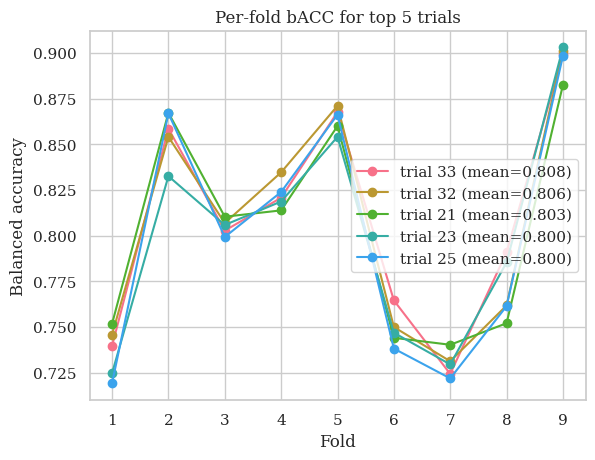

In [32]:
top_k = 5
top = df_sorted.head(top_k)

plt.figure()
for _, r in top.iterrows():
    fb = r["fold_bacc"]
    if fb is None:
        continue
    plt.plot(range(1, len(fb) + 1), fb, marker="o",
             label=f"trial {int(r['trial'])} (mean={r['mean_bacc']:.3f})")

plt.xlabel("Fold")
plt.ylabel("Balanced accuracy")
plt.title(f"Per-fold bACC for top {top_k} trials")
plt.legend()
plt.show()


In [33]:
stable_best = (
    df.dropna(subset=["mean_bacc", "std_bacc"])
      .sort_values(["mean_bacc", "std_bacc"], ascending=[False, True])
      .iloc[0]
)

print("Best stable trial:")
print(stable_best[["trial", "mean_bacc", "std_bacc"]])


Best stable trial:
trial              33
mean_bacc    0.807639
std_bacc     0.056295
Name: 33, dtype: object


### Refit best EEGNet on full training set and evaluate on test set

In [20]:
best = study.best_params

# Build final clf using best params
set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_eegnet = build_eegnet_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=best["lr"],
    batch_size=best["batch_size"],
    weight_decay=best["weight_decay"],
    drop_prob=best["drop_prob"],
    F1=best["F1"],
    D=best["D"],
    kernel_length=best["kernel_length"],
    depthwise_kernel_length=best["depthwise_kernel_length"],
    max_epochs=MAX_EPOCHS,
)

final_clf_eegnet.fit(train_set, y=None)

# Test evaluation
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = final_clf_eegnet.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet HPO+CV (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_balanced_accuracy    train_loss     dur
-------  ----------------  -------------------------  ------------  ------
      1            0.8631                     0.6577        0.3324  3.4025
      2            0.8900                     0.7466        0.2735  3.3653
      3            0.8923                     0.7505        0.2665  3.3558
      4            0.8958                     0.7631        0.2608  3.3578
      5            0.8966                     0.7650        0.2580  3.3519
      6            0.8972                     0.7696        0.2543  3.3559
      7            0.8975                     0.7681        0.2510  3.3660
      8            0.9017                     0.7775        0.2487  3.3600
      9            0.9026                     0.7815        0.2466  3.3516
     10            0.9032                     0.7836        0.2452  3.3575
     11            0.9047                     0.7867        0.2392  3.3574
     12            0.9052

NameError: name 'accuracy_score' is not defined

In [21]:
best

{'lr': 0.00035245793071781275,
 'batch_size': 32,
 'weight_decay': 7.4259271410164125e-06,
 'drop_prob': 0.5941040909682417,
 'F1': 32,
 'D': 4,
 'kernel_length': 64,
 'depthwise_kernel_length': 8,
 'patience': 8}

In [26]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet HPO+CV (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")

EEGNet HPO+CV (test)
  accuracy: 0.9178
  balanced_accuracy: 0.8840
  roc_auc: 0.9598
  avg_precision: 0.8672


### Save weights

In [27]:
import os

save_dir = "models_eegnet"
os.makedirs(save_dir, exist_ok=True)

seed = 2025
run_id = "hpo_v1"

path_eegnet = os.path.join(
    save_dir,
    f"eegnet_{run_id}_seed{seed}.pkl"
)

final_clf_eegnet.save_params(f_params=path_eegnet)

#clf.load_params(f_params=path_eegnet)

## Plots

Functions and imports to plot

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score,
    accuracy_score,
)

def _get_y_true(ds, label_col_preference=("target", "label")) -> np.ndarray:
    meta = ds.get_metadata()
    for col in label_col_preference:
        if col in meta.columns:
            return meta[col].to_numpy().astype(int)
    # fallback: second element of each item (works for many datasets, but slower)
    return np.array([ds[i][1] for i in range(len(ds))], dtype=int)

def _get_proba_and_pred(clf, ds):
    """
    Returns:
      y_true: (n,)
      y_proba: (n, 2) for binary OR (n, n_classes) for multiclass
      y_pred: (n,)
    """
    y_true = _get_y_true(ds)

    # EEGClassifier exposes predict_proba / predict in most setups
    y_proba = clf.predict_proba(ds)
    y_pred = clf.predict(ds)

    y_proba = np.asarray(y_proba)
    y_pred = np.asarray(y_pred).astype(int)
    return y_true, y_proba, y_pred

def plot_confmat(y_true, y_pred, title="Confusion matrix", normalize=None):
    #normalize: None | "true" | "pred" | "all" (sklearn option)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_title(title)
    plt.show()


def plot_history_loss_and_accuracy(clf, title="Training curves (loss + accuracy)"):
    """
    Plots loss and (if available) accuracy on the same figure using twin y-axes.
    Compatible with multiple skorch versions.
    """

    hist_obj = getattr(clf, "history", None)
    if hist_obj is None:
        print("No clf.history found. Did you fit the model?")
        return

    # skorch History often supports .to_list()
    if hasattr(hist_obj, "to_list"):
        hist = pd.DataFrame(hist_obj.to_list())
    else:
        # fallback: try to coerce history directly
        try:
            hist = pd.DataFrame(hist_obj)
        except Exception:
            print("Could not convert clf.history to a table. Available:", dir(hist_obj))
            return

    if hist.empty:
        print("History is empty. Did training run?")
        return

    # Identify columns (names differ depending on callbacks and versions)
    loss_candidates = ["train_loss", "valid_loss"]
    acc_candidates = ["train_accuracy", "valid_accuracy", "train_acc", "valid_acc", "accuracy", "acc"]

    loss_cols = [c for c in loss_candidates if c in hist.columns]
    acc_cols = [c for c in acc_candidates if c in hist.columns]

    # If you have epochs in history, use them, else use index
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    if loss_cols:
        for c in loss_cols:
            ax1.plot(x, hist[c].values, label=c)
        ax1.set_ylabel("Loss")
    else:
        ax1.text(0.5, 0.5, f"No loss columns found. Columns: {list(hist.columns)}",
                 ha="center", va="center")
        plt.show()
        return

    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(x, hist[c].values, linestyle=":", label=c)
        ax2.set_ylabel("Accuracy")

        # Merge legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    else:
        ax1.legend(loc="best")
        print("Note: No accuracy columns found in history. Add an EpochScoring accuracy callback to log it.")

    plt.show()

def plot_history_loss_acc_bacc(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history.to_list())  # works across skorch versions
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    loss_cols = [c for c in ["train_loss", "valid_loss"] if c in hist.columns]
    acc_cols  = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    bacc_cols = [c for c in ["train_balanced_accuracy", "valid_balanced_accuracy"] if c in hist.columns]

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    for c in loss_cols:
        ax1.plot(x, hist[c].values, label=c)
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    for c in acc_cols:
        ax2.plot(x, hist[c].values, linestyle=":", label=c)
    for c in bacc_cols:
        ax2.plot(x, hist[c].values, linestyle="--", label=c)
    ax2.set_ylabel("Score")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.show()

def plot_roc_and_pr(y_true, y_proba, title_prefix="Curves"):
    """
    Plots ROC and Precision Recall for binary classification.
    If not binary, it will still try but may skip AUC/AP.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)

    if is_binary:
        scores = y_proba[:, 1]
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)

        axes[0].plot(fpr, tpr)
        axes[0].set_title(f"{title_prefix}: ROC (AUC={auc:.3f})")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        prec, rec, _ = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)

        axes[1].plot(rec, prec)
        axes[1].set_title(f"{title_prefix}: Precision-Recall (AP={ap:.3f})")
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
    else:
        axes[0].text(0.5, 0.5, "ROC curve: binary only", ha="center", va="center")
        axes[1].text(0.5, 0.5, "PR curve: binary only", ha="center", va="center")

    plt.tight_layout()
    plt.show()


def print_basic_metrics(y_true, y_proba, y_pred, header="Metrics"):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)

    auc = np.nan
    ap = np.nan
    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)
    if is_binary:
        auc = roc_auc_score(y_true, y_proba[:, 1])
        ap = average_precision_score(y_true, y_proba[:, 1])

    print(header)
    print(f"  accuracy:          {acc:.4f}")
    print(f"  balanced_accuracy: {bacc:.4f}")
    print(f"  roc_auc:           {auc:.4f}")
    print(f"  avg_precision:     {ap:.4f}")


### No HPO and CV

Training plots

NO HPO/CV (train)
  accuracy:          0.9887
  balanced_accuracy: 0.9849
  roc_auc:           0.9993
  avg_precision:     0.9968


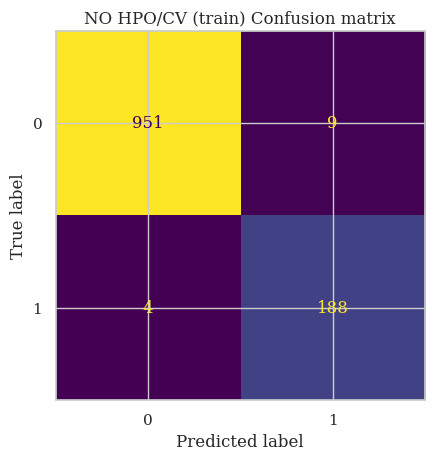

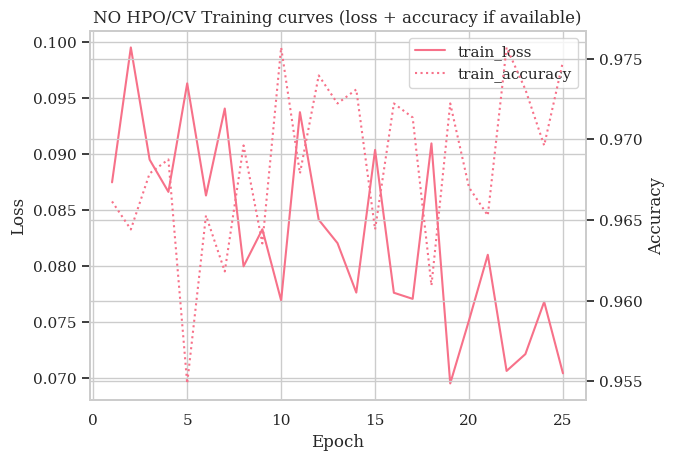

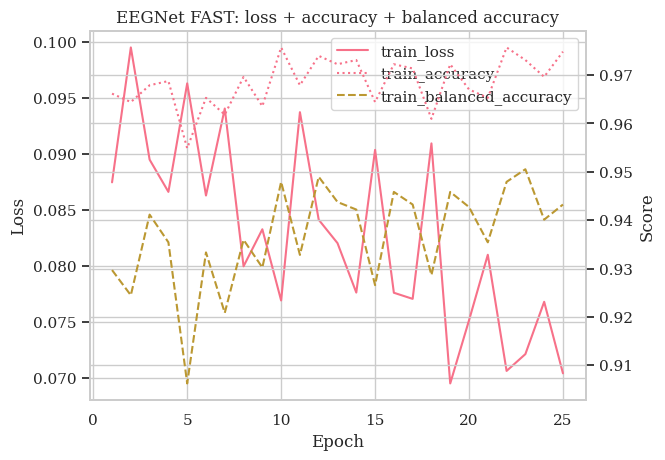

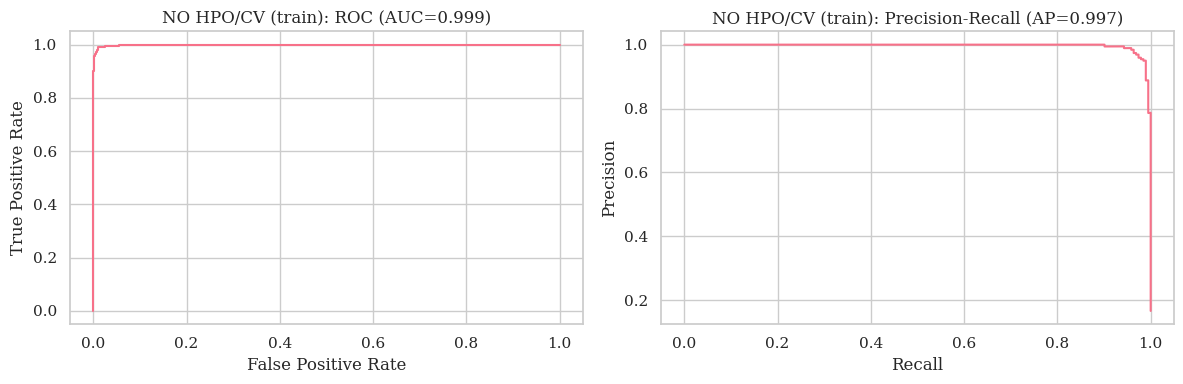

In [44]:
# training plots (confusion matrix, loss+accuracy, ROC+PR, balanced accuracy)

y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(clf_eegnet_fast, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="NO HPO/CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="NO HPO/CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    clf_eegnet_fast,
    title="NO HPO/CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    clf_eegnet_fast, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="NO HPO/CV (train)"
)


Test plots

NO HPO/CV (test)
  accuracy:          0.9080
  balanced_accuracy: 0.8365
  roc_auc:           0.9144
  avg_precision:     0.7961


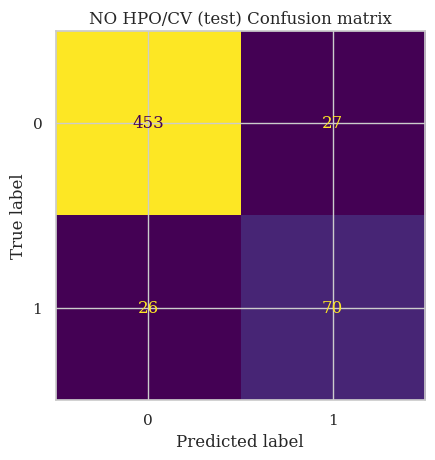

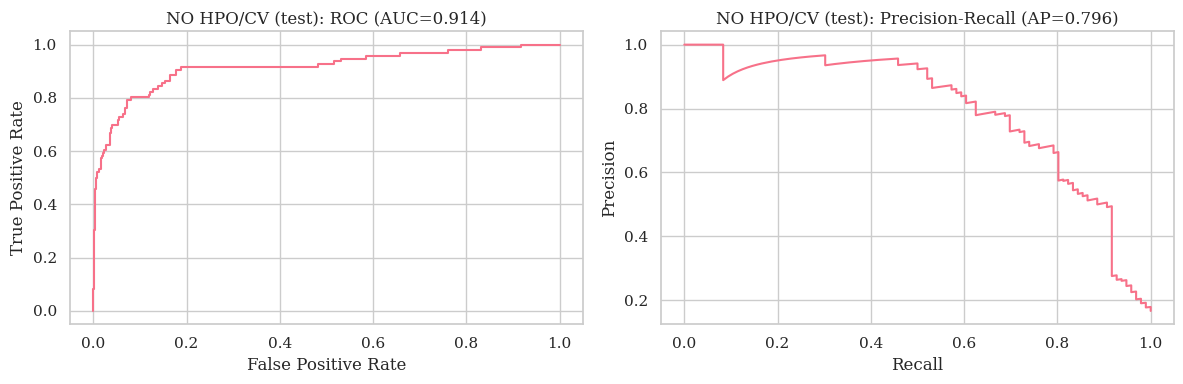

In [46]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(clf_eegnet_fast, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="NO HPO/CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="NO HPO/CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="NO HPO/CV (test)"
)


### HPO and CV

Training plots

HPO+CV (train)
  accuracy:          0.9191
  balanced_accuracy: 0.8902
  roc_auc:           0.9584
  avg_precision:     0.8595


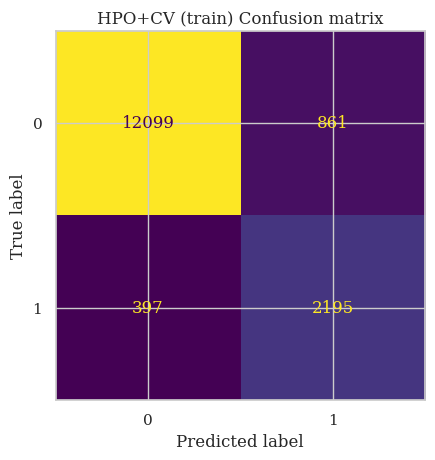

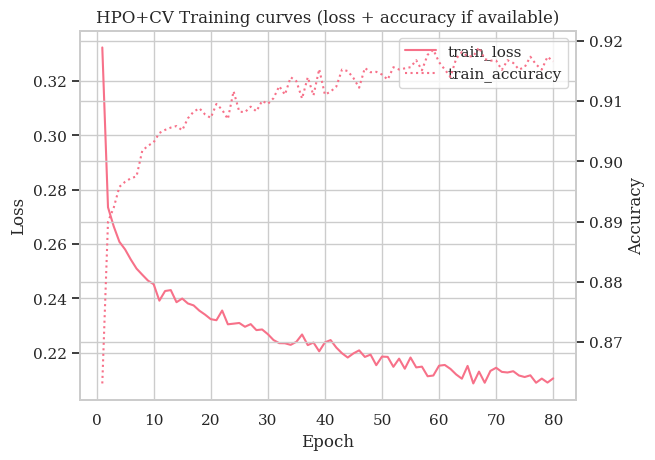

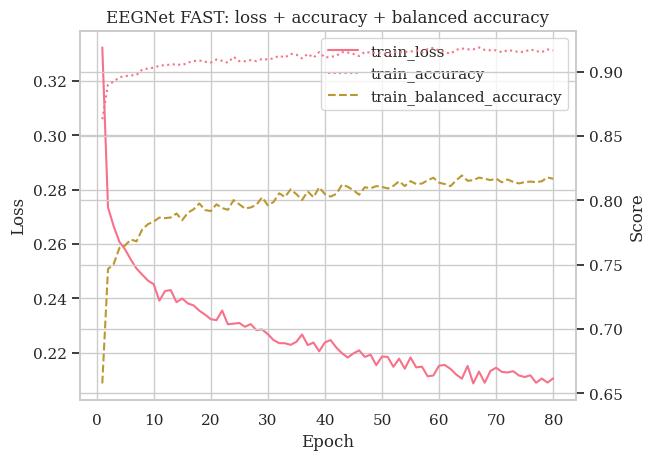

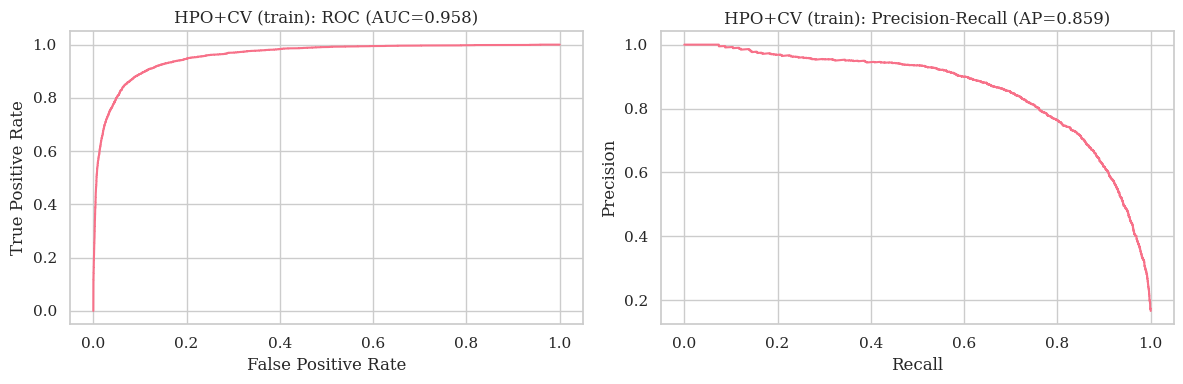

In [29]:
y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(final_clf_eegnet, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="HPO+CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="HPO+CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    final_clf_eegnet,
    title="HPO+CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    final_clf_eegnet, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="HPO+CV (train)"
)


Test plots

HPO+CV (test)
  accuracy:          0.9178
  balanced_accuracy: 0.8840
  roc_auc:           0.9598
  avg_precision:     0.8672


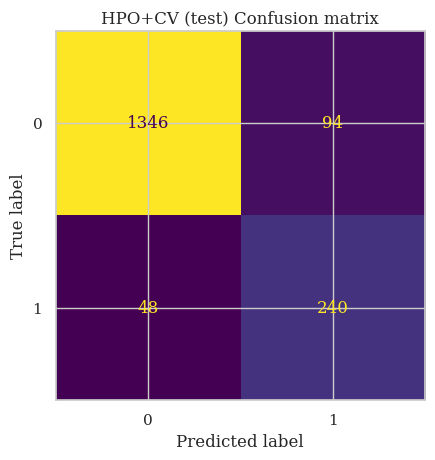

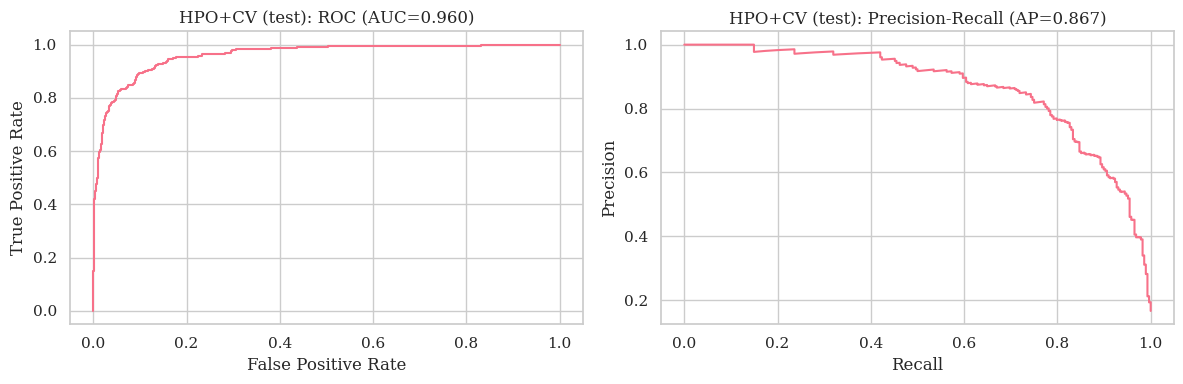

In [30]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(final_clf_eegnet, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="HPO+CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="HPO+CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="HPO+CV (test)"
)


# Fine-tuning

## Helper functions

### Create split inside the held out participant

- Use session 1 and 2 for adaptation and session 3 for testing

In [ ]:
from torch.utils.data import Subset

meta_test = test_set.get_metadata().reset_index(drop=True)

# Identify the held-out subject id in test_set (should be 1 unique subject)
heldout_subjects = meta_test["subject"].unique()
HELDOUT_SUBJECT = int(heldout_subjects[0])
print("HELDOUT_SUBJECT =", HELDOUT_SUBJECT)

# Pick sessions for adaptation vs evaluation
sessions_sorted = sorted(meta_test["session"].unique())
print("sessions_sorted:", sessions_sorted)

# Default: first two sessions adapt, last session test
adapt_sessions = sessions_sorted[:-1]
test_sessions  = [sessions_sorted[-1]]

adapt_idx = meta_test.index[meta_test["session"].isin(adapt_sessions)].to_numpy()
subjtest_idx = meta_test.index[meta_test["session"].isin(test_sessions)].to_numpy()

adapt_pool_ds = Subset(test_set, adapt_idx)
subject_test_ds = Subset(test_set, subjtest_idx)

print("Adapt pool windows:", len(adapt_pool_ds))
print("Subject test windows:", len(subject_test_ds))

# Labels for these subsets (pull from metadata to avoid iterating)
y_adapt = meta_test.loc[adapt_idx, "target"].to_numpy().astype(int)
y_subjtest = meta_test.loc[subjtest_idx, "target"].to_numpy().astype(int)

print("Adapt label counts:", {k: int(v) for k, v in zip(*np.unique(y_adapt, return_counts=True))})
print("Test  label counts:", {k: int(v) for k, v in zip(*np.unique(y_subjtest, return_counts=True))})

HELDOUT_SUBJECT = 10
sessions_sorted: ['0', '1', '2']
Adapt pool windows: 1152
Subject test windows: 576
Adapt label counts: {0: 960, 1: 192}
Test  label counts: {0: 480, 1: 96}


### Subsamble the adaptation pool by percentage (stratified)

- this keeps the target and non-target balance roughly stable while you vary "how much data" is added
- Randomly taking 5% or 10% of windows can end up in being a lot of non-targets
    - all_indices: array of indices (relative to adapt_pool_ds / meta_test after filtering)
    - y: labels aligned with all_indices
    - frac: float in (0, 1]
    - rng: np.random.RandomState


In [ ]:
def stratified_subsample_indices(all_indices, y, frac, rng):
    if not (0 < frac <= 1.0):
        raise ValueError("frac must be in (0, 1].")

    chosen = []
    for cls in np.unique(y):
        cls_mask = (y == cls)
        cls_idx = all_indices[cls_mask]
        n_take = max(1, int(np.ceil(frac * len(cls_idx))))
        # sample without replacement
        take = rng.choice(cls_idx, size=min(n_take, len(cls_idx)), replace=False)
        chosen.append(take)

    chosen = np.concatenate(chosen)
    rng.shuffle(chosen)
    return chosen

### Metric function

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

def eval_clf_on_dataset(clf, ds, y_true):
    proba = clf.predict_proba(ds)
    y_pred = np.argmax(proba, axis=1)

    out = {
        "acc": float(accuracy_score(y_true, y_pred)),
        "bacc": float(balanced_accuracy_score(y_true, y_pred)),
    }

    # Only meaningful for binary P300
    if len(np.unique(y_true)) == 2:
        out["auc"] = float(roc_auc_score(y_true, proba[:, 1]))
        out["ap"]  = float(average_precision_score(y_true, proba[:, 1]))
    else:
        out["auc"] = np.nan
        out["ap"]  = np.nan

    return out

### Freeze helpers 
- freee everything and unfreeze only deeper layers

In [ ]:
import re

def freeze_all(module):
    for _, p in module.named_parameters():
        p.requires_grad = False

def unfreeze_matching(module, regex_list):
    patterns = [re.compile(rgx) for rgx in regex_list]
    trainable = []
    for name, p in module.named_parameters():
        if any(rgx.search(name) for rgx in patterns):
            p.requires_grad = True
            trainable.append(name)
    return trainable

def freeze_all_but(module, trainable_regexes):
    freeze_all(module)
    trainable = unfreeze_matching(module, trainable_regexes)
    frozen = [n for n, p in module.named_parameters() if not p.requires_grad]
    return trainable, frozen

def print_trainable(module):
    n_train = 0
    n_total = 0
    for name, p in module.named_parameters():
        n_total += p.numel()
        if p.requires_grad:
            n_train += p.numel()
            print("TRAIN", name, tuple(p.shape))
    print("Trainable params:", n_train, "of", n_total)


## ShallowFBCSNet

### HPO results

In [32]:
lr = 0.002718940016156451
MAX_EPOCHS = 80
batch_size = 128
weight_decay = 0.00010871003877839412
patience = 11
drop_prob = 0.4920220213261243
n_filters_time = 40
filter_time_length = 65
n_filters_spat = 32
pool_time_length = 25
pool_time_stride = pool_time_length // 2

In [21]:
import numpy as np
import torch

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("device:", device)


device: cuda


### Path to saved weights 

In [25]:
import os

save_dir = "models_shallow"
seed = 2025
run_id = "hpo_v1"

path_shallow = os.path.join(save_dir, f"shallow_{run_id}_seed{seed}.pkl")
print("Loading weights from:", path_shallow)
print("Exists:", os.path.exists(path_shallow))



Loading weights from: models_shallow/shallow_hpo_v1_seed2025.pkl
Exists: True


### Build ShallowFBCSPNet

In [41]:
import torch
import numpy as np

from braindecode.models import ShallowFBCSPNet
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split

from sklearn.metrics import balanced_accuracy_score, make_scorer

train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_bacc",
    lower_is_better=False,
)

valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_bacc",
    lower_is_better=False,
)

def make_shallow_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    max_epochs,
    batch_size,
    weight_decay,
    patience,
    drop_prob,
    n_filters_time,
    filter_time_length,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    valid_ds=None,
):
    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None
    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor="valid_loss",
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__drop_last=False,
        iterator_valid__drop_last=False,
        train_split=train_split,
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf


### Load saved general weights into classifier and evaluate baseline

In [44]:
set_random_seeds(seed=2026, cuda=cuda)

general_clf = make_shallow_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=lr,
    max_epochs=MAX_EPOCHS,          
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,
    drop_prob=drop_prob,
    n_filters_time=n_filters_time,
    filter_time_length=filter_time_length,
    n_filters_spat=n_filters_spat,
    pool_time_length=pool_time_length,
    pool_time_stride=pool_time_stride,
    valid_ds=None,
)

general_clf.initialize()
general_clf.load_params(f_params=path_shallow)

baseline = eval_clf_on_dataset(general_clf, subject_test_ds, y_subjtest)
print("Baseline (loaded general model):", baseline)

print("First parameter names (for choosing freeze patterns):")
for name, _ in list(general_clf.module_.named_parameters())[:40]:
    print(name)


Baseline (loaded general model): {'acc': 0.9010416666666666, 'bacc': 0.8364583333333333, 'auc': 0.9389539930555555, 'ap': 0.8108625935357757}
First parameter names (for choosing freeze patterns):
conv_time_spat.conv_time.weight
conv_time_spat.conv_time.bias
conv_time_spat.conv_spat.weight
bnorm.weight
bnorm.bias
final_layer.conv_classifier.weight
final_layer.conv_classifier.bias


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


### Fine-tune with increasing fractions

- Learning curve to see how much subject data is enough before gains saturate.
- Doing a full fine-tuning
    - every personalisation run starts from exactly the same cross-subject solution


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.1          # smaller LR for subject-specific tuning
ft_max_epochs = 80        # cap epochs 
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # stratified sample from adaptation pool
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)

    # Use ALL chosen adaptation data for fine-tuning (no valid split)
    ft_train_ds = chosen_ds

    # Ensure we never have batch_size > dataset size (avoids 0 batches)
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(f"frac={frac} | n_adapt={len(ft_train_ds)} | ft_batch_size={ft_batch_size}")


    # Build fine-tune classifier (no early stopping => valid_ds=None)
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_shallow_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience,     # not used when valid_ds=None, but harmless
        drop_prob=drop_prob,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        valid_ds=None,         # disables predefined_split + early stopping
    )

    # init, then load your saved general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_shallow)

    # Freeze everything except classifier head
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=[
            r"^final_layer\.conv_classifier\.",
        ],
    )

    # Rebuild optimizer after freezing
    ft_clf.initialize_optimizer()

    # Enable warm_start to continue training from loaded weights
    # tells skorch not to reinitialize between .fit() calls
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (head-only):")
        print_trainable(ft_clf.module_)
        print("Example frac:", frac, "| n_adapt:", len(chosen_ds))

    # Fine-tune on chosen adaptation data
    # continute training from loaded weights
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on fixed held-out session test split
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results_head_only = pd.DataFrame(results)
df_results_head_only


frac=0.01 | n_adapt=12 | ft_batch_size=12
Trainable layers (head-only):
TRAIN final_layer.conv_classifier.weight (2, 32, 27, 1)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 1730 of 14674
Example frac: 0.01 | n_adapt: 12
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        1.0000        0.1189  0.0030
      2        1.0000        0.0502  0.0019
      3        1.0000        0.0263  0.0019
      4        1.0000        0.1047  0.0019
      5        1.0000        0.0467  0.0019
      6        0.7000        0.1731  0.0019
      7        1.0000        0.0676  0.0019
      8        1.0000        0.0726  0.0019
      9        1.0000        0.0880  0.0019
     10        0.7500        0.1322  0.0018
     11        1.0000        0.0859  0.0018
     12        1.0000        0.0684  0.0019
     13        1.0000        0.0492  0.0018
     14        1.0000        0.0503  0.0018
     15        1.0000        0.0272  0.0019
     16        

     39        1.0000        0.0098  0.0018
     40        1.0000        0.0435  0.0018
     41        1.0000        0.0365  0.0019
     42        1.0000        0.0149  0.0019
     43        1.0000        0.0050  0.0018
     44        1.0000        0.0234  0.0018
     45        1.0000        0.0148  0.0019
     46        1.0000        0.0101  0.0019
     47        1.0000        0.0162  0.0019
     48        1.0000        0.0055  0.0019
     49        1.0000        0.0107  0.0019
     50        1.0000        0.0059  0.0019
     51        1.0000        0.0195  0.0019
     52        1.0000        0.0201  0.0019
     53        1.0000        0.0068  0.0019
     54        1.0000        0.0129  0.0019
     55        1.0000        0.0111  0.0018
     56        1.0000        0.0119  0.0019
     57        1.0000        0.0045  0.0019
     58        1.0000        0.0133  0.0019
     59        1.0000        0.0113  0.0019
     60        1.0000        0.0045  0.0019
     61        1.0000        0.0

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     63        1.0000        0.0125  0.0018
     64        1.0000        0.0101  0.0019
     65        1.0000        0.0087  0.0019
     66        1.0000        0.0084  0.0019
     67        1.0000        0.0044  0.0019
     68        1.0000        0.0115  0.0018
     69        1.0000        0.0124  0.0018
     70        1.0000        0.0085  0.0019
     71        1.0000        0.0079  0.0018
     72        1.0000        0.0221  0.0019
     73        1.0000        0.0053  0.0019
     74        1.0000        0.0132  0.0019
     75        1.0000        0.0059  0.0019
     76        1.0000        0.0046  0.0019
     77        1.0000        0.0084  0.0019
     78        1.0000        0.0146  0.0020
     79        1.0000        0.0075  0.0019
     80        1.0000        0.0102  0.0019
frac=0.01 | n_adapt=  12 | bacc=0.825 | acc=0.896 | auc=0.9368923611111112 | ap=0.7934179820755085
frac=0.02 | n_adapt=24 | ft_batch_size=24
  epoch    train_bacc    train_loss     dur
-------  ------------  

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     59        0.8750        0.0920  0.0021
     60        1.0000        0.0415  0.0021
     61        1.0000        0.0469  0.0021
     62        1.0000        0.0280  0.0021
     63        0.8750        0.0707  0.0021
     64        1.0000        0.0219  0.0021
     65        1.0000        0.0556  0.0021
     66        1.0000        0.0281  0.0021
     67        1.0000        0.0173  0.0021
     68        1.0000        0.0366  0.0021
     69        1.0000        0.0201  0.0021
     70        1.0000        0.0195  0.0021
     71        1.0000        0.0329  0.0021
     72        1.0000        0.0215  0.0021
     73        1.0000        0.0178  0.0021
     74        1.0000        0.0397  0.0021
     75        1.0000        0.0103  0.0022
     76        1.0000        0.0343  0.0021
     77        1.0000        0.0377  0.0021
     78        1.0000        0.0410  0.0021
     79        1.0000        0.0168  0.0021
     80        1.0000        0.0190  0.0021
frac=0.02 | n_adapt=  24 | bacc=

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     44        0.9000        0.0774  0.0030
     45        1.0000        0.0362  0.0030
     46        1.0000        0.0393  0.0030
     47        1.0000        0.0400  0.0030
     48        1.0000        0.0405  0.0030
     49        1.0000        0.0516  0.0030
     50        1.0000        0.0229  0.0030
     51        1.0000        0.0391  0.0030
     52        0.9396        0.0653  0.0030
     53        1.0000        0.0489  0.0030
     54        1.0000        0.0454  0.0030
     55        1.0000        0.0323  0.0030
     56        1.0000        0.0271  0.0030
     57        1.0000        0.0380  0.0030
     58        1.0000        0.0252  0.0030
     59        1.0000        0.0240  0.0031
     60        1.0000        0.0303  0.0031
     61        1.0000        0.0173  0.0031
     62        0.9896        0.0588  0.0031
     63        1.0000        0.0365  0.0031
     64        1.0000        0.0263  0.0031
     65        0.9896        0.0556  0.0031
     66        0.9500        0.0

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     30        0.8896        0.2381  0.0056
     31        0.8594        0.2018  0.0053
     32        0.8396        0.2205  0.0054
     33        0.8844        0.1759  0.0050
     34        0.8844        0.1903  0.0052
     35        0.9094        0.1869  0.0057
     36        0.8750        0.1849  0.0055
     37        0.8990        0.2254  0.0054
     38        0.8594        0.1567  0.0056
     39        0.8500        0.1578  0.0054
     40        0.8948        0.1957  0.0055
     41        0.9094        0.1804  0.0050
     42        0.9198        0.1629  0.0052
     43        0.9094        0.1492  0.0056
     44        0.8448        0.1842  0.0054
     45        0.9000        0.1454  0.0047
     46        0.8594        0.2210  0.0052
     47        0.8896        0.1828  0.0051
     48        0.8948        0.1421  0.0053
     49        0.8146        0.1514  0.0051
     50        0.8396        0.1713  0.0052
     51        0.8490        0.1955  0.0053
     52        0.8844        0.1

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     18        0.8946        0.1665  0.0104
     19        0.9151        0.1220  0.0092
     20        0.8998        0.1448  0.0090
     21        0.9048        0.1265  0.0092
     22        0.8844        0.1445  0.0094
     23        0.8972        0.1449  0.0091
     24        0.8894        0.1742  0.0093
     25        0.8868        0.1441  0.0094
     26        0.9024        0.0968  0.0093
     27        0.8972        0.1217  0.0100
     28        0.8690        0.1372  0.0098
     29        0.9255        0.0909  0.0098
     30        0.9075        0.1279  0.0093
     31        0.9409        0.1028  0.0093
     32        0.9075        0.1132  0.0093
     33        0.9125        0.1207  0.0099
     34        0.9229        0.1093  0.0098
     35        0.9383        0.1197  0.0093
     36        0.9229        0.1012  0.0098
     37        0.9153        0.0938  0.0100
     38        0.9075        0.1305  0.0099
     39        0.9153        0.0904  0.0094
     40        0.9409        0.0

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


     10        0.8649        0.2151  0.0179
     11        0.8376        0.1892  0.0182
     12        0.8597        0.1929  0.0180
     13        0.8740        0.1754  0.0180
     14        0.8649        0.1948  0.0180
     15        0.8714        0.1696  0.0180
     16        0.9000        0.1641  0.0180
     17        0.8727        0.1783  0.0182
     18        0.8818        0.1430  0.0179
     19        0.8428        0.1631  0.0179
     20        0.8740        0.1515  0.0179
     21        0.8727        0.1362  0.0179
     22        0.9182        0.1416  0.0181
     23        0.8662        0.1628  0.0180
     24        0.8857        0.1479  0.0180
     25        0.8844        0.1638  0.0181
     26        0.8649        0.1534  0.0178
     27        0.9000        0.1332  0.0179
     28        0.8818        0.1351  0.0180
     29        0.8935        0.1510  0.0180
     30        0.9065        0.1208  0.0180
     31        0.9013        0.1236  0.0180
     32        0.8896        0.1

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      7        0.8464        0.1985  0.0283
      8        0.8619        0.2020  0.0274
      9        0.8611        0.1960  0.0275
     10        0.8533        0.1844  0.0279
     11        0.8593        0.1894  0.0278
     12        0.8861        0.1903  0.0281
     13        0.8706        0.1704  0.0278
     14        0.8852        0.1573  0.0277
     15        0.8671        0.1851  0.0278
     16        0.8887        0.1643  0.0277
     17        0.8689        0.1553  0.0273
     18        0.8809        0.1681  0.0277
     19        0.8965        0.1523  0.0275
     20        0.8999        0.1558  0.0276
     21        0.9068        0.1299  0.0274
     22        0.8810        0.1536  0.0276
     23        0.8792        0.1426  0.0274
     24        0.9025        0.1341  0.0280
     25        0.8973        0.1462  0.0278
     26        0.8922        0.1624  0.0273
     27        0.8896        0.1319  0.0280
     28        0.8991        0.1321  0.0276
     29        0.8974        0.1

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      6        0.8629        0.1793  0.0362
      7        0.8675        0.1912  0.0362
      8        0.8500        0.1929  0.0364
      9        0.8876        0.1752  0.0367
     10        0.8623        0.1771  0.0358
     11        0.8714        0.1841  0.0359
     12        0.8480        0.1689  0.0360
     13        0.8727        0.1583  0.0359
     14        0.8766        0.1472  0.0364
     15        0.8837        0.1788  0.0365
     16        0.8824        0.1653  0.0362
     17        0.8948        0.1579  0.0382
     18        0.8980        0.1445  0.0361
     19        0.9116        0.1364  0.0359
     20        0.8772        0.1562  0.0389
     21        0.9032        0.1392  0.0364
     22        0.8961        0.1388  0.0380
     23        0.8993        0.1257  0.0373
     24        0.8876        0.1363  0.0386
     25        0.9078        0.1219  0.0359
     26        0.8941        0.1322  0.0360
     27        0.9227        0.1259  0.0365
     28        0.9019        0.1

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      5        0.8453        0.2210  0.0441
      6        0.8755        0.1866  0.0437
      7        0.8625        0.1935  0.0436
      8        0.8609        0.1835  0.0440
      9        0.8635        0.2044  0.0437
     10        0.8729        0.1739  0.0435
     11        0.8703        0.1829  0.0434
     12        0.8771        0.1564  0.0437
     13        0.8781        0.1593  0.0436
     14        0.8781        0.1543  0.0436
     15        0.8885        0.1512  0.0438
     16        0.8552        0.1788  0.0440
     17        0.8823        0.1643  0.0456
     18        0.8760        0.1597  0.0453
     19        0.8891        0.1422  0.0444
     20        0.9036        0.1293  0.0437
     21        0.8958        0.1314  0.0443
     22        0.9000        0.1313  0.0440
     23        0.8885        0.1406  0.0430
     24        0.9094        0.1184  0.0437
     25        0.8984        0.1308  0.0436
     26        0.9115        0.1312  0.0433
     27        0.9021        0.1

frac  n_adapt       acc      bacc       auc        ap
0  0.01       12  0.895833  0.825000  0.936892  0.793418
1  0.02       24  0.914931  0.823958  0.945486  0.821191
2  0.05       58  0.916667  0.837500  0.937305  0.803254
3  0.10      116  0.914931  0.840625  0.936719  0.804165
4  0.20      231  0.921875  0.811458  0.948025  0.824795
5  0.40      461  0.930556  0.854167  0.962088  0.878376
6  0.60      692  0.925347  0.838542  0.961241  0.869022
7  0.80      922  0.930556  0.833333  0.966602  0.887525
8  1.00     1152  0.937500  0.850000  0.967274  0.895600

### Plot personalisation learning curve

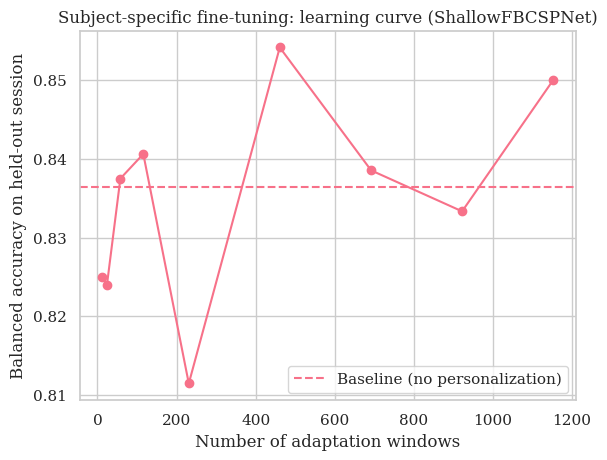

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results_head_only["n_adapt"], df_results_head_only["bacc"], marker="o")
plt.axhline(baseline["bacc"], linestyle="--", label="Baseline (no personalization)")
plt.xlabel("Number of adaptation windows")
plt.ylabel("Balanced accuracy on held-out session")
plt.title("Subject-specific fine-tuning: learning curve (ShallowFBCSPNet)")
plt.legend()
plt.show()

## EEGNet